# Directionality analysis

## Most important DataFrames and parameters
DataFrames:
* all_onsets_df: contains all neurons of all recordings, with onset and quantile values for each event (sz: quantile_sz, sd1: quantile1, sd2: quantile2)
* quantiles_df: for each recording, contains all quantiles for each event type (quantile_type)
* qdf: contains vectors (dx, dy) from first to last quantile centre for each event in all recordings
* df_mean_vectors_per_mouse: contains Cartesian and polar coordinates of vectors for each event type, per mouse, averaged over each recording. Averaging: for one mouse, calculate center of first and last quantiles, create vector as difference; take the average of x and y coordinates of these vectors.
* df_angles: contains seizure-sdx angles


Columns:
* quantile_type: sz, sd1 or sd2
* onset_sz, onset1, onset2: the onset frame for each neuron/quantile for sz, sd1, sd2, respectively
* dx, dy: The distance between the first and last quantile of <quantile_type> in pixels along the x or y axis, respectively.
* uuid_extended: uuid if the recording contained one seizure; uuid + "_1"/"_2"/... for each event group (sz + sd waves) in that recording.
* uuid_matched: manually correct uuid_extended to group seizure with sd waves that were split up by end of recording. This uuid should be unique among event groups (sz + sd waves), and the same for each group member.
* theta_inj_top: the polar angle in a reference frame where the top side is the injection side.

In [1]:
OBJECTIVE_UM_P_PX =  1.579

In [2]:
save_figs = False  # set to True to save the figures created
save_as_eps = True
if save_as_eps:
    file_format = ".eps"
else:
    file_format = ".jpg"
if save_figs:
    print(f"Going to save figures as {file_format} files.")

In [3]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import h5py
from nd2_to_caiman import np_arr_from_nd2
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib as mpl
from math import floor, ceil, sqrt, atan2, acos, pi, sin, cos
from datetime import datetime
import json
from labrotation import json_util
import scipy
from scipy import ndimage
from scipy.spatial import distance_matrix
from scipy.stats import circmean, circstd  # for statistical testing on directionality
import datadoc_util
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
import seaborn as sns
import multiprocess as mp  # multiprocessing does not work with IPython. Use fork instead.
import os
import random  # for surrogate algorithm
from collections.abc import Iterable
import math
from functools import partial

In [5]:
mpl.rcParams.update({'font.size': 20})

In [6]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
color_palette = sns.color_palette("deep")

In [7]:
def get_datetime_for_fname():
    now = datetime.now()
    return f"{now.year:04d}{now.month:02d}{now.day:02d}-{now.hour:02d}{now.minute:02d}{now.second:02d}"

In [8]:
grid_shape = (8,8)

In [9]:
env_dict = dict()
if not os.path.exists("./.env"):
    print(".env does not exist")
else:
    with open("./.env", "r") as f:
        for line in f.readlines():
            l = line.rstrip().split("=")
            env_dict[l[0]] = l[1]
print(env_dict.keys())

dict_keys(['DATA_DOCU_FOLDER', 'DOWNLOADS_FOLDER', 'LOG_FOLDER', 'MATLAB_2P_FOLDER', 'FLUO_LV_MATCHED_FOLDER'])


In [10]:
if "DATA_DOCU_FOLDER" in env_dict.keys():
    data_docu_folder = env_dict["DATA_DOCU_FOLDER"]
else:
    data_docu_folder = fh.open_dir("Open Data Documentation folder")
print(data_docu_folder)

D:\PhD\Data documentation


In [11]:
ddoc = datadoc_util.DataDocumentation(data_docu_folder)
ddoc.loadDataDoc()

In [12]:
df_colors = ddoc.getColorings()

In [13]:
dict_mouse_id_color = {row["mouse_id"]: row["color"] for i_row, row in df_colors.iterrows()}

In [14]:
output_folder = env_dict["DOWNLOADS_FOLDER"]
print(f"Output files will be saved to {output_folder}")

Output files will be saved to C:\Users\Bence\Downloads


## Open files and get uuid

In [15]:
df_id_uuid = ddoc.getIdUuid()

In [16]:
analysis_folder = fh.open_dir("Open directory with analysis (grid) data for all mice!")

In [17]:
grid_files_list = []
for root, dirs, files in os.walk(analysis_folder):
    for fname in files:
        if "_grid.h5" in fname:
            grid_files_list.append(os.path.join(root,fname))

In [18]:
uuid_dict = dict()
exp_type_dict = dict()
for grid_fpath in grid_files_list:
    # ..._grid.h5 -> ..._cnmf.hdf5
    cnmf_fpath = os.path.join(os.path.split(grid_fpath)[0], os.path.split(grid_fpath)[-1][:-7] + "cnmf.hdf5")
    with h5py.File(cnmf_fpath, 'r') as hf:
        uuid = hf.attrs["uuid"]
        exp_type = ddoc.getExperimentTypeForUuid(uuid)
        uuid_dict[grid_fpath] = hf.attrs["uuid"]
        exp_type_dict[grid_fpath] = exp_type
        

In [19]:
print(f"{len(uuid_dict)} recordings detected")

13 recordings detected


## Combine all results into one dataframe

In [20]:
cols_set = set()
for fpath in grid_files_list:
    df = pd.read_hdf(fpath)
    for key in df.keys():
        cols_set.add(key)
cols_set.add("uuid")
cols_set.add("mouse_id")
cols_set.add("exp_type")

In [21]:
# defining empty dataframe does not work, as all data types will be object (except x, y, which will be proper integers)
all_onsets_df = pd.read_hdf(grid_files_list[0])
all_onsets_df["uuid"] = uuid_dict[grid_files_list[0]]
all_onsets_df["mouse_id"] = df_id_uuid[df_id_uuid["uuid"] == uuid_dict[grid_files_list[0]]]["mouse_id"].values[0]
all_onsets_df["exp_type"] = exp_type_dict[grid_files_list[0]]

assert all_onsets_df["uuid"].isna().sum() == 0
for fpath in grid_files_list[1:]:
    df = pd.read_hdf(fpath)
    df["uuid"] = uuid_dict[fpath]
    df["mouse_id"] = df_id_uuid[df_id_uuid["uuid"] == uuid_dict[fpath]]["mouse_id"].values[0]
    df["exp_type"] = exp_type_dict[fpath]
    
    assert df["uuid"].isna().sum() == 0
    assert df["exp_type"].isna().sum() == 0
    
    all_onsets_df = pd.concat([all_onsets_df, df])

### Remove 5% most deviant onset from median for each category
Wenzel 2017 (recruitment reliability) page 8, below fig 5 (not caption)

### Make sure to have integer and float data types for the columns, and not object! (int16, int64, float64)

In [22]:
# for old files containing onset data, n_seizures was not present, as one of the last recordings processed contained 2. 
# As a result, most of i_sz values are NaN; these contain 1 sz. Otherwise 0, 1... are the seizure indices.
if "i_sz" not in all_onsets_df:  # in case we did not need it, still have the column
    all_onsets_df["i_sz"] = np.nan
all_onsets_df["i_sz"].unique()

array([nan,  0.,  1.])

In [23]:
# make seizures unique in uuid_extended
def append_uuid(row):
    if pd.isna(row['i_sz']):
        return row['uuid']
    elif row['i_sz'] >= 0:
        return row['uuid'] + '_' + str(int(row["i_sz"]+1))
all_onsets_df['uuid_extended'] = all_onsets_df.apply(append_uuid, axis=1)

In [24]:
g = all_onsets_df.groupby("mouse_id")
for group in g:
    print(group[0])
    g2 = group[1].groupby("uuid")
    for grp in g2:
        print("\t" + grp[0])
        print("\t" + str(len(grp[1])) + "\n")

T301
	171693d0988c458a96c8198c7b8cfc28
	624

	a6099849121f44ccbec237037971ab57
	585

	ae564f8c867f4f35aa971b6562c33a7c
	345

	e40f26d410ab452e8f8d59e5394ae0fe
	289

T329
	30dc55d1a5dc4b0286d132e72f208ca6
	314

	65bff16a4cf04930a5cb14f489a8f99b
	1157

	d7a5ac8e2bc74382b3db503a6a5a07a5
	715

T333
	06ebcf354f5c41519669f187e16de364
	432

	5ea6fd9c4cb542dbbc1f65305725cede
	1072

	73a27053f4bf4ae1b4ad96064b6dabc0
	593

T352
	2aa75aa234a749668eb896e7e00aa87a
	1005

	4fe45b25dc854453880cd868fe77e9d4
	402

	79fb974821f34e3abdcf5ca650e1c0f4
	257



`all_onsets_df` now contains each recording with seizure and/or SD each neuron. For each neuron, there is a value for onset of each SD and seizure wave (NaN for all neurons in a session if none occurred in the recording) 

In [25]:
def replace_outliers(group, colname):
    # calculate 5% highest deviation threshold
    # get deviations
    if colname not in group.keys():
        print(group)
        raise Exception

    median_colname = group[colname].dropna().median()

    deviations = np.abs(group[colname] - median_colname)
    deviations_nonan = np.abs(group[colname].dropna() - median_colname)
    if len(deviations_nonan) == 0:  # empty column (only NaN): skip outlier removal
        return group
    # sort in descending order
    deviations_sorted_desc = np.flip(np.sort(deviations_nonan))
    # get 5% threshold deviation value
    threshold_percent = 0.05  # 5% threshold
    deviation_threshold = deviations_sorted_desc[ceil(threshold_percent*len(deviations_sorted_desc))]
    if sum(deviations > deviation_threshold) == 0:
        # in this case, most likely the outliers are not true outliers, but the range of onset is small.
        pass
    n_nan = group[colname].isna().sum()
    group.loc[deviations > deviation_threshold, colname] = np.nan
    n_nan_post = group[colname].isna().sum()
    #print(f"{n_nan} -> {n_nan_post} (should be {ceil(threshold_percent*len(deviations_sorted_desc))})")
    return group


In [26]:
replace_onset1_outliers = partial(replace_outliers, colname="onset1")
replace_onset2_outliers = partial(replace_outliers, colname="onset2")
replace_onsetsz_outliers = partial(replace_outliers, colname="onset_sz")

In [27]:
all_onsets_df_outliers_removed = all_onsets_df.groupby("uuid_extended").apply(replace_onset1_outliers).groupby("uuid_extended").apply(replace_onset2_outliers).groupby("uuid_extended").apply(replace_onsetsz_outliers)

### Overtake removal of the outliers

In [28]:
remove_outliers = True
if remove_outliers:
    all_onsets_df = all_onsets_df_outliers_removed

## Observe quartiles in one session, one event, per neuron

In [29]:
#MOUSE_ID="T352"
MOUSE_ID="WEZ-8922"

In [30]:
# TODO: implement easy way to pick a mouse and a specific sd/sz
plot_quantiles = False
if plot_quantiles:
    uuids = all_onsets_df["uuid_extended"].unique()
    selected_uuid = uuids[3]
    selected_df = all_onsets_df[all_onsets_df["uuid"] == selected_uuid]
    event_type = "quantile_sz"#"quantile1"

    fig = plt.figure(figsize=(18,18), )
    plt.suptitle(f"Top={ddoc.getTopDirection(MOUSE_ID)}", fontsize=24)
    ax = plt.gca()
    sns.scatterplot(x="x", y="y",
                    hue=event_type, style=event_type, size=event_type,
                    sizes=(100,400),
                    data=selected_df, ax=ax,)

    ax.set_xlim((0, 512))
    ax.set_ylim((0,512))
    ax.legend(fontsize=20)
    ax.invert_yaxis()

    plt.show()

## Get quantiles of recruitment

### Average coordinates per quartile per session (per mouse)

In [31]:
quantile_per_session = all_onsets_df.groupby(["mouse_id", "uuid_extended", "quantile1"], as_index=False)  # NaN quantile_sz values already dropped
q_sd1_df = quantile_per_session.mean()
q_sd1_df["quantile_type"] = "sd1"
q_sd1_df.rename({"quantile1": "quantile"}, axis="columns", inplace=True)
print(q_sd1_df.columns)

quantile_per_session = all_onsets_df.groupby(["mouse_id", "uuid_extended", "quantile2"], as_index=False)  # NaN quantile_sz values already dropped
q_sd2_df = quantile_per_session.mean()
q_sd2_df["quantile_type"] = "sd2"
q_sd2_df.rename({"quantile2": "quantile"}, axis="columns", inplace=True)


quantile_per_session = all_onsets_df.groupby(["mouse_id", "uuid_extended", "quantile_sz"], as_index=False)
q_sz_df = quantile_per_session.mean()
q_sz_df["quantile_type"] = "sz"
q_sz_df.rename({"quantile_sz": "quantile"}, axis="columns", inplace=True)


quantiles_df = pd.concat([q_sd1_df, q_sd2_df, q_sz_df])

Index(['mouse_id', 'uuid_extended', 'quantile', 'neuron_id', 'x', 'y', 'row',
       'col', 'tile', 'onset1', 'onset2', 'quantile2', 'onset_sz',
       'quantile_sz', 'i_sz', 'quantile_type'],
      dtype='object')


### Inspect centre point of quantiles per mouse and per event type

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


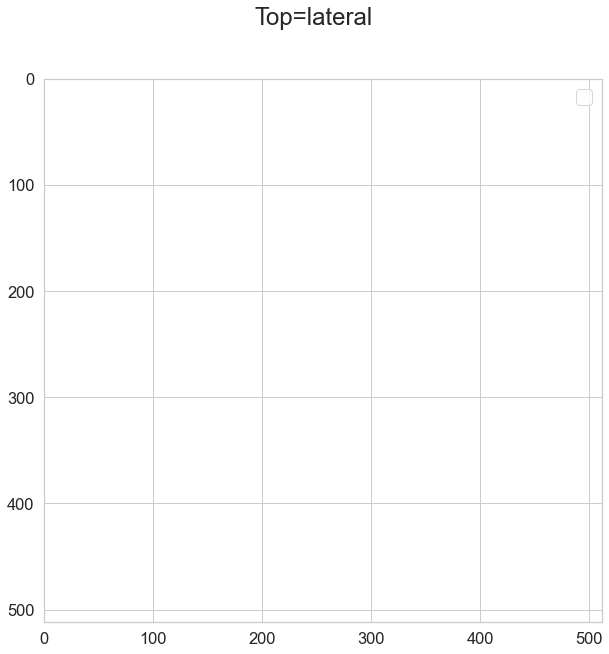

In [32]:
#MOUSE_ID = "T352"
EVENT_TYPE = "sd2"

fig = plt.figure(figsize=(10,10), )
plt.suptitle(f"Top={ddoc.getTopDirection(MOUSE_ID)}", fontsize=24)
ax = plt.gca()
sns.scatterplot(x="x", y="y",
                hue="quantile", style="quantile", size="quantile",
                sizes=(100,400),
                data=quantiles_df[(quantiles_df["mouse_id"] == MOUSE_ID) & (quantiles_df["quantile_type"] == EVENT_TYPE)], ax=ax,)




ax.set_xlim((0, 512))
ax.set_ylim((0,512))
ax.legend(fontsize=20)
ax.invert_yaxis()

plt.show()

In [33]:
ex_uuid = "30dc55d1a5dc4b0286d132e72f208ca6"
df_ex = all_onsets_df[all_onsets_df["uuid"] == ex_uuid]

In [34]:
plt.rcParams['legend.title_fontsize'] = 40

In [35]:
df_ex_first = quantiles_df[(quantiles_df["uuid_extended"] == ex_uuid) & (quantiles_df["quantile_type"] == "sd1") & (quantiles_df["quantile"] == 0.0)]
df_ex_last = quantiles_df[(quantiles_df["uuid_extended"] == ex_uuid) & (quantiles_df["quantile_type"] == "sd1") & (quantiles_df["quantile"] == 3.0)]

In [36]:
df_vec_ex = pd.DataFrame({"x": [df_ex_first.x.iloc[0], df_ex_last.x.iloc[0]], "y": [df_ex_first.y.iloc[0], df_ex_last.y.iloc[0]], "type": ["begin", "end"]})


In [37]:
ex_arrow_x0 = df_vec_ex[df_vec_ex["type"] == "begin"].x.iloc[0]
ex_arrow_y0 = df_vec_ex[df_vec_ex["type"] == "begin"].y.iloc[0]

ex_arrow_x1 = df_vec_ex[df_vec_ex["type"] == "end"].x.iloc[0]
ex_arrow_y1 = df_vec_ex[df_vec_ex["type"] == "end"].y.iloc[0]



ex_arrow_dx = ex_arrow_x1 - ex_arrow_x0
ex_arrow_dy = ex_arrow_y1 - ex_arrow_y0

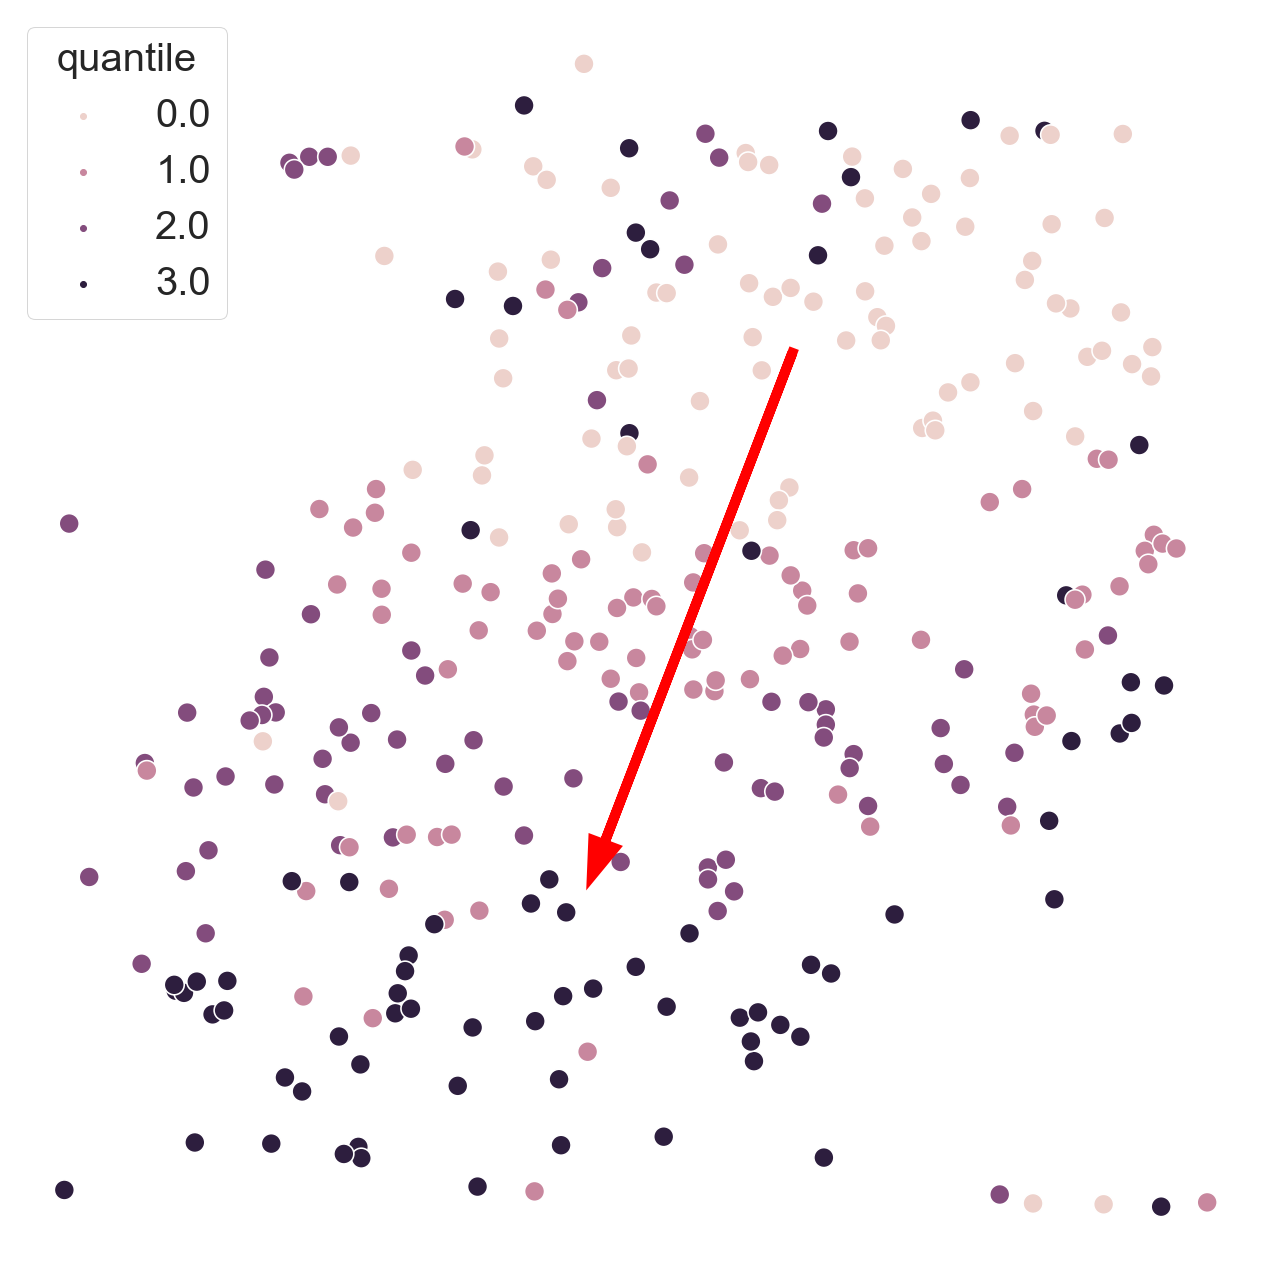

In [38]:
fig = plt.figure(figsize=(18,18))
ax = plt.gca()
sns.scatterplot(data=df_ex, x="x", y="y", hue="quantile1", s=400, ax=ax)
#sns.scatterplot(data=df_vec_ex, x="x", y="y", hue="type", s=400, legend=False, ax=ax)
#ax.quiver(ex_arrow_x0, ex_arrow_y0, [ex_arrow_dx], [ex_arrow_dy])
plt.arrow(ex_arrow_x0, ex_arrow_y0, ex_arrow_dx, ex_arrow_dy, color="red", linewidth=10, head_width=10)
sns.despine(left=True, right=True, top=True, bottom=True)
ax.legend(title="quantile", fontsize=40)
ax.invert_yaxis()
plt.axis("off")
plt.tight_layout()
#plt.savefig("D:\\example_onset.eps")
plt.show()

In [39]:
# TODO: for each quantile, plot cells, k-means clustering? This way, can figure out if there might be more than two clusters.

# Vectorize directions

## Get vectorial difference of last minus first quantiles

In [40]:
# Move from nd2/video-style coordinate system (top left = (0, 0)) to usual plotting coordinate style (bottom left = (0, 0))
quantiles_df["y_mirrored"]= quantiles_df.apply(lambda row: -1*row["y"], axis=1)

In [41]:
quantiles_df["x"]

0     273.822608
1     257.269924
2     266.058658
3     259.758021
4     275.178754
         ...    
43    233.604146
44    248.594819
45    240.145976
46    251.328629
47    239.965830
Name: x, Length: 148, dtype: float64

In [42]:
def get_dx(df, colname="x"):
    max_quantile = df["quantile"].max()
    min_quantile = df["quantile"].min()
    x1 = df[df["quantile"] == max_quantile][colname].values[0]
    x0 = df[df["quantile"] == min_quantile][colname].values[0]
    return x1-x0

# add dx and dy columns by finding for each session, each event (sd1, sd2, sz), the average x coordinate of each first and last quantiles, and producing the difference.
qdf = quantiles_df.groupby(["uuid_extended", "quantile_type"], as_index=False).apply(lambda group_df: group_df.assign(dx=lambda gdf: get_dx(gdf, "x"), dy=lambda gdf: get_dx(gdf, "y_mirrored")))#[["mouse_id", "uuid","dx", "dy", "quantile_type"]]

## Reshape dataframe
Due to the way the vectors were calculated, each quantile per session has the same dx and dy values. Throw away duplicates.

In [43]:
qdf = qdf[qdf["quantile"] == 0].drop(labels=["quantile", "x", "y"], axis=1)

## Add polar coordinates

In [44]:
sign_change_dict = {"bottom": -1, "top": 1, "same": 1}  # for contralateral injections, injection is always on the medial side of the window

In [45]:
qdf["r"] = qdf.apply(lambda row: sqrt(pow(row["dx"], 2) + pow(row["dy"], 2)), axis=1)
qdf["theta"] = qdf.apply(lambda row: atan2(row["dy"], row["dx"]), axis=1)
# correct angle s.t. top direction is always towards injection
qdf["theta_inj_top"] = qdf.apply(lambda row: sign_change_dict[ddoc.getInjectionDirection(row["mouse_id"])]*row["theta"], axis=1)

In [46]:
# TODO: adjust directions by getting mouse window size...

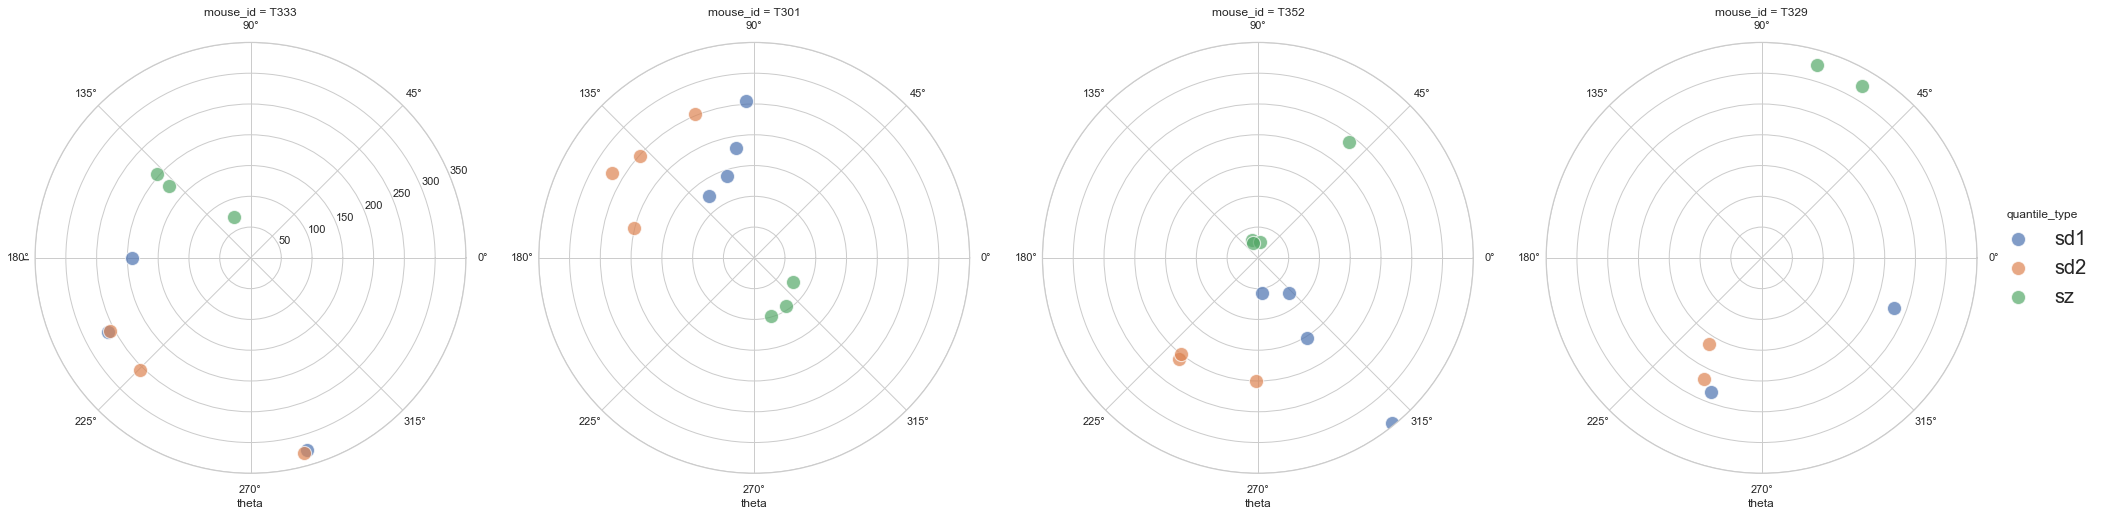

In [47]:
sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(qdf, col="mouse_id", hue="quantile_type",
                  subplot_kws=dict(projection='polar'), aspect=1, height=7,
                  sharex=True, sharey=True, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(sns.scatterplot, "theta", "r", s=200, alpha=0.7)
plt.gca().set_rlim(0, 350)

g.add_legend(fontsize=20)
plt.show()

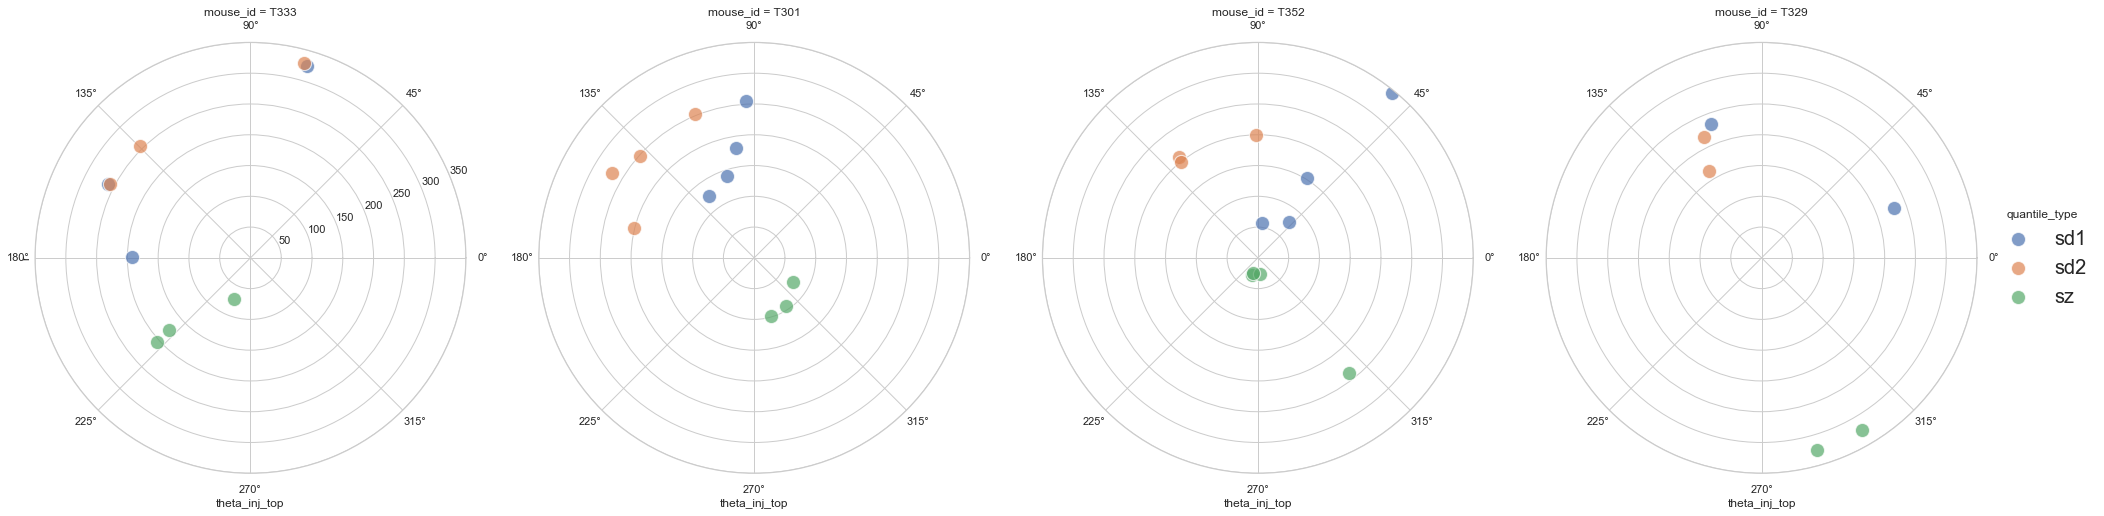

In [48]:
sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(qdf, col="mouse_id", hue="quantile_type",
                  subplot_kws=dict(projection='polar'), aspect=1, height=7,
                  sharex=True, sharey=True, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(sns.scatterplot, "theta_inj_top", "r", s=200, alpha=0.7)
plt.gca().set_rlim(0, 350)

g.add_legend(fontsize=20)
plt.show()

## Create sd-sz vectors

### Handle seizures that were split in two (sz onset in one session, sd waves in other)

In [49]:
qdf["uuid_matched"] = qdf["uuid_extended"]
# following two recordings contain 1 seizure-sd event
qdf["uuid_matched"] = qdf["uuid_matched"].replace("65bff16a4cf04930a5cb14f489a8f99b", "30dc55d1a5dc4b0286d132e72f208ca6")
# following recordings do not have sz
#qdf = qdf[qdf["uuid_matched"] != "171693d0988c458a96c8198c7b8cfc28"]

In [50]:
angles_dict = {"mouse_id": [], "uuid_matched": [], "quantile_type": [], "angle_with_sz": [], "cos_angle_with_sz": []}
angles_dict_v2 = {"mouse_id": [], "uuid_matched": [], "angle_type": [], "angle": [], "cos_angle": []} # keep backwards compatibility, but angle_with_sz is not flexible for example if want to look at sd1-sd2 angle

session_groups = qdf.groupby("uuid_matched")
for uuid, group in session_groups:
    print(uuid)
    sz_row = group[group["quantile_type"] == "sz"]
    sd1_row = group[group["quantile_type"] == "sd1"]
    sd2_row = group[group["quantile_type"] == "sd2"]
    sz_len = sz_row["r"].values[0] if len(sz_row["r"].values) > 0 else np.nan
    sd1_len = sd1_row["r"].values[0] if len(sd1_row["r"].values) > 0 else np.nan
    sd2_len = sd2_row["r"].values[0] if len(sd2_row["r"].values) > 0 else np.nan
    if len(sz_row) == 0:  # no seizure for the session
        angles_dict["mouse_id"].append(sd1_row["mouse_id"].values[0])
        angles_dict["uuid_matched"].append(uuid)
        angles_dict["quantile_type"].append("sd1")
        angles_dict["angle_with_sz"].append(np.nan)
        angles_dict["cos_angle_with_sz"].append(np.nan)

        angles_dict["mouse_id"].append(sd1_row["mouse_id"].values[0])
        angles_dict["uuid_matched"].append(uuid)
        angles_dict["quantile_type"].append("sd2")
        angles_dict["angle_with_sz"].append(np.nan)
        angles_dict["cos_angle_with_sz"].append(np.nan)

        # sz-sd1
        angles_dict_v2["mouse_id"].append(sd1_row["mouse_id"].values[0])
        angles_dict_v2["uuid_matched"].append(uuid)
        angles_dict_v2["angle_type"].append("sz-sd1")
        angles_dict_v2["angle"].append(np.nan)
        angles_dict_v2["cos_angle"].append(np.nan)
        # sz-sd2
        angles_dict_v2["mouse_id"].append(sd1_row["mouse_id"].values[0])
        angles_dict_v2["uuid_matched"].append(uuid)
        angles_dict_v2["angle_type"].append("sz-sd2")
        angles_dict_v2["angle"].append(np.nan)
        angles_dict_v2["cos_angle"].append(np.nan)    
        # sd1-sd2
        if len(sd1_row["dx"].values) > 0 and len(sd2_row["dx"].values) > 0:
            sd1_dot_sd2 = sd1_row["dx"].values[0] * sd2_row["dx"].values[0] + sd1_row["dy"].values[0] * sd2_row["dy"].values[0]
            costheta12 = sd1_dot_sd2/(sd1_len*sd2_len)
        else:
            sd1_dot_sd2 = np.nan
            costheta12 = np.nan
        angles_dict_v2["mouse_id"].append(sd1_row["mouse_id"].values[0])
        angles_dict_v2["uuid_matched"].append(uuid)
        angles_dict_v2["angle_type"].append("sd1-sd2")
        angles_dict_v2["angle"].append(acos(costheta12))
        angles_dict_v2["cos_angle"].append(costheta12) 
    else:

        # u.v = |u|*|v|*cos(theta)
        if len(sz_row["dx"].values) > 0 and len(sd1_row["dx"].values) > 0:
            sz_dot_sd1 = sz_row["dx"].values[0] * sd1_row["dx"].values[0] + sz_row["dy"].values[0] * sd1_row["dy"].values[0]
            costheta1 = sz_dot_sd1/(sz_len*sd1_len)
        else:
            sz_dot_sd1 = np.nan
            costheta1 = np.nan
        if len(sd2_row["dx"].values) > 0 and len(sd1_row["dx"].values) > 0: 
            sz_dot_sd2 = sz_row["dx"].values[0] * sd2_row["dx"].values[0] + sz_row["dy"].values[0] * sd2_row["dy"].values[0]
            costheta2 = sz_dot_sd2/(sz_len*sd2_len)
        else:
            sz_dot_sd2 = np.nan
            costheta2 = np.nan

        # add sd1-sd2 angle too
        if len(sd1_row["dx"].values) > 0 and len(sd2_row["dx"].values) > 0:
            sd1_dot_sd2 = sd1_row["dx"].values[0] * sd2_row["dx"].values[0] + sd1_row["dy"].values[0] * sd2_row["dy"].values[0]
            costheta12 = sd1_dot_sd2/(sd1_len*sd2_len)
        else:
            sd1_dot_sd2 = np.nan
            costheta12 = np.nan

        angles_dict["mouse_id"].append(sz_row["mouse_id"].values[0])
        angles_dict["uuid_matched"].append(uuid)
        angles_dict["quantile_type"].append("sd1")
        angles_dict["angle_with_sz"].append(acos(costheta1))
        angles_dict["cos_angle_with_sz"].append(costheta1)

        angles_dict["mouse_id"].append(sz_row["mouse_id"].values[0])
        angles_dict["uuid_matched"].append(uuid)
        angles_dict["quantile_type"].append("sd2")
        angles_dict["angle_with_sz"].append(acos(costheta2))
        angles_dict["cos_angle_with_sz"].append(costheta2)

        # sz-sd1
        angles_dict_v2["mouse_id"].append(sz_row["mouse_id"].values[0])
        angles_dict_v2["uuid_matched"].append(uuid)
        angles_dict_v2["angle_type"].append("sz-sd1")
        angles_dict_v2["angle"].append(acos(costheta1))
        angles_dict_v2["cos_angle"].append(costheta1)
        # sz-sd2
        angles_dict_v2["mouse_id"].append(sz_row["mouse_id"].values[0])
        angles_dict_v2["uuid_matched"].append(uuid)
        angles_dict_v2["angle_type"].append("sz-sd2")
        angles_dict_v2["angle"].append(acos(costheta2))
        angles_dict_v2["cos_angle"].append(costheta2)    
        # sd1-sd2
        angles_dict_v2["mouse_id"].append(sz_row["mouse_id"].values[0])
        angles_dict_v2["uuid_matched"].append(uuid)
        angles_dict_v2["angle_type"].append("sd1-sd2")
        angles_dict_v2["angle"].append(acos(costheta12))
        angles_dict_v2["cos_angle"].append(costheta12) 

06ebcf354f5c41519669f187e16de364
171693d0988c458a96c8198c7b8cfc28
2aa75aa234a749668eb896e7e00aa87a
30dc55d1a5dc4b0286d132e72f208ca6
4fe45b25dc854453880cd868fe77e9d4_1
4fe45b25dc854453880cd868fe77e9d4_2
5ea6fd9c4cb542dbbc1f65305725cede
73a27053f4bf4ae1b4ad96064b6dabc0
79fb974821f34e3abdcf5ca650e1c0f4
a6099849121f44ccbec237037971ab57
ae564f8c867f4f35aa971b6562c33a7c
d7a5ac8e2bc74382b3db503a6a5a07a5
e40f26d410ab452e8f8d59e5394ae0fe


In [51]:
df_angles_v2 = pd.DataFrame(angles_dict_v2)

In [52]:
df_angles = pd.DataFrame(angles_dict)

In [53]:
r_map = {"sd1": 2, "sd2": 1}  # decreasing radius order
df_angles["r_dummy"] = df_angles.apply(lambda row: r_map[row["quantile_type"]], axis=1)

In [54]:
qdf["theta_deg"] = qdf["theta"]*180./pi

In [55]:
df_angles.pivot_table(index="mouse_id",columns='r_dummy', values="angle_with_sz")

r_dummy          1         2
mouse_id                    
T301      2.702436  2.852803
T329      3.052331  2.231517
T333      1.916663  1.659724
T352      2.520406  2.587477

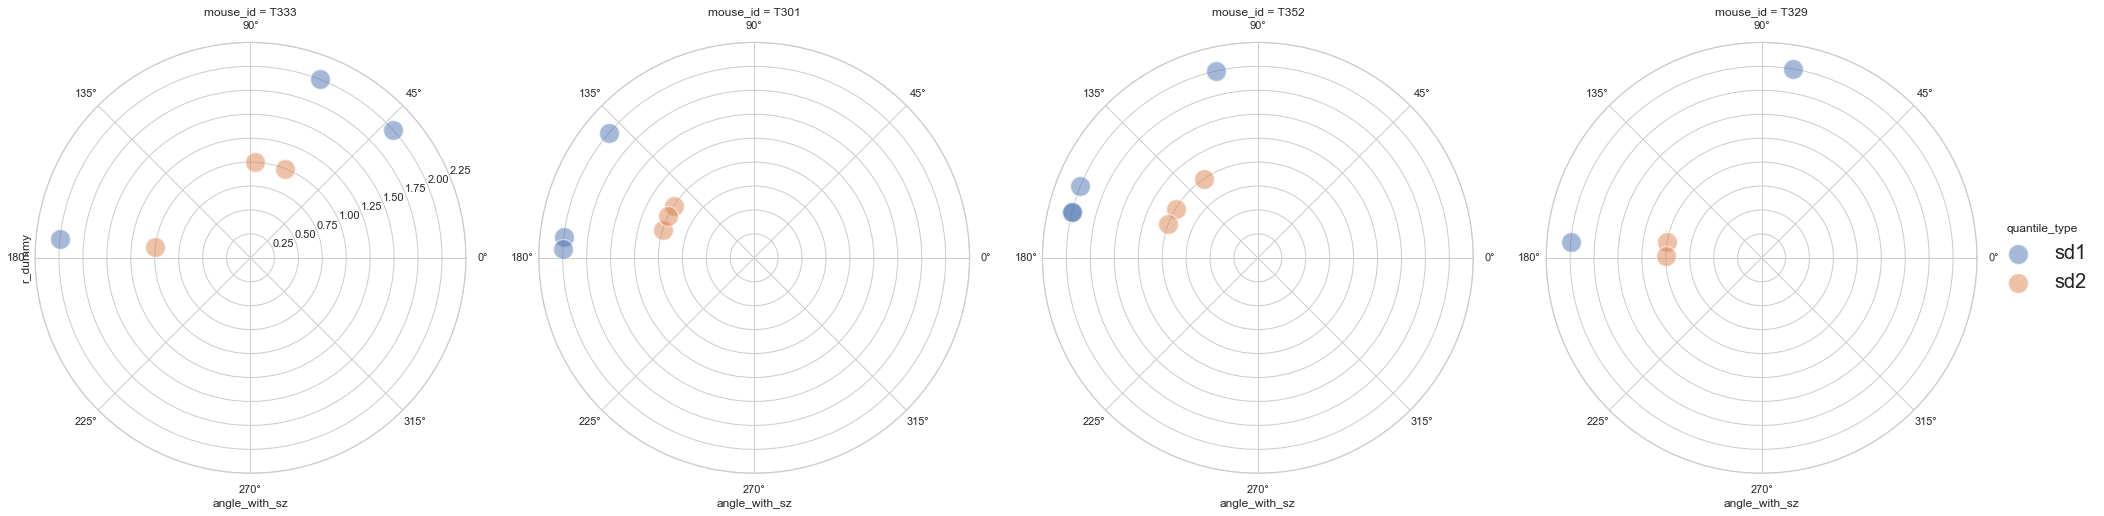

In [56]:
sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(df_angles, col="mouse_id", hue="quantile_type",
                  subplot_kws=dict(projection='polar'), aspect=1, height=7,
                  sharex=True, sharey=True, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(sns.scatterplot, "angle_with_sz", "r_dummy", s=400, alpha=0.5)
plt.gca().set_rlim(0, 2.25)


g.add_legend(fontsize=20)
plt.show()

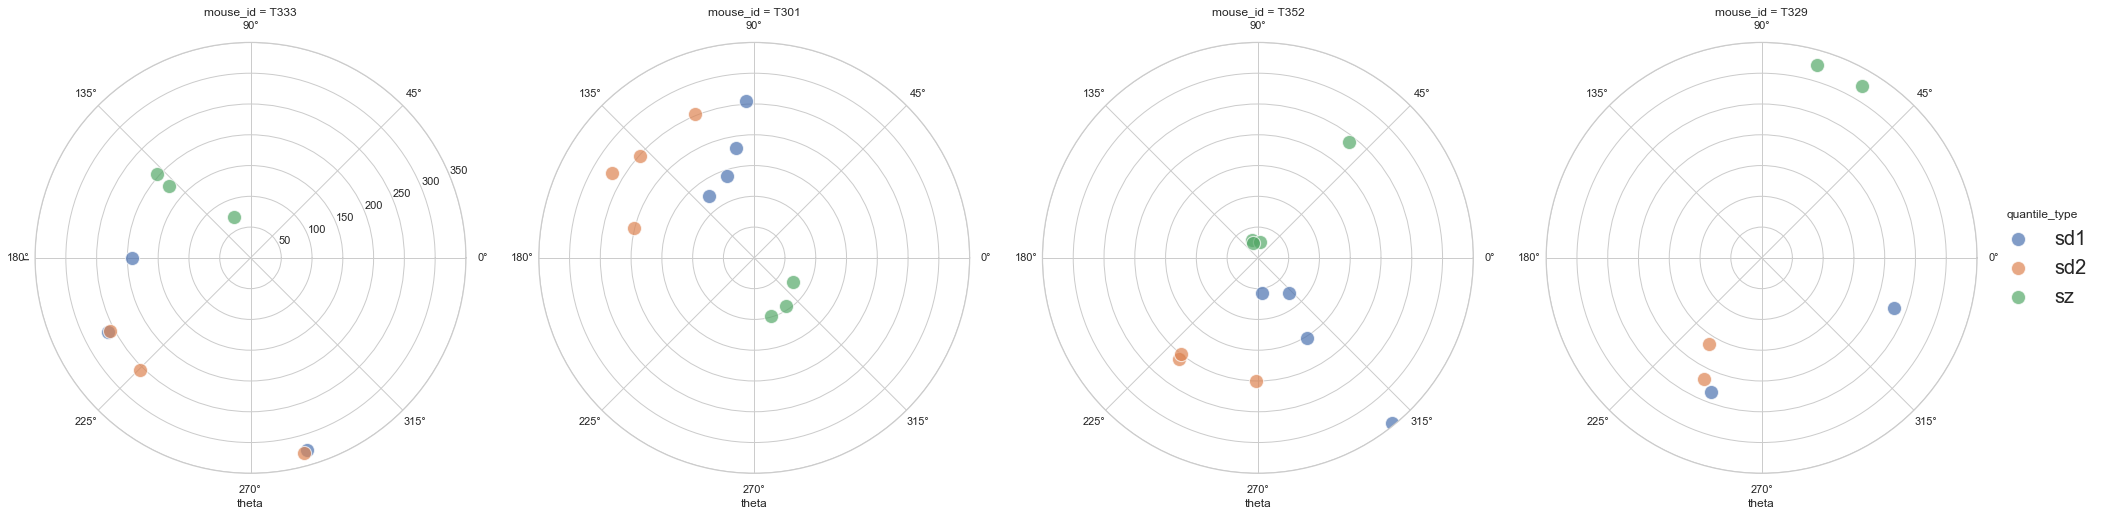

In [57]:
sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
# Set up a grid of axes with a polar projection
g = sns.FacetGrid(qdf, col="mouse_id", hue="quantile_type",
                  subplot_kws=dict(projection='polar'), aspect=1, height=7,
                  sharex=True, sharey=True, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(sns.scatterplot, "theta", "r", s=200, alpha=0.7)
plt.gca().set_rlim(0, 350)

g.add_legend(fontsize=20)
plt.show()

## Set plotting details
Color scheme, arrow widths, order of event types (sz, sd1, sd2)...

In [58]:
# create colors with hues
rgbs = []
for color in mcolors.TABLEAU_COLORS.values():
    rgbs.append(color)

In [59]:
#this color scheme does not work properly. Need to adjust v values...

# create 2d array: [color][lightness_variant]
def getColorScheme(n_shades=4):
    color_scheme = []
    for color in mcolors.TABLEAU_COLORS.values():
        h, s, v = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
        vs = np.linspace(v, 1, n_shades+1)  # first color in linspace is #000000, which will not be used
        color_row = [mcolors.to_hex(mcolors.hsv_to_rgb((h, s, v_i))) for v_i in vs[1:]]
        color_scheme.append(color_row)
    return color_scheme
#color_scheme = getColorScheme(4)
#mcolors.TABLEAU_COLORS with tints, [hue][dark to light]
color_scheme = [
    ['#1f77b4', "#258fd8", "#49a2e0", "#6db5e6", "#92c7ec", "#b6daf2"],
    ["#ff7f0e", "#ff9130", "#ffa453", "#ffb675", "#ffc898", "#ffdaba"],
    ["#2ca02c", "#35c235", "#54d054", "#76d976", "#98e398", "#baecba"],
    ["#d62728", "#dd4546", "#e36464", "#e88383", "#eea2a2", "#f4c1c1"],
    ["#9467bd", "#a37dc6", "#b392d0", "#c2a8d9", "#d1bee3", "#e0d4ec"],
    ["#8c564b", "#a7675a", "#b58176", "#c49a91", "#d3b3ad", "#e2ccc8"],
    ["#e377c2", "#e78acb", "#eb9ed3", "#efb1dc", "#f3c5e5", "#f7d8ee"]
]

In [60]:
# assign an index to each mouse. 0.0, 1.0, 2.0, ...
qdf["mouse_index"] = qdf["mouse_id"].rank(method='dense') - 1
qdf["mouse_index"] = qdf["mouse_index"].apply(int)

In [61]:
# assert enough colors are available
assert len(color_scheme) > qdf["mouse_index"].max()

In [62]:
#event_types = list(qdf.quantile_type.unique())
event_types = ["sd2", "sd1", "sz"]  # order for vector length

In [63]:
ARROW_WIDTHS = {"sd2": 12, "sd1": 6, "sz": 2}
ARROW_HEAD = 16

## Create arrow plots

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\3021625057.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)


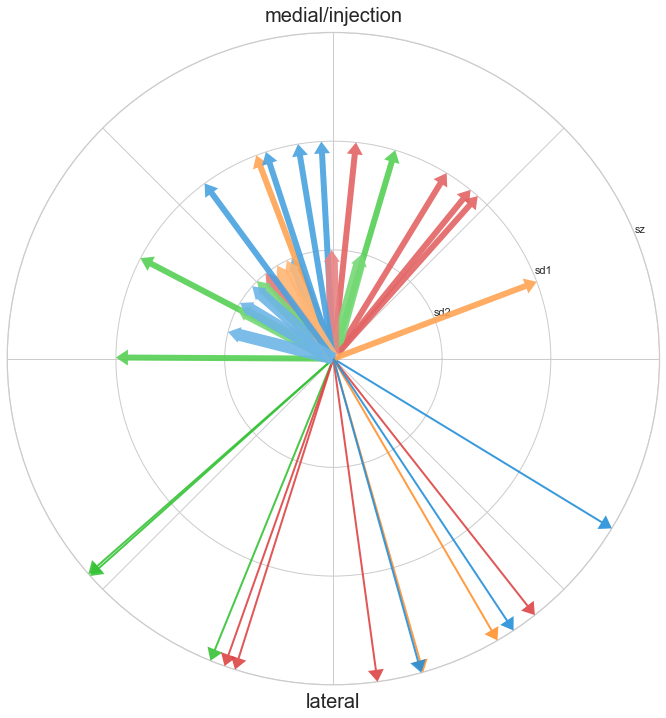

In [64]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='polar')

# plot arrows
for i, row in qdf.iterrows():
    r = event_types.index(row["quantile_type"])+1# row['r']
    theta = row['theta_inj_top']
    ax.annotate('', xy=(theta, r), xytext=(0, 0),
                arrowprops=dict(facecolor=color_scheme[int(row["mouse_index"])][len(event_types) - event_types.index(row["quantile_type"])], edgecolor='none', width=ARROW_WIDTHS[row["quantile_type"]], headwidth=ARROW_HEAD, alpha=0.9))

# set the radial limits
max_r = len(qdf["quantile_type"].unique())-1#qdf['r'].max()
ax.set_ylim(0, max_r + 1)
ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1))
ax.set_yticklabels([""] + event_types)
ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)

#ax.set_xticklabels(event_types) 
# display the plot
plt.show()

### Extract all seizure angles per mouse

In [65]:
mouse_seizures_dict = dict()
seizure_angles_groups = qdf[qdf["quantile_type"] == "sz"].groupby("mouse_id")
for mouse_id, mouse_group in seizure_angles_groups:
    mouse_seizures_dict[mouse_id] = mouse_group["theta_inj_top"].values

### Plot for each mouse separately
Directionality: do 1 for 1 mouse, all sz, one thick mean arrow, color code sessions, angles + mean angle

In [66]:
n_mice = len(qdf.mouse_id.unique())

### Define mean vectors
Two methods possible:
* Average x and y coordinates (i.e. average vectors)
* Average theta only (i.e. discard vector magnitude, equal weight for each angle)

In [67]:
qdf["costheta_inj_top"] = qdf.apply(lambda row: cos(row["theta_inj_top"]), axis=1)
qdf["sintheta_inj_top"] = qdf.apply(lambda row: sin(row["theta_inj_top"]), axis=1)

qdf["costheta"] = qdf.apply(lambda row: cos(row["theta"]), axis=1)
qdf["sintheta"] = qdf.apply(lambda row: sin(row["theta"]), axis=1)

In [68]:
#qdf = quantiles_df.groupby(["uuid_extended", "quantile_type"], as_index=False).apply(lambda group_df: group_df.assign(dx=lambda gdf: get_dx(gdf, "x"), dy=lambda gdf: get_dx(gdf, "y_mirrored")))
df_mean_vectors_per_mouse = qdf.groupby(['mouse_id', 'quantile_type'], as_index=False).mean().drop(columns=["y_mirrored", "r"])


df_sum_components = qdf[["mouse_id", "quantile_type", "dx", "dy"]].groupby(["mouse_id", "quantile_type"], as_index=False).sum()
df_sum_components["r"] = df_sum_components.apply(lambda row: sqrt(pow(row["dx"], 2) + pow(row["dy"], 2) ), axis=1)
# direction vector theta: the mean of all theta angles, i.e. unweighted average
df_mean_vectors_per_mouse["mean_dir_theta"] = df_mean_vectors_per_mouse.apply(lambda row: atan2(row["sintheta"], row["costheta"]), axis=1)
df_mean_vectors_per_mouse["mean_dir_theta_inj_top"] = df_mean_vectors_per_mouse.apply(lambda row: atan2(row["sintheta_inj_top"], row["costheta_inj_top"]), axis=1)

df_mean_vectors_per_mouse["r"] = df_mean_vectors_per_mouse.apply(lambda row: sqrt(pow(row["dx"], 2) + pow(row["dy"], 2)), axis=1)
df_mean_vectors_per_mouse["theta"] = df_mean_vectors_per_mouse.apply(lambda row: atan2(row["dy"], row["dx"]), axis=1)
df_mean_vectors_per_mouse["theta_inj_top"] = df_mean_vectors_per_mouse.apply(lambda row: sign_change_dict[ddoc.getInjectionDirection(row["mouse_id"])]*row["theta"], axis=1)


In [69]:
quantile_angles_pivot = df_mean_vectors_per_mouse.pivot_table(index="mouse_id", columns='quantile_type', values='theta_inj_top')
quantile_angles_pivot["sz-sd1"] = (quantile_angles_pivot["sz"] - quantile_angles_pivot["sd1"] + pi) % (2 * pi) - pi # convert to (-pi, pi)
quantile_angles_pivot["sz-sd2"] = (quantile_angles_pivot["sz"] - quantile_angles_pivot["sd2"] + pi) % (2 * pi) - pi # convert to (-pi, pi)
# create a pivot table for the direction angles as well
quantile_dir_angles_pivot =  df_mean_vectors_per_mouse.pivot_table(index="mouse_id", columns='quantile_type', values='mean_dir_theta_inj_top')

Helper functions to create sectors

In [70]:
def radianTo02PiRange(angle_rad):
    return (angle_rad)%(2*pi)


def getSectorsForMouse(mouse_id, mouse_index, use_dir_angles=False):
    if use_dir_angles:  # use direction angles, i.e. mean theta angles
        theta_sz = radianTo02PiRange(quantile_dir_angles_pivot.loc[mouse_id]["sz"])
        theta_sd1 = radianTo02PiRange(quantile_dir_angles_pivot.loc[mouse_id]["sd1"])
        theta_sd2 = radianTo02PiRange(quantile_dir_angles_pivot.loc[mouse_id]["sd2"])
        if mouse_id == "T352":
            print("Sectors:")
            print(theta_sd2*180.0/pi)
            print(theta_sz*180.0/pi)
            print()
    else:
        theta_sz = radianTo02PiRange(quantile_angles_pivot.loc[mouse_id]["sz"])
        theta_sd1 = radianTo02PiRange(quantile_angles_pivot.loc[mouse_id]["sd1"])
        theta_sd2 = radianTo02PiRange(quantile_angles_pivot.loc[mouse_id]["sd2"])

    # width angle: total angular region covered.
    # 1. find smaller angle between them
    theta1_min = min(theta_sz, theta_sd1)
    theta1_max = max(theta_sz, theta_sd1)
    theta2_min = min(theta_sz, theta_sd2)
    theta2_max = max(theta_sz, theta_sd2)

    dtheta_1 = theta1_max - theta1_min
    theta1_width = min(dtheta_1, 2*pi - dtheta_1)
    dtheta_2 = theta2_max - theta2_min
    theta2_width = min(dtheta_2, 2*pi - dtheta_2)

    # mid angle: between the two arrows.
    # 1. find larger angle - smaller angle difference; if > pi, should take counter-clockwise difference.
    if dtheta_1 <= pi:  # can take angle as-is
        theta1_mid = (theta_sz + theta_sd1)/2 #np.deg2rad((theta1 + theta2)/2)
    else:
        # the middle angle clockwise needs to be mirrored around the origin. Done by subtracting pi.
        theta1_mid = (theta_sz + theta_sd1)/2 - pi
    if dtheta_2 <= pi:
        theta2_mid = (theta_sz + theta_sd2)/2
    else:
        theta2_mid = (theta_sz + theta_sd2)/2 - pi
    #ax.bar(x=theta1_mid, height = 20, width=theta1_width, bottom=r0, color=color_scheme[int(row["mouse_index"])][len(event_types) - event_types.index(row["quantile_type"])])
    #r0 += 20
    #
    #r0 += 20

    # TODO: make sure sd1 and sd2 exist

    # get vector lengths for radii of sectors
    r0 = 10  # the inner perimeter of each segment will be at 10.
    r1 = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_id"] == mouse_id) & (df_mean_vectors_per_mouse["quantile_type"] == "sd1")]["r"].values[0]
    r2 = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_id"] == mouse_id) & (df_mean_vectors_per_mouse["quantile_type"] == "sd2")]["r"].values[0]
    rsz = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_id"] == mouse_id) & (df_mean_vectors_per_mouse["quantile_type"] == "sz")]["r"].values[0]

    r_padding = 6  # to make arrows visible, leave this much space between arrow point and sector perimeter
    rmax_sd1 = min(r1-r_padding, rsz-r_padding)
    rmax_sd2 = min(r2-r_padding, rsz-r_padding)
    assert rmax_sd1 > r0
    assert rmax_sd2 > r0


    # avoid same-size sectors for same mouse
    if rmax_sd1 == rmax_sd2:
        rmax_sd2 -= 20

    # calculate inner perimeter (bottom) and height for both sectors
    height1 = rmax_sd1 - r0 - r_padding
    height2 = rmax_sd2 - r0 - r_padding
    bottom1 = r0
    bottom2 = r0


    # get colors
    color1 = color_scheme[int(mouse_index)][len(event_types) - event_types.index("sd1")]
    color2 = color_scheme[int(mouse_index)][len(event_types) - event_types.index("sd2")]
    return [[theta1_mid, height1, theta1_width, bottom1, color1], [theta2_mid, height2, theta2_width, bottom2, color2]]

## All events, color-coded by sessions, for each mouse independently (categorical)

In [71]:
n_mice

4

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\443348986.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


Sectors:
116.04099409505456
271.83887501122683

[3.3848904090546226, 32.6094366492445, 2.719185989617246, 10, '#e88383']
127.93726645281791
128.6599942507628
90.91517959989302


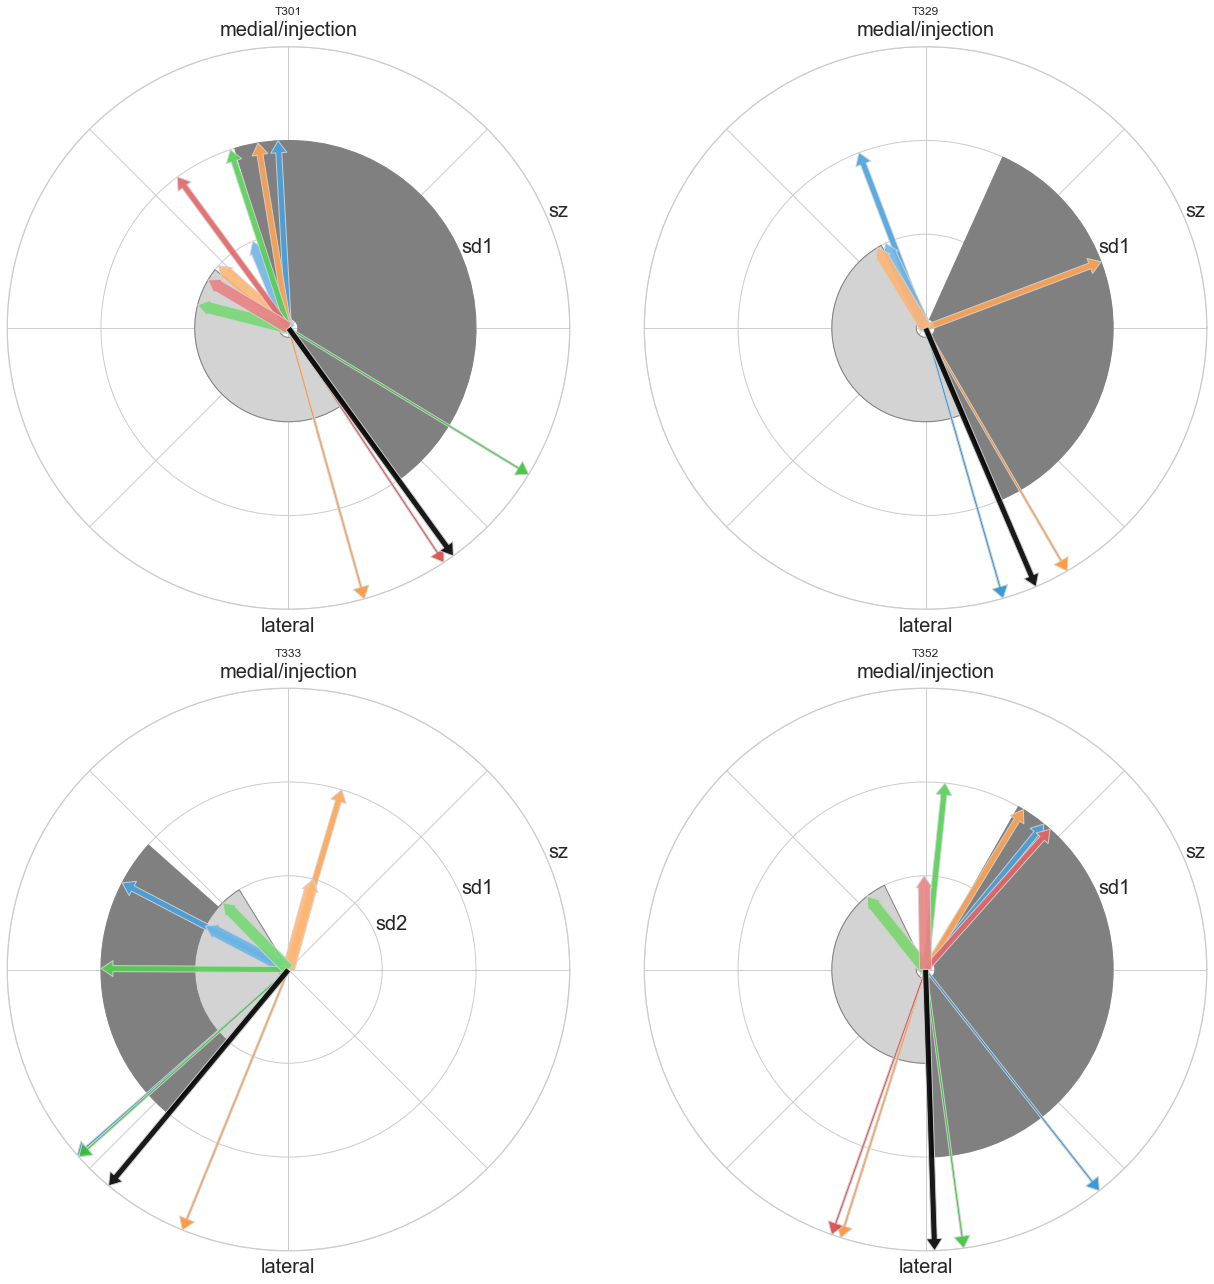

In [72]:
assert n_mice <= 4  # if >4, need to reformat the figure, say, to 3x3
fig = plt.figure(figsize=(18,18))
mice_list = []
arcs_list = []
for i_mouse in range(n_mice):
    qdf_single_mouse = qdf[qdf["mouse_index"] == i_mouse]
    theta_mean_sz = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_index"] == i_mouse) & (df_mean_vectors_per_mouse["quantile_type"] == "sz")].mean_dir_theta_inj_top.values[0]
    #theta_mean_sz = qdf[(qdf["mouse_index"] == i_mouse) & (qdf["quantile_type"] == "sz")].theta_inj_top.mean()
    mouse_id = qdf[qdf["mouse_index"] == i_mouse]["mouse_id"].unique()[0]
    
    ax = fig.add_subplot(2,2,i_mouse+1, projection='polar')
    ax.set_title(mouse_id)
    r0 = 0.1
    r_out_sd1 = event_types.index("sd1") + 0.8  # 0-indexing + 1 - 0.2 to make arrow points still visible
    r_out_sd2 = event_types.index("sd2") + 0.8

    # contains all arc properties gathered for later plotting:
    # mice_list = [<mouse_id1>, <mouse_id1>, <mouse_id2>, <mouse_id2>, ...]
    # for each mouse_id entry, there is one array in arcs_list:
    # [theta1_mid, height1, theta1_width, bottom1, color1], [theta2_mid, height2, theta2_width, bottom2, color2]
    # it is a list to be able to sort the plotting
    # TODO: create this dictionary, then loop through keys, loop through keys inside, and if exists, plot the corresponding arc.
    # TODO: change arc colors to shades of sd1 and sd2
    # TODO: change arcs to
 


    # to also plot the relative amplitudes of each vector, keep track of [theta, r] pairs. Later, plot normalized r (normalized to 3)
    length_markers_list = [[],[],[]]
    r_max = df_mean_vectors_per_mouse['r'].max()  # use r_max to normalize to 3. Longest vector will reach 3...

    sessions = qdf_single_mouse["uuid_matched"].unique().tolist()

    outline_color = "lightgrey"  # "grey" or "lightgrey" or "none"
    
    # plot arrows
    for i, row in qdf_single_mouse.iterrows():
        r = event_types.index(row["quantile_type"])+1 # length depends on type (sz, sd1, sd2)
        theta = row['theta_inj_top']
        r_original = row['r']
        # add theta and length to points list
        length_markers_list[0].append(theta)
        length_markers_list[1].append((r_original/r_max)*len(event_types))
        length_markers_list[2].append(color_scheme[int(row["mouse_index"])][0])
        ax.annotate('', xy=(theta, r), xytext=(0, 0),
                    arrowprops=dict(facecolor=color_scheme[sessions.index(row["uuid_matched"])][len(event_types) - event_types.index(row["quantile_type"])], edgecolor=outline_color, width=ARROW_WIDTHS[row["quantile_type"]], headwidth=ARROW_HEAD, alpha=0.9))
        if row["quantile_type"] == "sd2" and row["mouse_id"] == "T352":
            print(theta*180.0/pi)

        if row["mouse_id"] not in mice_list:
            # get angles as sectors. sectors[0] is sd1, sectors[1] is sd2
            sectors = getSectorsForMouse(row["mouse_id"], row["mouse_index"], use_dir_angles=True)
            mice_list.append(row["mouse_id"])
            # mean sd1 angle
            sector = sectors[0]
            ax.bar(x=sector[0], height=event_types.index("sd1")+1-r0, width=sector[2], bottom=r0, color="grey", edgecolor="grey")
            # mean sd2 angle (if present)
            if len(sectors) > 1:
                sector = sectors[1]
                if row["mouse_id"] == "T352":
                    print(sector)
                ax.bar(x=sector[0], height=event_types.index("sd2")+1 - r0, width=sector[2], bottom=r0, color="lightgrey", edgecolor="grey")
    # plot mean seizure direction arrow as last of arrows
    ax.annotate('', xy=(theta_mean_sz, 3), xytext=(0, 0),
            arrowprops=dict(facecolor="black", edgecolor=outline_color, width=ARROW_WIDTHS["sz"]+4, headwidth=ARROW_HEAD, alpha=0.9))

    #r = Rectangle((0., 0.), 100., 100, color="red")
    #p = PatchCollection([Rectangle((np.deg2rad(20), 100), 45, 50, color='blue')])
    #ax.add_collection(p)

    # set the radial limits
    max_r = len(qdf["quantile_type"].unique())-1#
    plot_length = False
    if plot_length:  # add scatter points for relative lengths
        for i_length_marker in range(len(length_markers_list[0])):
            theta = length_markers_list[0][i_length_marker]
            r = length_markers_list[1][i_length_marker]
            color = length_markers_list[2][i_length_marker]
            ax.scatter(theta, r, color=color, s=40)# color="black", s=20)

    ax.set_ylim(0, max_r + 1)
    ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1), fontsize=20)
    ax.set_yticklabels([""] + event_types)
    ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"

    
# display the plot
#plt.show()
plt.tight_layout()

### Do it for one mouse only, representatively

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\569833758.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


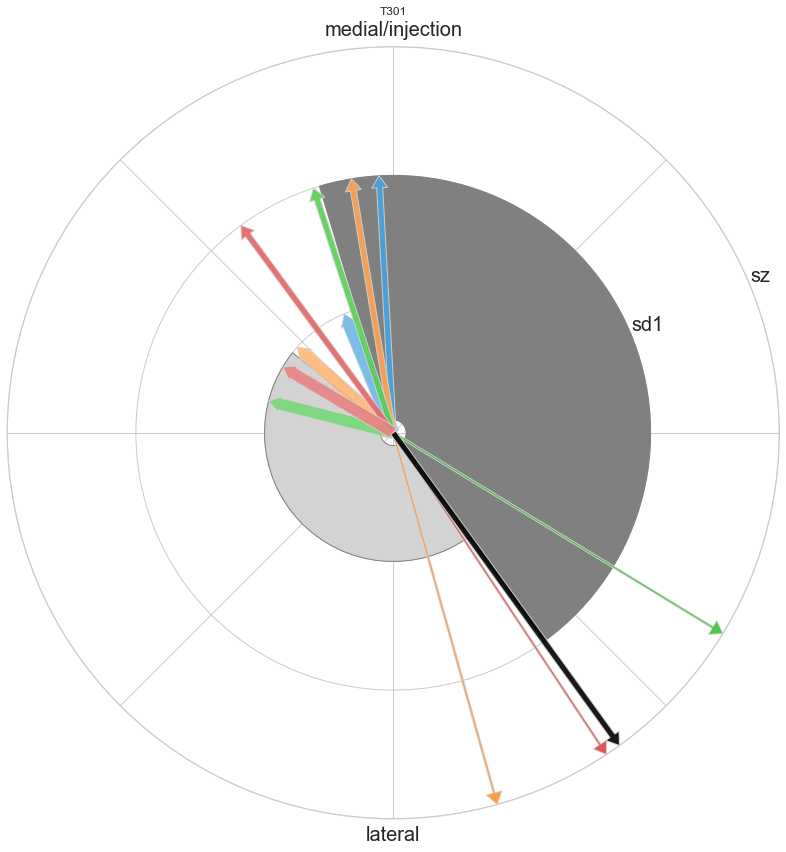

In [73]:
mouse_id = "T301"
fig = plt.figure(figsize=(12,12))
mice_list = []
arcs_list = []

qdf_single_mouse = qdf[qdf["mouse_id"] == mouse_id]
theta_mean_sz = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_id"] == mouse_id) & (df_mean_vectors_per_mouse["quantile_type"] == "sz")].mean_dir_theta_inj_top.values[0]

ax = fig.add_subplot(1,1,1, projection='polar')
ax.set_title(mouse_id)
r0 = 0.1
r_out_sd1 = event_types.index("sd1") + 0.8  # 0-indexing + 1 - 0.2 to make arrow points still visible
r_out_sd2 = event_types.index("sd2") + 0.8

# contains all arc properties gathered for later plotting:
# mice_list = [<mouse_id1>, <mouse_id1>, <mouse_id2>, <mouse_id2>, ...]
# for each mouse_id entry, there is one array in arcs_list:
# [theta1_mid, height1, theta1_width, bottom1, color1], [theta2_mid, height2, theta2_width, bottom2, color2]
# it is a list to be able to sort the plotting
# TODO: create this dictionary, then loop through keys, loop through keys inside, and if exists, plot the corresponding arc.
# TODO: change arc colors to shades of sd1 and sd2
# TODO: change arcs to



# to also plot the relative amplitudes of each vector, keep track of [theta, r] pairs. Later, plot normalized r (normalized to 3)
length_markers_list = [[],[],[]]
r_max = df_mean_vectors_per_mouse['r'].max()  # use r_max to normalize to 3. Longest vector will reach 3...

sessions = qdf_single_mouse["uuid_matched"].unique().tolist()

outline_color = "lightgrey"  # "grey" or "lightgrey" or "none"

# plot arrows
for i, row in qdf_single_mouse.iterrows():
    r = event_types.index(row["quantile_type"])+1 # length depends on type (sz, sd1, sd2)
    theta = row['theta_inj_top']
    r_original = row['r']
    # add theta and length to points list
    length_markers_list[0].append(theta)
    length_markers_list[1].append((r_original/r_max)*len(event_types))
    length_markers_list[2].append(color_scheme[int(row["mouse_index"])][0])
    ax.annotate('', xy=(theta, r), xytext=(0, 0),
                arrowprops=dict(facecolor=color_scheme[sessions.index(row["uuid_matched"])][len(event_types) - event_types.index(row["quantile_type"])], edgecolor=outline_color, width=ARROW_WIDTHS[row["quantile_type"]], headwidth=ARROW_HEAD, alpha=0.9))
    if row["quantile_type"] == "sd2" and row["mouse_id"] == "T352":
        print(theta*180.0/pi)

    if row["mouse_id"] not in mice_list:
        # get angles as sectors. sectors[0] is sd1, sectors[1] is sd2
        sectors = getSectorsForMouse(row["mouse_id"], row["mouse_index"], use_dir_angles=True)
        mice_list.append(row["mouse_id"])
        # mean sd1 angle
        sector = sectors[0]
        ax.bar(x=sector[0], height=event_types.index("sd1")+1-r0, width=sector[2], bottom=r0, color="grey", edgecolor="grey")
        # mean sd2 angle (if present)
        if len(sectors) > 1:
            sector = sectors[1]
            if row["mouse_id"] == "T352":
                print(sector)
            ax.bar(x=sector[0], height=event_types.index("sd2")+1 - r0, width=sector[2], bottom=r0, color="lightgrey", edgecolor="grey")
# plot mean seizure direction arrow as last of arrows
ax.annotate('', xy=(theta_mean_sz, 3), xytext=(0, 0),
        arrowprops=dict(facecolor="black", edgecolor=outline_color, width=ARROW_WIDTHS["sz"]+4, headwidth=ARROW_HEAD, alpha=0.9))

#r = Rectangle((0., 0.), 100., 100, color="red")
#p = PatchCollection([Rectangle((np.deg2rad(20), 100), 45, 50, color='blue')])
#ax.add_collection(p)

# set the radial limits
max_r = len(qdf["quantile_type"].unique())-1#
plot_length = False
if plot_length:  # add scatter points for relative lengths
    for i_length_marker in range(len(length_markers_list[0])):
        theta = length_markers_list[0][i_length_marker]
        r = length_markers_list[1][i_length_marker]
        color = length_markers_list[2][i_length_marker]
        ax.scatter(theta, r, color=color, s=40)# color="black", s=20)

ax.set_ylim(0, max_r + 1)
ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1), fontsize=20)
ax.set_yticklabels([""] + event_types)
ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


# display the plot
#plt.show()
plt.tight_layout()
if save_figs:
    fig_fpath = os.path.join(output_folder, f'single_mouse_directionality_{get_datetime_for_fname()}{file_format}')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")

## Plot vectors with length

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\2436642169.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


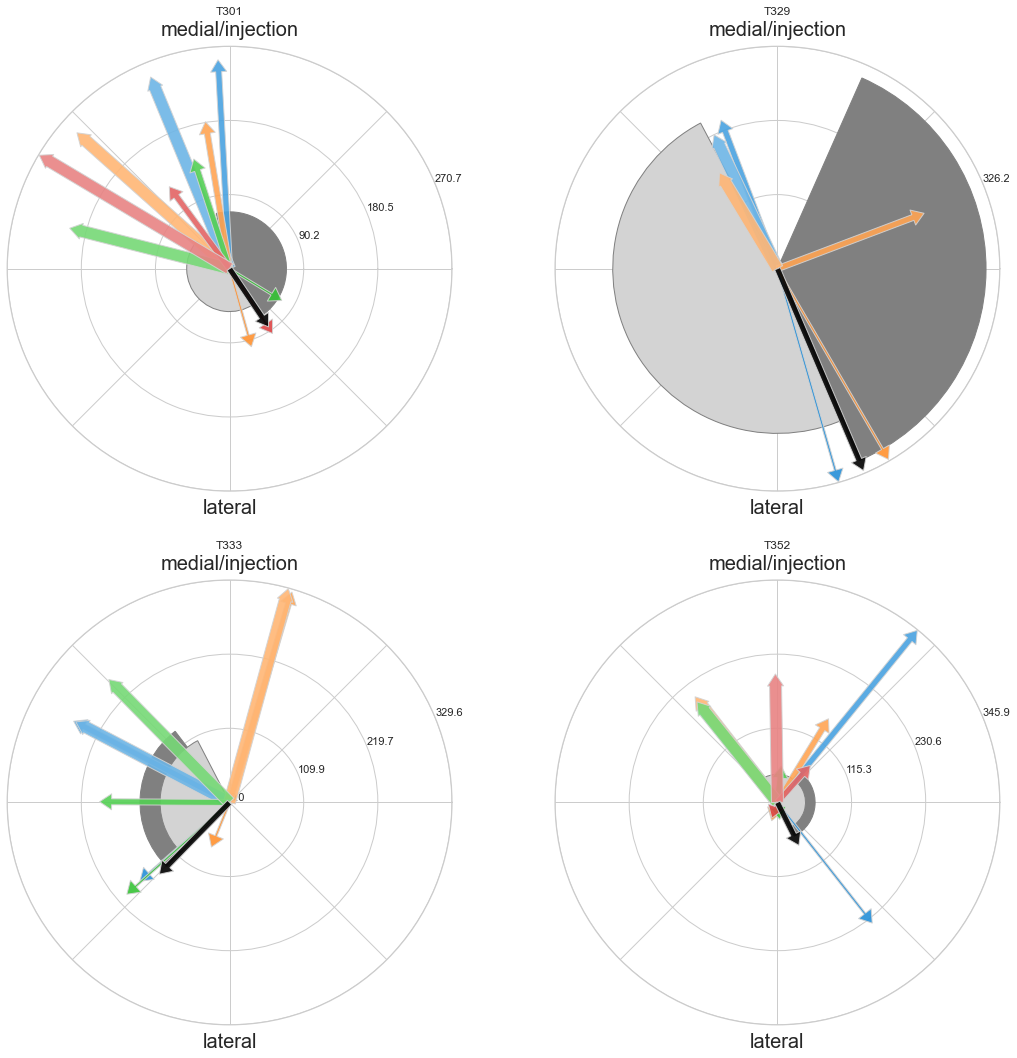

In [74]:
assert n_mice <= 4  # if >4, need to reformat the figure, say, to 3x3
fig = plt.figure(figsize=(18,18))
mice_list = []
arcs_list = []
for i_mouse in range(n_mice):
    qdf_single_mouse = qdf[qdf["mouse_index"] == i_mouse]
    theta_mean_sz = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_index"] == i_mouse) & (df_mean_vectors_per_mouse["quantile_type"] == "sz")].theta_inj_top.values[0]
    r_mean_sz = df_mean_vectors_per_mouse[(df_mean_vectors_per_mouse["mouse_index"] == i_mouse) & (df_mean_vectors_per_mouse["quantile_type"] == "sz")].r.values[0]
    
    #theta_mean_sz = qdf[(qdf["mouse_index"] == i_mouse) & (qdf["quantile_type"] == "sz")].theta_inj_top.mean()
    mouse_id = qdf[qdf["mouse_index"] == i_mouse]["mouse_id"].unique()[0]
    
    ax = fig.add_subplot(2,2,i_mouse+1, projection='polar')
    ax.set_title(mouse_id)
    r0 = 0.1
    r_out_sd1 = event_types.index("sd1") + 0.8  # 0-indexing + 1 - 0.2 to make arrow points still visible
    r_out_sd2 = event_types.index("sd2") + 0.8

    # contains all arc properties gathered for later plotting:
    # mice_list = [<mouse_id1>, <mouse_id1>, <mouse_id2>, <mouse_id2>, ...]
    # for each mouse_id entry, there is one array in arcs_list:
    # [theta1_mid, height1, theta1_width, bottom1, color1], [theta2_mid, height2, theta2_width, bottom2, color2]
    # it is a list to be able to sort the plotting
    # TODO: create this dictionary, then loop through keys, loop through keys inside, and if exists, plot the corresponding arc.
    # TODO: change arc colors to shades of sd1 and sd2
    # TODO: change arcs to
 


    # to also plot the relative amplitudes of each vector, keep track of [theta, r] pairs. Later, plot normalized r (normalized to 3)
    length_markers_list = [[],[],[]]
    r_max = df_mean_vectors_per_mouse['r'].max()  # use r_max to normalize to 3. Longest vector will reach 3...

    sessions = qdf_single_mouse["uuid_matched"].unique().tolist()

    outline_color = "lightgrey"  # "grey" or "lightgrey" or "none"
    
    # plot arrows
    for i, row in qdf_single_mouse.iterrows():
        r = row["r"]#event_types.index(row["quantile_type"])+1 # length depends on type (sz, sd1, sd2)
        theta = row['theta_inj_top']

        ax.annotate('', xy=(theta, r), xytext=(0, 0),
                    arrowprops=dict(facecolor=color_scheme[sessions.index(row["uuid_matched"])][len(event_types) - event_types.index(row["quantile_type"])], edgecolor=outline_color, width=ARROW_WIDTHS[row["quantile_type"]], headwidth=ARROW_HEAD, alpha=0.9))


        if row["mouse_id"] not in mice_list:
            # get angles as sectors. sectors[0] is sd1, sectors[1] is sd2
            sectors = getSectorsForMouse(row["mouse_id"], row["mouse_index"], use_dir_angles=False)
            mice_list.append(row["mouse_id"])
            # mean sd1 angle
            sector = sectors[0]
            ax.bar(x=sector[0], height=r_mean_sz-r0-ARROW_HEAD, width=sector[2], bottom=r0, color="grey", edgecolor="grey")
            # mean sd2 angle (if present)
            if len(sectors) > 1:
                sector = sectors[1]
                ax.bar(x=sector[0], height=0.8*r_mean_sz-r0-ARROW_HEAD, width=sector[2], bottom=r0, color="lightgrey", edgecolor="grey")
    # plot mean seizure direction arrow as last of arrows
    ax.annotate('', xy=(theta_mean_sz, r_mean_sz), xytext=(0, 0),
            arrowprops=dict(facecolor="black", edgecolor=outline_color, width=ARROW_WIDTHS["sz"]+4, headwidth=ARROW_HEAD, alpha=0.9))

    #r = Rectangle((0., 0.), 100., 100, color="red")
    #p = PatchCollection([Rectangle((np.deg2rad(20), 100), 45, 50, color='blue')])
    #ax.add_collection(p)

    # set the radial limits
    max_r = qdf_single_mouse["r"].max()#
    plot_length = False
    if plot_length:  # add scatter points for relative lengths
        for i_length_marker in range(len(length_markers_list[0])):
            theta = length_markers_list[0][i_length_marker]
            r = length_markers_list[1][i_length_marker]
            color = length_markers_list[2][i_length_marker]
            ax.scatter(theta, r, color=color, s=40)# color="black", s=20)

    ax.set_ylim(0, max_r + 1)
    ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1))
    #ax.set_yticklabels([""] + event_types)
    ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"

    
# display the plot
plt.show()

### Test cosine similarity

In [75]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
# group by mouse and by event type
vectors_df = qdf[["mouse_index", "mouse_id", "uuid_matched", "quantile_type", "dx", "dy"]]

In [76]:
# group by "id" and calculate similarity matrix for each group
cos_similarity_matrices = {mouse_id: {} for mouse_id in vectors_df.mouse_id.unique()}
for group_id_event_type, group_df in vectors_df.groupby(['mouse_id', "quantile_type"]):
    x = group_df['dx'].values
    y = group_df['dy'].values
    
    mouse_id, event_type = group_id_event_type
    
    # calculate similarity matrix using cosine similarity
    vectors = np.stack((x, y), axis=1)
    similarity_matrix = cosine_similarity(vectors)
    
    cos_similarity_matrices[mouse_id][event_type] = similarity_matrix

### Get span of seizure theta angles for all mice

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\860077813.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


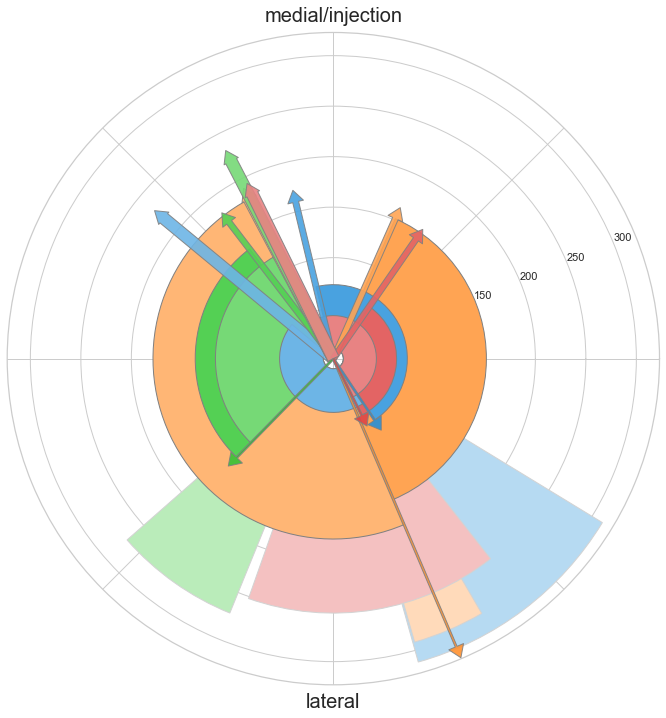

In [77]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='polar')
# contains all arc properties gathered for later plotting:
# mice_list = [<mouse_id1>, <mouse_id1>, <mouse_id2>, <mouse_id2>, ...]
# for each mouse_id entry, there is one array in arcs_list:
# [theta1_mid, height1, theta1_width, bottom1, color1], [theta2_mid, height2, theta2_width, bottom2, color2]
# it is a list to be able to sort the plotting
# TODO: create this dictionary, then loop through keys, loop through keys inside, and if exists, plot the corresponding arc.
# TODO: change arc colors to shades of sd1 and sd2
# TODO: change arcs to
mice_list = []
arcs_list = [] 



# plot arrows
for i, row in df_mean_vectors_per_mouse.iterrows():
    r = row['r']#event_types.index(row["quantile_type"])+1# 
    theta = row['theta_inj_top']
    ax.annotate('', xy=(theta, r), xytext=(0, 0),
                arrowprops=dict(facecolor=color_scheme[int(row["mouse_index"])][len(event_types) - event_types.index(row["quantile_type"])], edgecolor='grey', width=ARROW_WIDTHS[row["quantile_type"]], headwidth=ARROW_HEAD, alpha=0.9))
    if row["mouse_id"] not in mice_list:  # avoid adding sectors for the same mouse again
        sectors = getSectorsForMouse(row["mouse_id"], row["mouse_index"])
        
        # add data to list
        mice_list.append(row["mouse_id"])
        arcs_list.append(sectors[0]) #[row["mouse_id"]] = arc_data
        mice_list.append(row["mouse_id"])
        arcs_list.append(sectors[1])

    
        
# plot light clored sectors that span all seizures per mouse
r_max = df_mean_vectors_per_mouse[ (df_mean_vectors_per_mouse["quantile_type"] == "sz")]["r"].max()
for i_mouse in range(0, len(mice_list), 2):
    mouse_id = mice_list[i_mouse]
    mouse_index = i_mouse//2
    theta_min = mouse_seizures_dict[mouse_id].min()
    theta_max = mouse_seizures_dict[mouse_id].max()
    width=radianTo02PiRange(theta_max - theta_min)
    r_min = 20
    color = color_scheme[mouse_index][-1]
    ax.bar(x=(theta_max+theta_min)/2.0, height=r_max - r_min - (i_mouse+1)*10, width=width, bottom=r_min, color=color, edgecolor="lightgrey" )
        

# sort by descending outer perimeter so all of them visible by plotting smaller on top of larger sectors
for sector in sorted(arcs_list, key=lambda row: row[1], reverse=True):
    ax.bar(x=sector[0], height=sector[1], width=sector[2], bottom=sector[3], color=sector[4], edgecolor="grey")

        
#r = Rectangle((0., 0.), 100., 100, color="red")
#p = PatchCollection([Rectangle((np.deg2rad(20), 100), 45, 50, color='blue')])
#ax.add_collection(p)

# set the radial limits
max_r = df_mean_vectors_per_mouse['r'].max() #len(qdf["quantile_type"].unique())-1#
ax.set_ylim(0, max_r + 1)
#ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1))
#ax.set_yticklabels([""] + event_types)
ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"

#ax.set_xticklabels(event_types) 
# display the plot
plt.show()

In [78]:
# TODO: length of vectors should still somehow correspond to average... If length is small, the direction might be insignificant

In [79]:
# TODO: use circular heatmap or roseplot!

In [80]:
# TODO: mark the angles between average vectors (sz-sd1, sz-sd2) for each mouse

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\1808853025.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


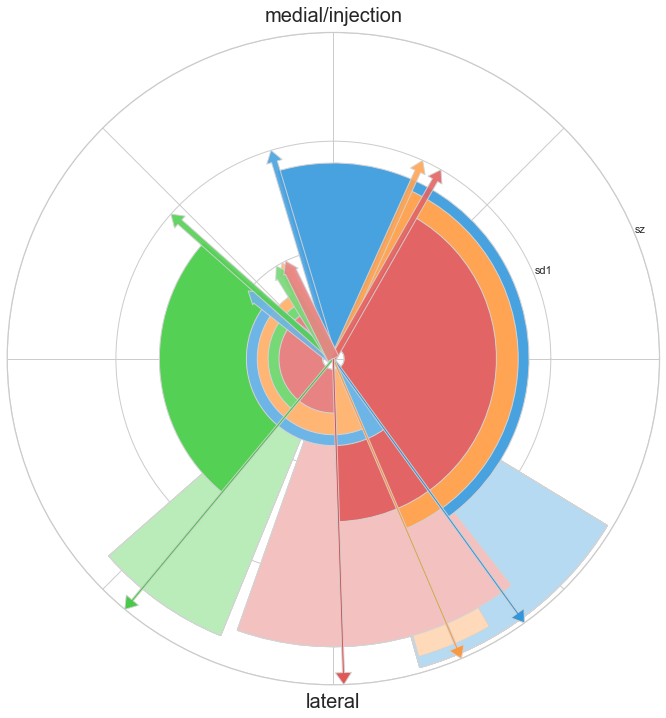

In [81]:
dir_means = True  # use mean direction? (mean theta vs x, y mean components i.e. mean vector)


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='polar')
r0 = 0.1
r_out_sd1 = event_types.index("sd1") + 0.8  # 0-indexing + 1 - 0.2 to make arrow points still visible
r_out_sd2 = event_types.index("sd2") + 0.8

# contains all arc properties gathered for later plotting:
# mice_list = [<mouse_id1>, <mouse_id1>, <mouse_id2>, <mouse_id2>, ...]
# for each mouse_id entry, there is one array in arcs_list:
# [theta1_mid, height1, theta1_width, bottom1, color1], [theta2_mid, height2, theta2_width, bottom2, color2]
# it is a list to be able to sort the plotting
# TODO: create this dictionary, then loop through keys, loop through keys inside, and if exists, plot the corresponding arc.
# TODO: change arc colors to shades of sd1 and sd2
# TODO: change arcs to
mice_list = []
arcs_list = [] 


# to also plot the relative amplitudes of each vector, keep track of [theta, r] pairs. Later, plot normalized r (normalized to 3)
length_markers_list = [[],[],[]]
r_max = df_mean_vectors_per_mouse['r'].max()  # use r_max to normalize to 3. Longest vector will reach 3...


def radianTo02PiRange(angle_rad):
    return (angle_rad)%(2*pi)

outline_color = "lightgrey"  # "grey" or "lightgrey" or "none"

# plot arrows
for i, row in df_mean_vectors_per_mouse.iterrows():
    r = event_types.index(row["quantile_type"])+1 # length depends on type (sz, sd1, sd2)
    if dir_means:
        theta = row["mean_dir_theta_inj_top"]
    else:
        theta = row['theta_inj_top']
    r_original = row['r']
    # add theta and length to points list
    length_markers_list[0].append(theta)
    length_markers_list[1].append((r_original/r_max)*len(event_types))
    length_markers_list[2].append(color_scheme[int(row["mouse_index"])][0])
    
    ax.annotate('', xy=(theta, r), xytext=(0, 0),
                arrowprops=dict(facecolor=color_scheme[int(row["mouse_index"])][len(event_types) - event_types.index(row["quantile_type"])], edgecolor=outline_color, width=ARROW_WIDTHS[row["quantile_type"]], headwidth=ARROW_HEAD, alpha=0.9))
    
    
    if row["mouse_id"] not in mice_list:
        if dir_means:
            theta_sz = radianTo02PiRange(quantile_dir_angles_pivot.loc[row["mouse_id"]]["sz"])
            theta_sd1 = radianTo02PiRange(quantile_dir_angles_pivot.loc[row["mouse_id"]]["sd1"])
            theta_sd2 = radianTo02PiRange(quantile_dir_angles_pivot.loc[row["mouse_id"]]["sd2"])           
        else:
            theta_sz = radianTo02PiRange(quantile_angles_pivot.loc[row["mouse_id"]]["sz"])
            theta_sd1 = radianTo02PiRange(quantile_angles_pivot.loc[row["mouse_id"]]["sd1"])
            theta_sd2 = radianTo02PiRange(quantile_angles_pivot.loc[row["mouse_id"]]["sd2"])
        
        # width angle: total angular region covered.
        # 1. find smaller angle between them
        theta1_min = min(theta_sz, theta_sd1)
        theta1_max = max(theta_sz, theta_sd1)
        theta2_min = min(theta_sz, theta_sd2)
        theta2_max = max(theta_sz, theta_sd2)
        
        dtheta_1 = theta1_max - theta1_min
        theta1_width = min(dtheta_1, 2*pi - dtheta_1)
        dtheta_2 = theta2_max - theta2_min
        theta2_width = min(dtheta_2, 2*pi - dtheta_2)
        
        # mid angle: between the two arrows.
        # 1. find larger angle - smaller angle difference; if > pi, should take counter-clockwise difference.
        if theta1_max - theta1_min <= pi:  # can take angle as-is
            theta1_mid = (theta_sz + theta_sd1)/2 #np.deg2rad((theta1 + theta2)/2)
        else:
            # the middle angle clockwise needs to be mirrored around the origin. Done by subtracting pi.
            theta1_mid = (theta_sz + theta_sd1)/2 - pi
        if theta2_max - theta2_min <= pi:
            theta2_mid = (theta_sz + theta_sd2)/2
        else:
            theta2_mid = (theta_sz + theta_sd2)/2 - pi
        
        # calculate inner perimeter (bottom) and height for both sectors
        height1 = r_out_sd1 - r0
        height2 = r_out_sd2 - r0
        bottom1 = r0
        bottom2 = r0
        
        
        # get colors
        color1 = color_scheme[int(row["mouse_index"])][len(event_types) - event_types.index("sd1")]
        color2 = color_scheme[int(row["mouse_index"])][len(event_types) - event_types.index("sd2")]
        
        # add data to list
        mice_list.append(row["mouse_id"])
        arcs_list.append([theta1_mid, height1, theta1_width, bottom1, color1]) #[row["mouse_id"]] = arc_data
        mice_list.append(row["mouse_id"])
        arcs_list.append([theta2_mid, height2, theta2_width, bottom2, color2])
        
        r_out_sd1 -= 0.1
        r_out_sd2 -= 0.1
        
    # plot light clored sectors that span all seizures per mouse
    r_max = event_types.index("sz")+1
    for i_mouse in range(0, len(mice_list), 2):
        mouse_id = mice_list[i_mouse]
        mouse_index = i_mouse//2
        theta_min = mouse_seizures_dict[mouse_id].min()
        theta_max = mouse_seizures_dict[mouse_id].max()
        width=radianTo02PiRange(theta_max - theta_min)
        r_min = 0.2
        color = color_scheme[mouse_index][-1]
        ax.bar(x=(theta_max+theta_min)/2.0, height=r_max - r_min - (i_mouse+1)*0.05, width=width, bottom=r_min, color=color, edgecolor="lightgrey" )

        

# sort by descending outer perimeter so all of them visible by plotting smaller on top of larger sectors
for sector in sorted(arcs_list, key=lambda row: row[1], reverse=True):
    ax.bar(x=sector[0], height=sector[1], width=sector[2], bottom=sector[3], color=sector[4], edgecolor=outline_color)


#r = Rectangle((0., 0.), 100., 100, color="red")
#p = PatchCollection([Rectangle((np.deg2rad(20), 100), 45, 50, color='blue')])
#ax.add_collection(p)

# set the radial limits
max_r = len(qdf["quantile_type"].unique())-1#
plot_length = False
if plot_length:  # add scatter points for relative lengths
    for i_length_marker in range(len(length_markers_list[0])):
        theta = length_markers_list[0][i_length_marker]
        r = length_markers_list[1][i_length_marker]
        color = length_markers_list[2][i_length_marker]
        ax.scatter(theta, r, color=color, s=40)# color="black", s=20)
    
ax.set_ylim(0, max_r + 1)
ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1))
ax.set_yticklabels([""] + event_types)
ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"

    
# display the plot
plt.show()

### Get sectors for all recordings individually

In [82]:
pt = qdf.pivot_table(index=["uuid_matched", "mouse_id", "mouse_index"], columns=["quantile_type"], values=["theta_inj_top", "r"]).sort_values(by=["mouse_id"])
pt.loc["06ebcf354f5c41519669f187e16de364"].index.values[0]

('T333', 2)

In [83]:
def getSectorAnglesForVectors(theta1, theta2, force_direction=False, direction="ccw"):
    # direction: cw for clockwise, ccw for counter-clockwise
    dtheta = abs(theta1 - theta2)
    if force_direction:
        if direction == "ccw":
            # to make only counter-clockwise sectors (from theta1 to theta2):
            #  0. the width does not change, no matter in what interval the two angles are defined
            theta_width = (theta2 - theta1)%(2*pi)
            #  1. bring them to a form where theta2 > theta1
            theta2_adjusted = (theta2)%(2*pi)
            theta1_adjusted = (theta1)%(2*pi)
            if theta2_adjusted < theta1_adjusted:  # need to swap to (-pi, pi) range
                theta2_adjusted = (theta2_adjusted - pi)%(2*pi)
                theta1_adjusted = (theta1_adjusted - pi)%(2*pi)
            theta_mid= ((theta1 + theta2)/2)%(2*pi)
        elif direction == "cw":
            # clockwise sectors from theta1 to theta2. This means the signs are reversed
            # bring the angles to a range where theta2 < theta1. Try (0, 2pi) and (-pi, pi)
            theta2_adjusted = (theta2)%(2*pi)
            theta1_adjusted = (theta1)%(2*pi)
            if theta2_adjusted > theta1_adjusted:  # need to swap to (-pi, pi) range
                theta2_adjusted = (theta2_adjusted - pi)%(2*pi)
                theta1_adjusted = (theta1_adjusted - pi)%(2*pi)
            theta_width = (theta1_adjusted - theta2_adjusted)%(2*pi)
            theta_mid= ((theta1_adjusted + theta2_adjusted)/2)%(2*pi)
    else:  # find smaller angle for sectors
        theta_width = min(dtheta, 2*pi - dtheta)
        if dtheta <= pi:  # can take angle as-is
            theta_mid= (theta1 + theta2)/2 #np.deg2rad((theta1 + theta2)/2)
        else:
            # the middle angle clockwise needs to be mirrored around the origin. Done by subtracting pi.
            theta_mid = (theta1 + theta2)/2 - pi
    return (theta_mid, theta_width)



C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\3863375005.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"


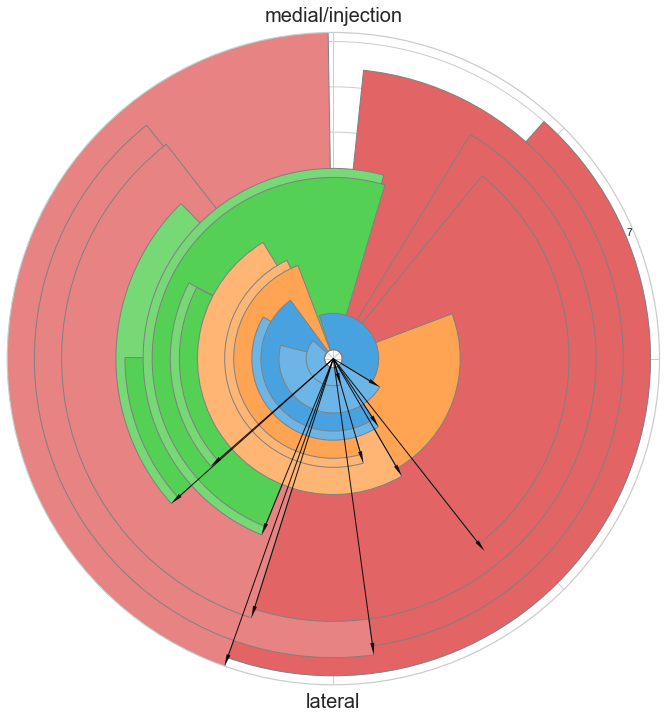

In [84]:
sectors = []  # list of [theta_mid, height, theta_width, bottom, color]
seizure_indicators = []  # list of (theta, r_max = height + r_0, color)
r_0 = 0.2
r_top = 0.4
for indices, row in pt.iterrows(): # (uuid_matched, mouse_id, mouse_index), df[theta_inj_top/r][sz/sd1/sd2]
    # get one or two sectors 
    # get sd1
    if np.isnan(row["theta_inj_top"]["sz"]):
        continue
    theta_mid, theta_width = getSectorAnglesForVectors(row["theta_inj_top"]["sz"], row["theta_inj_top"]["sd1"], False, "ccw")
    color = color_scheme[indices[2]][len(event_types) - event_types.index("sd1")]
    height = r_top - r_0
    sectors.append([theta_mid, height, theta_width, r_0, color])
    r_top += 0.2    
    # get sd2 (if exists)
    if not np.isnan(row["theta_inj_top"]["sd2"]):
        theta_mid, theta_width = getSectorAnglesForVectors(row["theta_inj_top"]["sz"], row["theta_inj_top"]["sd2"], False, "ccw")
        color = color_scheme[indices[2]][len(event_types) - event_types.index("sd2")]
        height = r_top - r_0
        sectors.append([theta_mid, height, theta_width, r_0, color])
    # get seizure direction for showing as line
    color = color_scheme[indices[2]][len(event_types) - event_types.index("sz")]
    seizure_indicators.append((row["theta_inj_top"]["sz"], r_top, color))
    r_top += 0.4
    


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='polar')

# sort by descending outer perimeter so all of them visible by plotting smaller on top of larger sectors
i_sector = len(sectors) -1
while i_sector > 0:
    sector = sectors[i_sector]
    ax.bar(x=sector[0], height=sector[1], width=sector[2], bottom=sector[3], color=sector[4], edgecolor="grey")
    i_sector -= 1
# seizure direction
for sz_ind in seizure_indicators:
    ax.annotate('', xy=(sz_ind[0], sz_ind[1]), xytext=(0, 0),
            arrowprops=dict(facecolor="black", edgecolor='none', width=1, headwidth=4, alpha=0.9))
# set the radial limits
max_r = sectors[-1][1] + sectors[-1][3]

ax.set_ylim(0, max_r)
#ax.set_rgrids(np.linspace(0, max_r+1, num=len(event_types)+1))
#ax.set_yticklabels([""] + event_types)
ax.set_xticklabels(['', '', 'medial/injection', '', '', '', 'lateral', ''], fontsize=20)  # top direction should be "medial/injection"

    
# display the plot
plt.show()

# Change seaborn parameters

## Bar plot angles

In [85]:
df_angles_v2 = pd.DataFrame(angles_dict_v2)  # this dict contains sd1-sd2 angles too
df_angles_v2["angle_deg"] = df_angles_v2["angle"].apply(lambda rad: 360.*rad/(2*pi))

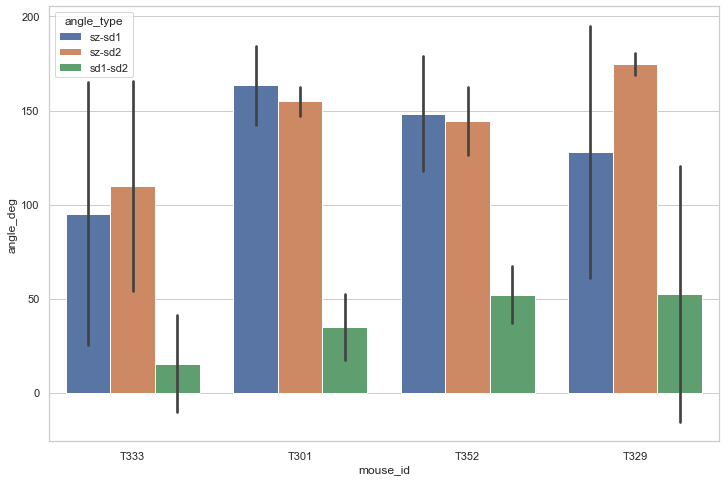

In [86]:
fig = plt.figure(figsize=(12,8))
sns.barplot(data=df_angles_v2, x="mouse_id", y="angle_deg", hue="angle_type", errorbar="sd")
plt.show()

### Try semi-circular plotting

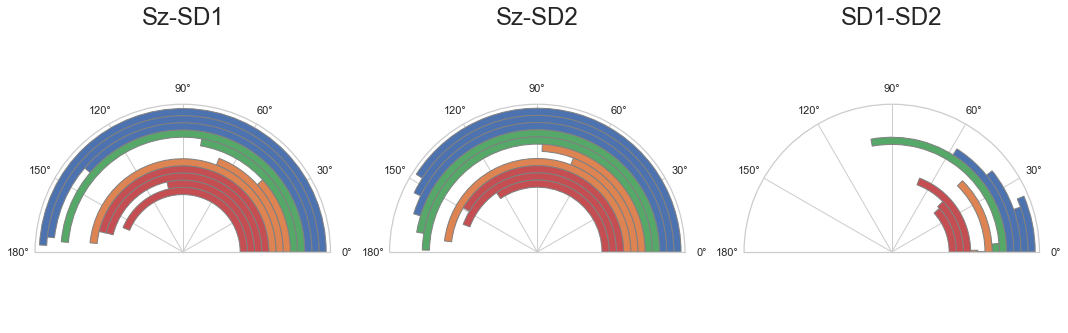

In [87]:
angle_colors = {"sz-sd1" : "blue", "sz-sd2" : "lightgreen", "sd1-sd2": "yellow"}
#mouse_colors = {"T301" : "blue", "T333" : "green", "T329" : "red", "T352" : "orange"}
mouse_colors = {"T301": color_palette[0], "T333": color_palette[1], "T329": color_palette[2], "T352": color_palette[3]}
bar_height=20
r0 = 100

fig = plt.figure(figsize=(18,12))
ax_szsd1 = fig.add_subplot(131, projection='polar')
ax_szsd2 = fig.add_subplot(132, projection='polar')
ax_sd1sd2 = fig.add_subplot(133, projection='polar')
ax_szsd1.set_title("Sz-SD1", fontsize=24)
ax_szsd2.set_title("Sz-SD2", fontsize=24)
ax_sd1sd2.set_title("SD1-SD2", fontsize=24)

ax_dict = {"sz-sd1" : ax_szsd1, "sz-sd2" : ax_szsd2, "sd1-sd2" : ax_sd1sd2}
r_dict = {"sz-sd1" : 400, "sz-sd2" : 400, "sd1-sd2"  : 400}

for i_row, row in df_angles_v2.sort_values(by="mouse_id").dropna().iterrows():
    angle = row["angle"]
    mid_angle = angle/2.
    ax_choice = ax_dict[row["angle_type"]]
    ax_choice.bar(x=mid_angle, height=bar_height, width=angle, bottom=r_dict[row["angle_type"]]-bar_height, color=mouse_colors[row["mouse_id"]], edgecolor="grey")
    r_dict[row["angle_type"]] -=bar_height

ax_szsd1.axis(xmin=0.,xmax=math.pi)
ax_szsd2.axis(xmin=0.,xmax=math.pi)
ax_sd1sd2.axis(xmin=0.,xmax=math.pi)    
ax_szsd1.axes.get_yaxis().set_visible(False)
ax_szsd2.axes.get_yaxis().set_visible(False)
ax_sd1sd2.axes.get_yaxis().set_visible(False)  
    
if save_figs:
    fig_fpath = os.path.join(output_folder, f'relative_angles_all_mice_{get_datetime_for_fname()}{file_format}')
    plt.savefig(fig_fpath, format=file_format.split(".")[-1])
    print(f"Saved to {fig_fpath}")
plt.show()

### Plot per mouse, per angle type the mean + SD

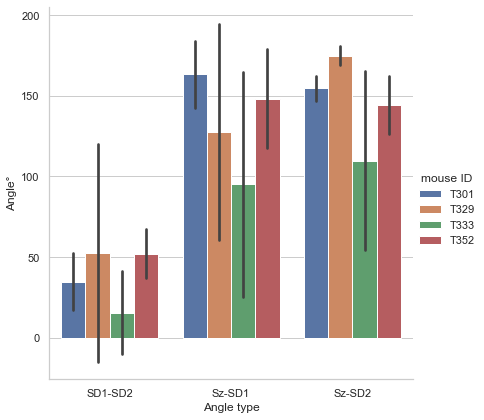

In [88]:
#sns.catplot(
#    data=df_angles_v2.groupby(["mouse_id", "angle_type"]).mean().reset_index(), kind="bar",
#    x="angle_type", y="angle_deg", hue="mouse_id",
#    errorbar="se", palette="dark", alpha=.6, height=6
#)
#fig = plt.figure(figsize=(18,18))
# need to sort by mouse ID to match color coding with other plots (circular bar plot, for example)
sns.catplot(data=df_angles_v2.replace({"sz-sd1":"Sz-SD1", "sz-sd2":"Sz-SD2", "sd1-sd2":"SD1-SD2"}).rename(columns={"mouse_id":"mouse ID"}).sort_values(by="mouse ID"), kind="bar", x="angle_type", y="angle_deg", hue="mouse ID", palette=color_palette, errorbar="sd",height=6)
plt.xlabel('Angle type')
plt.ylabel('Angle°')
if save_figs:
    out_fpath = os.path.join(env_dict["DOWNLOADS_FOLDER"], f"relative_angles_barplot_SD_{get_datetime_for_fname()}{file_format}")
    plt.savefig(out_fpath,bbox_inches='tight', dpi=300)
    print(f"Saved as {out_fpath}")
plt.show()

### Plot angles grouped by angle type only

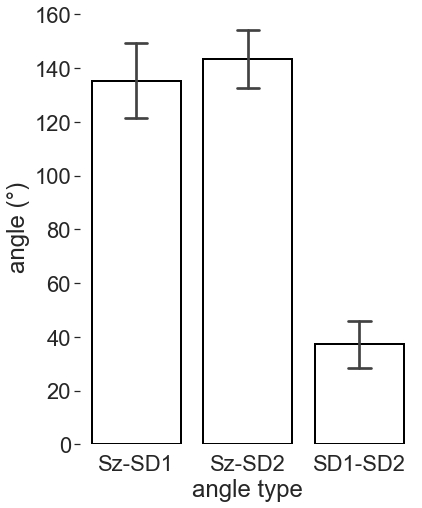

In [89]:
sns.set(font_scale = 2)
sns.set_style("white")
fig = plt.figure(figsize=(6,8))
#sns.set_context(rc = {'patch.linewidth': 1.0})
sns.barplot(data=df_angles_v2.replace({"sz-sd1":"Sz-SD1", "sz-sd2":"Sz-SD2", "sd1-sd2":"SD1-SD2"}).rename(columns={"mouse_id":"mouse ID"}).sort_values(by="mouse ID"), 
            x="angle_type", y="angle_deg", 
            order=["Sz-SD1", "Sz-SD2", "SD1-SD2"],
            errorbar="se", fill=False, color="lightgrey", 
            capsize=.2,)
ax = plt.gca()
plt.setp(ax.patches, linewidth=2.0, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(left=True, bottom=False)
ax.spines['left'].set_visible(False)
plt.xlabel('angle type')
plt.ylabel('angle (°)')

if save_figs:
    fig_fpath = os.path.join(output_folder, f'barplot_all_mean_plus_SEM_per_angle_type_{get_datetime_for_fname()}{file_format}')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

## Combine semicircle barplot with barplot

### Plot per-mouse means, mean + SEM

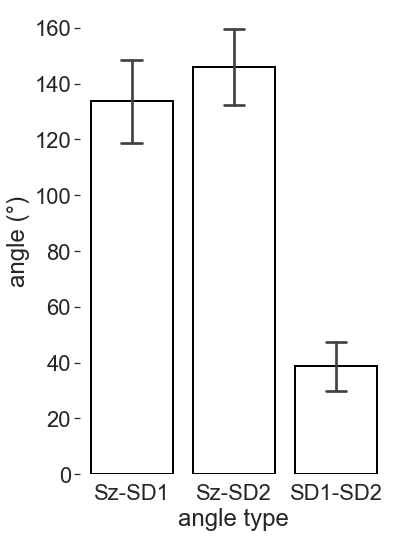

In [90]:
# single data point = within-mouse average
df_angles_mean_per_mouse = df_angles_v2.replace({"sz-sd1":"Sz-SD1", "sz-sd2":"Sz-SD2", "sd1-sd2":"SD1-SD2"}).rename(columns={"mouse_id":"mouse ID"}).sort_values(by="mouse ID").groupby(["mouse ID", "angle_type"]).apply(lambda g: g["angle_deg"].mean())
df_angles_mean_per_mouse = pd.DataFrame(df_angles_mean_per_mouse, columns=["mean_angle_deg"]).reset_index()


fig = plt.figure(figsize=(6,8))
sns.barplot(data=df_angles_mean_per_mouse, 
            x="angle_type", y="mean_angle_deg", 
            order=["Sz-SD1", "Sz-SD2", "SD1-SD2"],
            errorbar="se", fill=False, color="lightgrey", 
            capsize=.2,)


ax = plt.gca()
plt.setp(ax.patches, linewidth=2.0, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(left=True, bottom=False)
ax.spines['left'].set_visible(False)
plt.xlabel('angle type')
plt.ylabel('angle (°)')
plt.tight_layout()

if save_figs:
    fig_fpath = os.path.join(output_folder, f'barplot_mouse_mean_plus_SEM_per_angle_type_{get_datetime_for_fname()}{file_format}')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

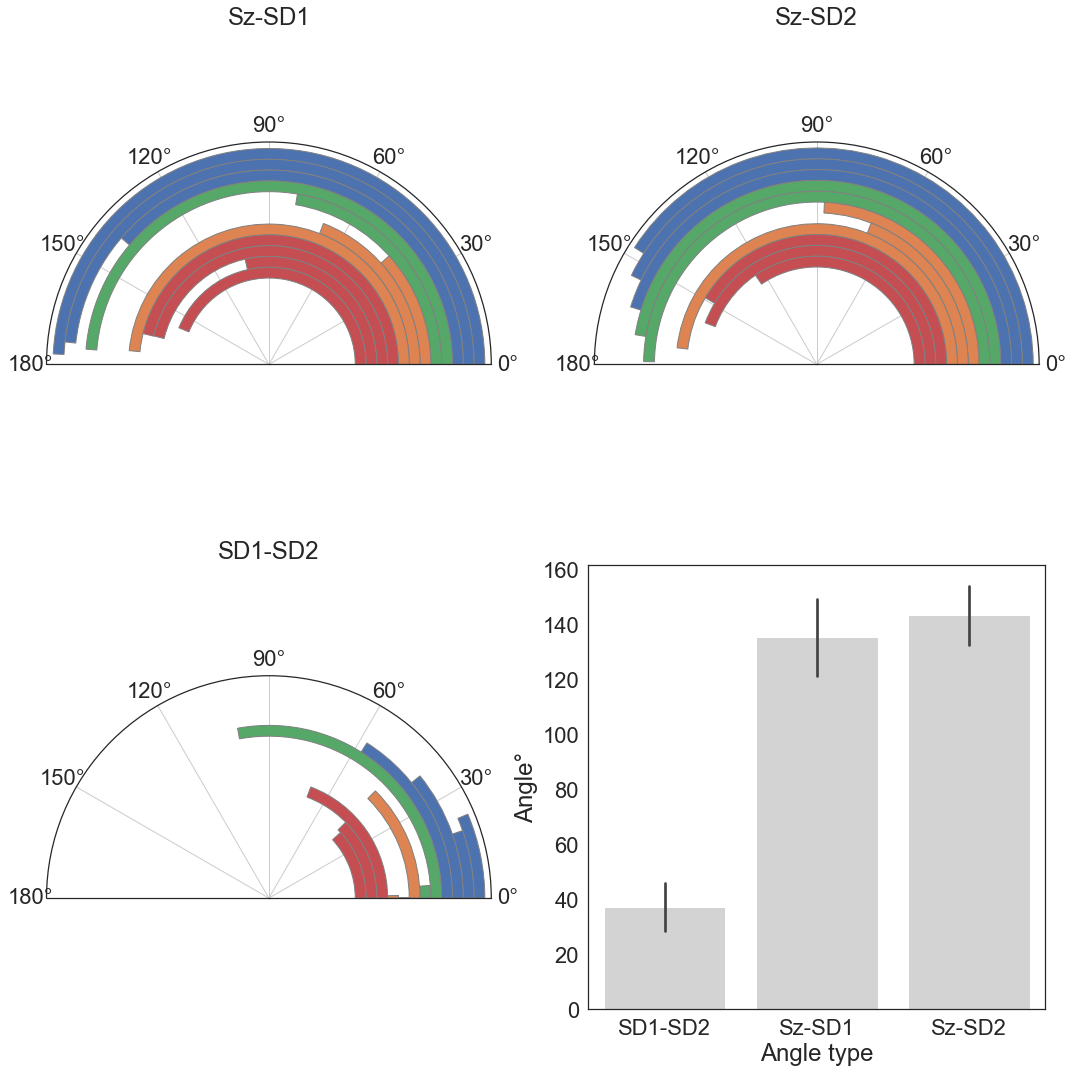

In [91]:
angle_colors = {"sz-sd1" : "blue", "sz-sd2" : "lightgreen", "sd1-sd2": "yellow"}
mouse_colors = {"T301": color_palette[0], "T333": color_palette[1], "T329": color_palette[2], "T352": color_palette[3]}
bar_height=20
r0 = 100

fig = plt.figure(figsize=(18,18))
ax_szsd1 = fig.add_subplot(221, projection='polar')
ax_szsd2 = fig.add_subplot(222, projection='polar')
ax_sd1sd2 = fig.add_subplot(223, projection='polar')
ax_barplot = fig.add_subplot(224)
ax_szsd1.set_title("Sz-SD1", fontsize=24)
ax_szsd2.set_title("Sz-SD2", fontsize=24)
ax_sd1sd2.set_title("SD1-SD2", fontsize=24)


ax_dict = {"sz-sd1" : ax_szsd1, "sz-sd2" : ax_szsd2, "sd1-sd2" : ax_sd1sd2}
r_dict = {"sz-sd1" : 400, "sz-sd2" : 400, "sd1-sd2"  : 400}

for i_row, row in df_angles_v2.sort_values(by="mouse_id").dropna().iterrows():
    angle = row["angle"]
    mid_angle = angle/2.
    ax_choice = ax_dict[row["angle_type"]]
    ax_choice.bar(x=mid_angle, height=bar_height, width=angle, bottom=r_dict[row["angle_type"]]-bar_height, color=mouse_colors[row["mouse_id"]], edgecolor="grey")
    r_dict[row["angle_type"]] -=bar_height

sns.barplot(data=df_angles_v2.replace({"sz-sd1":"Sz-SD1", "sz-sd2":"Sz-SD2", "sd1-sd2":"SD1-SD2"}).rename(columns={"mouse_id":"mouse ID"}).sort_values(by="mouse ID"), x="angle_type", y="angle_deg", color="lightgrey", errorbar="se", ax=ax_barplot)
plt.xlabel('Angle type')
plt.ylabel('Angle°')

ax_szsd1.axes.get_yaxis().set_visible(False)
ax_szsd2.axes.get_yaxis().set_visible(False)
ax_sd1sd2.axes.get_yaxis().set_visible(False)
ax_szsd1.axis(xmin=0.,xmax=math.pi)
ax_szsd2.axis(xmin=0.,xmax=math.pi)
ax_sd1sd2.axis(xmin=0.,xmax=math.pi)
    
if save_figs:
    fig_fpath = os.path.join(output_folder, f'relative_angles_plus_barplot_SEM_{get_datetime_for_fname()}{file_format}')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

In [92]:
# TODO: dataset assumed to be unimodal (one clump distribution for seizure, for sd1, for sd2...). 
# q-q plot for comparison between groups?
# TODO: Fisher circular statistics p. 47-: mean direction, mean resultant length!!! Circular standard deviation

# Speed analysis

## SD speed based on grid approach

In [93]:
def SDSpeedsTileAlgorithm(i_wave):  
    # i_wave should be 1 or 2
    # returns a tuple:
    # uuids: a list of the uuids, and a 2d list of velocities: an array of all calculated velocities per session (uuid_extended)
    uuids = []
    vs_2d = []
    
    
    for i_group, session_group in all_onsets_df[all_onsets_df[f"onset{i_wave}"].notna()].groupby("uuid_extended"):
        tiles_group = session_group.groupby("tile").median()  # TODO: the center values should be mean, not median!
        x_y_onset = np.array([tiles_group["x"], tiles_group["y"], tiles_group["onset" + str(i_wave)]])
        x_y_onset = x_y_onset.T  # x_y_onset1[i] = [x_i, y_i, onset1_i]
        n_tiles = len(x_y_onset)
        
        # 1. find all tiles with later onset
        #      boolean array of arrays: in a row i, value at index j is True if onset j is greater than onset i. 
        larger_values = x_y_onset[:, 2][:, np.newaxis] < x_y_onset[:, 2]
        #      convert True/False into index. Use fact that within a row, i-th element corresponds to index i. Put np.inf if not larger
        larger_indices = np.where(larger_values, np.arange(n_tiles), np.inf)
        # 2. find all tile distances
        dist_matrix = distance_matrix(x_y_onset[:,:2],x_y_onset[:,:2])
        #      dist_matrix: each row contains distance to all the other tiles. inf if same tile! (diagonal)
        assert (dist_matrix == dist_matrix.T).all()  # symmetric
        np.fill_diagonal(dist_matrix, np.inf)  # exclude tile itself from being nearest neighbor
        later_tiles_distances = np.where(np.isfinite(larger_indices), dist_matrix, np.inf)
        nearest_indices_later_onset = np.argmin(later_tiles_distances, axis=1)
        vs = np.zeros(n_tiles)
        for i_tile, tile_nearest_indices in enumerate(nearest_indices_later_onset):
            if np.isinf(later_tiles_distances[i_tile]).all():  #  a later onset neuron is actually found
                continue
            else:
                i_nearest_later = tile_nearest_indices
                ds = dist_matrix[i_tile][i_nearest_later] * 1.579  # objective conversion factor  -> [pixel] * [µm] / [pixel]
                dt = (x_y_onset[i_nearest_later][2] - x_y_onset[i_tile][2]) / 15.0  # [frames] / ([frames]/[second]) 
                vs[i_tile] = ds/dt
        vs_2d.append(vs)
        uuids.append(i_group)
    vs_flat = [item for vs_row in vs_2d for item in vs_row]
    v_median = np.median(vs_flat)
    print(f"{v_median} µm/s = {v_median*6./100.} mm/min") 
    fig = plt.figure(figsize=(16,8))
    plt.hist(vs_flat, bins=150)
    plt.show()
    return (uuids, vs_2d)  # in µm/s

234.65475477840545 µm/s = 14.079285286704327 mm/min


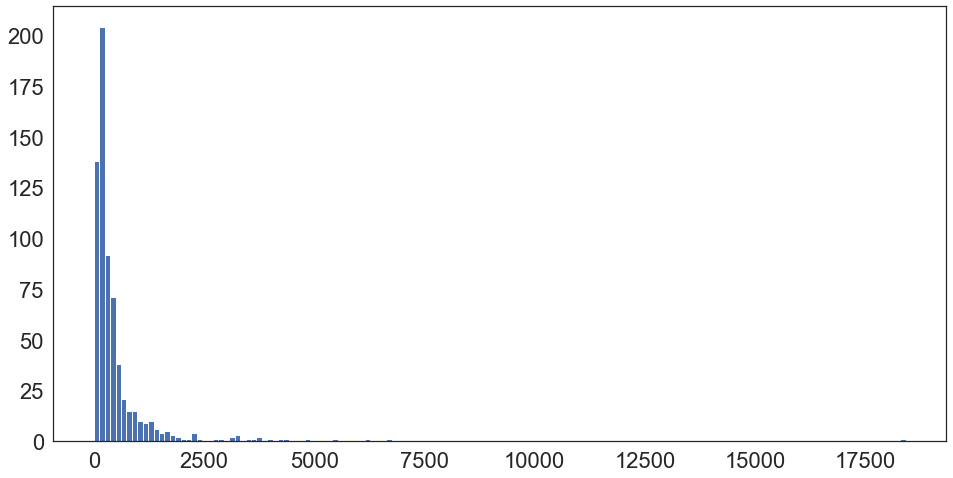

In [94]:
uuids_grid1, vs_grid1 = SDSpeedsTileAlgorithm(1)

189.41245019163938 µm/s = 11.36474701149836 mm/min


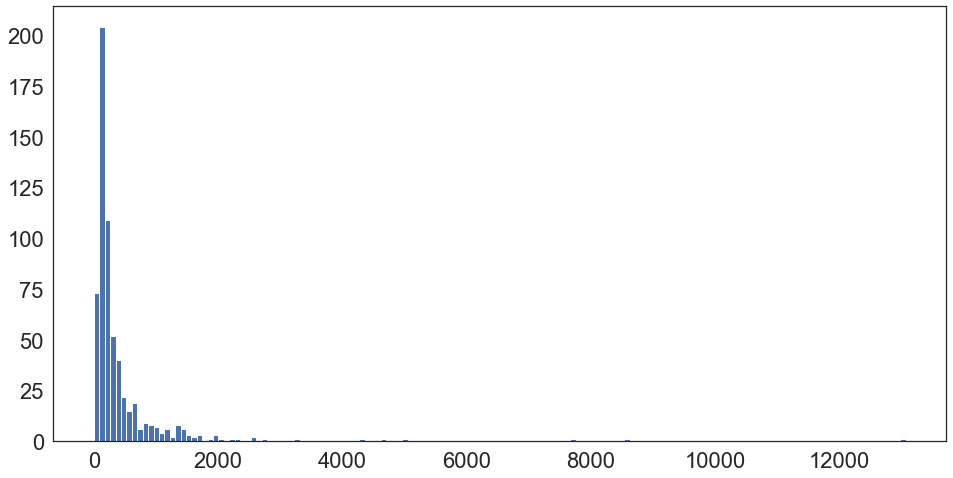

In [95]:
uuids_grid2, vs_grid2 = SDSpeedsTileAlgorithm(2)

## SD speed based on cell approach
Algorithm stays same.

In [96]:
later_neurons_distances = [[1., 2.5, np.inf, 2.4], [np.inf, 1.5, np.inf, np.inf], [np.inf, np.inf, np.inf, np.inf], [1.6, 1.8, 2.5, 1.]]

In [97]:
nearest_indices_later_onset = np.argsort(later_neurons_distances, axis=1)[:,:1]

In [98]:
nearest_indices_later_onset

array([[0],
       [1],
       [0],
       [3]], dtype=int64)

In [99]:
def SDSpeedsCellAlgorithm(i_wave, n_neighbors=1, plot_res = False, vectorize = False, onset_sz = False):  
    # i_wave should be 1 or 2
    # n_neighbors: average the closest n_neighbors cells (with a later onset)
    # plot_res: whether to plot the results (histogram with all velocities)
    # vectorize: whether to return not only the velocity, but in addition, the 2d vector velocity, as well as the centre of the neuron.
    # returns a tuple:
    # uuids: a list of the uuids, and a 2d list of velocities: an array of all calculated velocities per session (uuid_extended)
    uuids = []
    vs_2d = []
    neuron_ids = np.array([], dtype=np.int16)
    
    if onset_sz:
        onset_type = "onset_sz"
    else:
        onset_type = "onset" + str(i_wave)
    
    if vectorize:
        dx_2d = []
        dy_2d = []
        centres_x = np.array([])  # the centre coordinate of each neuron. Same as "x" column in all_onsets_df.
        centres_y = np.array([])
    for i_group, session_group in all_onsets_df[all_onsets_df[onset_type].notna()].groupby("uuid_extended"):
        # TODO: the center values should be mean, not median!
        x_y_onset = np.array([session_group["x"], session_group["y"], session_group[onset_type]])
        x_y_onset = x_y_onset.T  # x_y_onset1[i] = [x_i, y_i, onset1_i]
        n_neurons = len(x_y_onset)
        neuron_ids_curr_session = np.array(session_group["neuron_id"], dtype=np.int16)
        neuron_ids = np.concatenate([neuron_ids, neuron_ids_curr_session])
        # contains (mean) x/y distance to nearest neighbor for each neuron
        dx_session = np.zeros(n_neurons, dtype=np.float64)
        dy_session = np.zeros(n_neurons, dtype=np.float64)
        
        # 1. find all neurons with later onset
        #      boolean array of arrays: in a row i, value at index j is True if onset j is greater than onset i. 
        larger_values = x_y_onset[:, 2][:, np.newaxis] < x_y_onset[:, 2]
        #      convert True/False into index. Use fact that within a row, i-th element corresponds to index i. Put np.inf if not larger
        larger_indices = np.where(larger_values, np.arange(n_neurons), np.inf)
        # 2. find all neuron distances
        dist_matrix = distance_matrix(x_y_onset[:,:2],x_y_onset[:,:2])
        #      dist_matrix: each row contains distance to all the other tiles. inf if same tile! (diagonal)
        assert (dist_matrix == dist_matrix.T).all()  # symmetric
        np.fill_diagonal(dist_matrix, np.inf)  # exclude tile itself from being nearest neighbor
        # find distances neurons with later onset
        later_neurons_distances = np.where(np.isfinite(larger_indices), dist_matrix, np.inf)
        # find closest neurons with later onset
        nearest_indices_later_onset = np.argsort(later_neurons_distances, axis=1)[:,:n_neighbors]
        # calculate velocity with all neighbors above
        vs = np.zeros(n_neurons)
        if vectorize:
            dxs = np.zeros(n_neurons)
            dys = np.zeros(n_neurons)
        for i_neuron, neuron_nearest_indices in enumerate(nearest_indices_later_onset):
            if np.isinf(later_neurons_distances[i_neuron]).all():  #  a later onset neuron is actually found
                continue
            else:       
                if isinstance(neuron_nearest_indices, Iterable):
                    v_neighbors_list = np.zeros(len(neuron_nearest_indices))  
                    if vectorize:
                        dx_neighbors_list = np.zeros(len(neuron_nearest_indices))  
                        dy_neighbors_list = np.zeros(len(neuron_nearest_indices))  
                    
                    for i_neighbor, index_neighbor in enumerate(neuron_nearest_indices):
                        ds = dist_matrix[i_neuron][index_neighbor] * 1.579  # objective conversion factor  -> [pixel] * [µm] / [pixel]
                        dt = (x_y_onset[index_neighbor][2] - x_y_onset[i_neuron][2]) / 15.0  # [frames] / ([frames]/[second]) 
                        v_neighbor = ds/dt
                        v_neighbors_list[i_neighbor] = v_neighbor
                        if vectorize:  # 
                            # get x, y of current neighbor
                            x_nearest = x_y_onset[index_neighbor][0]
                            y_nearest = x_y_onset[index_neighbor][1]
                            # get x, y of current neuron
                            x_curr = x_y_onset[i_neuron][0]
                            y_curr = x_y_onset[i_neuron][1]
                            # get dx, dy
                            dx = x_nearest - x_curr
                            dy = y_nearest - y_curr
                            dx_neighbors_list[i_neighbor] = dx
                            dy_neighbors_list[i_neighbor] = dy
                        
                        
                    vs[i_neuron] = np.median(v_neighbors_list) 
                    if vectorize:
                        dxs[i_neuron] = np.mean(dx_neighbors_list)
                        dys[i_neuron] = np.mean(dy_neighbors_list)
                        
                else:
                    ds = dist_matrix[i_neuron][neuron_nearest_indices[0]] * 1.579  # objective conversion factor  -> [pixel] * [µm] / [pixel]
                    dt = (x_y_onset[neuron_nearest_indices[0]][2] - x_y_onset[i_neuron][2]) / 15.0  # [frames] / ([frames]/[second]) 
                    vs[i_neuron] = ds/dt
        vs_2d.append(vs)
        uuids.append(i_group)
        if vectorize:
            centres_x = np.concatenate([centres_x, session_group["x"]])
            centres_y = np.concatenate([centres_y, session_group["y"]])
            dx_2d.append(dxs)
            dy_2d.append(dys)
            
    vs_flat = [item for vs_row in vs_2d for item in vs_row]
    v_median = np.median(vs_flat)
    print(f"{v_median} µm/s = {v_median*6./100.} mm/min") 
    if plot_res:
        fig = plt.figure(figsize=(16,8))
        plt.hist(vs_flat, bins=150)
        plt.show()
    if vectorize:
        return (uuids, neuron_ids, vs_2d, dx_2d, dy_2d, centres_x, centres_y)
    else:
        return (uuids, neuron_ids, vs_2d)  # in µm/s
    

### Set number of neighbors to find

In [100]:
N_NEIGHBORS = 1

In [101]:
uuids_neuron1, ids_neuron1, vs_neuron1 = SDSpeedsCellAlgorithm(1,N_NEIGHBORS)

132.9938427203366 µm/s = 7.979630563220196 mm/min


In [102]:
uuids_neuron2, ids_neuron2, vs_neuron2 = SDSpeedsCellAlgorithm(2,N_NEIGHBORS)

116.91720937899234 µm/s = 7.015032562739541 mm/min


In [103]:
uuids_neuron_sz, ids_neuron_sz, vs_neuron_sz = SDSpeedsCellAlgorithm(2,1,False,False,True)

133.2478238415993 µm/s = 7.994869430495958 mm/min


## Seizure speed
Define speed (as it occurs within a few frames) as the mean of last quantile minus mean of first quantile.

In [104]:
df_mean_sz_speeds = all_onsets_df.groupby(["uuid_extended", "quantile_sz"])["onset_sz"].mean()

In [105]:
df_sz_speeds = df_mean_sz_speeds.groupby(level=0).agg(lambda x: x.iloc[-1] - x.iloc[0])

In [106]:
df_sz_speeds = df_sz_speeds/15  # frames / (frames/s) = s units (i.e. how much time to spread out within FOV)
df_sz_speeds = sqrt(2)*512*OBJECTIVE_UM_P_PX/df_sz_speeds  # convert to "um/s" TODO: handle non-quadratic cases (sqrt(x**2 + y**2))

In [107]:
vs_neuron_sz_mean = np.array(df_sz_speeds)  # use new measurement of velocity

In [108]:
list(df_sz_speeds.index)

['06ebcf354f5c41519669f187e16de364',
 '2aa75aa234a749668eb896e7e00aa87a',
 '4fe45b25dc854453880cd868fe77e9d4_1',
 '4fe45b25dc854453880cd868fe77e9d4_2',
 '5ea6fd9c4cb542dbbc1f65305725cede',
 '65bff16a4cf04930a5cb14f489a8f99b',
 '73a27053f4bf4ae1b4ad96064b6dabc0',
 '79fb974821f34e3abdcf5ca650e1c0f4',
 'a6099849121f44ccbec237037971ab57',
 'ae564f8c867f4f35aa971b6562c33a7c',
 'd7a5ac8e2bc74382b3db503a6a5a07a5',
 'e40f26d410ab452e8f8d59e5394ae0fe']

In [109]:
df_sz_speeds

uuid_extended
06ebcf354f5c41519669f187e16de364      1649.427646
2aa75aa234a749668eb896e7e00aa87a      1948.491355
4fe45b25dc854453880cd868fe77e9d4_1    1108.784553
4fe45b25dc854453880cd868fe77e9d4_2    1469.677972
5ea6fd9c4cb542dbbc1f65305725cede      2870.221231
65bff16a4cf04930a5cb14f489a8f99b       934.928984
73a27053f4bf4ae1b4ad96064b6dabc0      1718.030835
79fb974821f34e3abdcf5ca650e1c0f4      1922.986515
a6099849121f44ccbec237037971ab57       547.894688
ae564f8c867f4f35aa971b6562c33a7c       689.248282
d7a5ac8e2bc74382b3db503a6a5a07a5       556.407282
e40f26d410ab452e8f8d59e5394ae0fe       504.551260
Name: onset_sz, dtype: float64

## Create dataframe from results

### Sz

In [110]:
# flatten all arrays
vs_neuron_sz_flat = [element for sublist in vs_neuron_sz for element in sublist]
uuids_neuron_sz_flat = [uuids_neuron_sz[i] for i, neurons in enumerate(vs_neuron_sz) for j in range(len(neurons))]
assert len(vs_neuron_sz_flat) == len(uuids_neuron_sz_flat)
# create mean velocity for all sessions
#vs_neuron_sz_mean = [np.median(element) for element in vs_neuron_sz]

### SD 1

In [111]:
# flatten all arrays
vs_neuron1_flat = [element for sublist in vs_neuron1 for element in sublist]
uuids_neuron1_flat = [uuids_neuron1[i] for i, neurons in enumerate(vs_neuron1) for j in range(len(neurons))]
assert len(vs_neuron1_flat) == len(uuids_neuron1_flat)
# create mean velocity for all sessions
vs_neuron1_mean = [np.median(element) for element in vs_neuron1]

In [112]:
# grid algorithm
# flatten all arrays
vs_grid1_flat = [element for sublist in vs_grid1 for element in sublist]
uuids_grid1_flat = [uuids_grid1[i] for i, tiles in enumerate(vs_grid1) for j in range(len(tiles))]
assert len(vs_grid1_flat) == len(uuids_grid1_flat)
# create mean velocity for all sessions
vs_grid1_mean = [np.median(element) for element in vs_grid1]

### SD 2

In [113]:
vs_neuron2_flat = [element for sublist in vs_neuron2 for element in sublist]
uuids_neuron2_flat = [uuids_neuron1[i] for i, neurons in enumerate(vs_neuron2) for j in range(len(neurons))]
assert len(vs_neuron2_flat) == len(uuids_neuron2_flat)
# create mean velocity for all sessions
vs_neuron2_mean = [np.mean(element) for element in vs_neuron2]

In [114]:
vs_grid2_flat = [element for sublist in vs_grid2 for element in sublist]
uuids_grid2_flat = [uuids_grid1[i] for i, tiles in enumerate(vs_grid2) for j in range(len(tiles))]
assert len(vs_grid2_flat) == len(uuids_grid2_flat)
# create mean velocity for all sessions
vs_grid2_mean = [np.mean(element) for element in vs_grid2]

## Create data frames

In [115]:
# grid-based algorithm
vs_grid_df1 = pd.DataFrame({"uuid": uuids_grid1_flat, "v_umps": vs_grid1_flat, "i_wave": 1})  # all velocities calculated
vs_grid_df1_means = pd.DataFrame({"uuid": uuids_grid1, "v_umps": vs_grid1_mean, "i_wave": 1})
vs_grid_df2 = pd.DataFrame({"uuid": uuids_grid2_flat, "v_umps": vs_grid2_flat, "i_wave": 2})
vs_grid_df2_means = pd.DataFrame({"uuid": uuids_grid2, "v_umps": vs_grid2_mean, "i_wave": 2})

# reset index, but keep old index just in case
vs_grid_df = pd.concat([vs_grid_df1, vs_grid_df2], axis=0).reset_index()
vs_grid_df_means = pd.concat([vs_grid_df1_means, vs_grid_df2_means], axis=0).reset_index()

In [116]:
# neuron-based algorithm
vs_df1 = pd.DataFrame({"uuid": uuids_neuron1_flat, "v_umps": vs_neuron1_flat, "i_wave": 1})  # all velocities calculated
vs_df1_means = pd.DataFrame({"uuid": uuids_neuron1, "v_umps": vs_neuron1_mean, "i_wave": 1})
vs_df2 = pd.DataFrame({"uuid": uuids_neuron2_flat, "v_umps": vs_neuron2_flat, "i_wave": 2})  # all velocities calculated
vs_df2_means = pd.DataFrame({"uuid": uuids_neuron2, "v_umps": vs_neuron2_mean, "i_wave": 2})

vs_df_sz = pd.DataFrame({"uuid": uuids_neuron_sz_flat, "v_umps": vs_neuron_sz_flat, "i_wave": 0})  # all velocities calculated
vs_df_sz_means = pd.DataFrame({"uuid": uuids_neuron_sz, "v_umps": vs_neuron_sz_mean, "i_wave": 1})

# reset index, but keep old index just in case
vs_df = pd.concat([vs_df1, vs_df2], axis=0).reset_index()
vs_df_means = pd.concat([vs_df1_means, vs_df2_means], axis=0).reset_index()

vs_df_sz = vs_df_sz.reset_index()
vs_df_sz_means = vs_df_sz_means.reset_index()


In [117]:
# get rid of 0 values
vs_df = vs_df[vs_df["v_umps"] > 0.0]
vs_df_sz = vs_df_sz[vs_df_sz["v_umps"] > 0.0]

In [118]:
# todo: check this warning. Maybe it is due to the split() and it is not a problem?
vs_df["mouse_id"] = vs_df.apply(lambda row: ddoc.getMouseIdForUuid(row["uuid"].split("_")[0]), axis=1)
vs_df_sz["mouse_id"] = vs_df.apply(lambda row: ddoc.getMouseIdForUuid(row["uuid"].split("_")[0]), axis=1)

### Add mm/min
1 µm/s = 60 µm/min = 0.06 mm/min

In [119]:
CONVERSION_FACTOR = 0.06

vs_grid_df["v_mmpmin"] = vs_grid_df["v_umps"] * CONVERSION_FACTOR
vs_grid_df_means["v_mmpmin"] = vs_grid_df_means["v_umps"] * CONVERSION_FACTOR
vs_df["v_mmpmin"] = vs_df["v_umps"] * CONVERSION_FACTOR
vs_df_means["v_mmpmin"] = vs_df_means["v_umps"] * CONVERSION_FACTOR

vs_df_sz["v_mmpmin"] = vs_df_sz["v_umps"] * CONVERSION_FACTOR

In [120]:
#fig = plt.figure(figsize=(16,8))
#plt.hist(vs_df_sz[(vs_df_sz["v_mmpmin"] < 100) & (vs_df_sz["uuid"] == sz_rec_uuid)]["v_mmpmin"], bins=100)
#plt.xlim((0,50))
#plt.show()

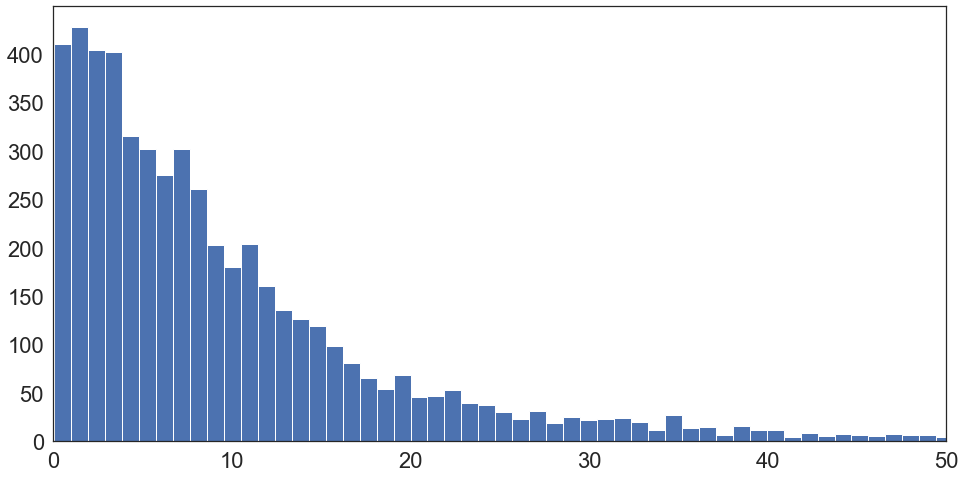

In [121]:
fig = plt.figure(figsize=(16,8))
plt.hist(vs_df[(vs_df["v_mmpmin"] < 100) & (vs_df["i_wave"] == 2)]["v_mmpmin"], bins=100)
plt.xlim((0,50))
plt.show()

In [122]:
sz_means_per_session = vs_df_sz.groupby(["mouse_id", "uuid"]).median().reset_index()

In [123]:
# todo: group by uuid and i_wave (pivot_table) and make boxplot with sem
means_per_session = vs_df.groupby(["mouse_id", "uuid", "i_wave"]).median().reset_index()

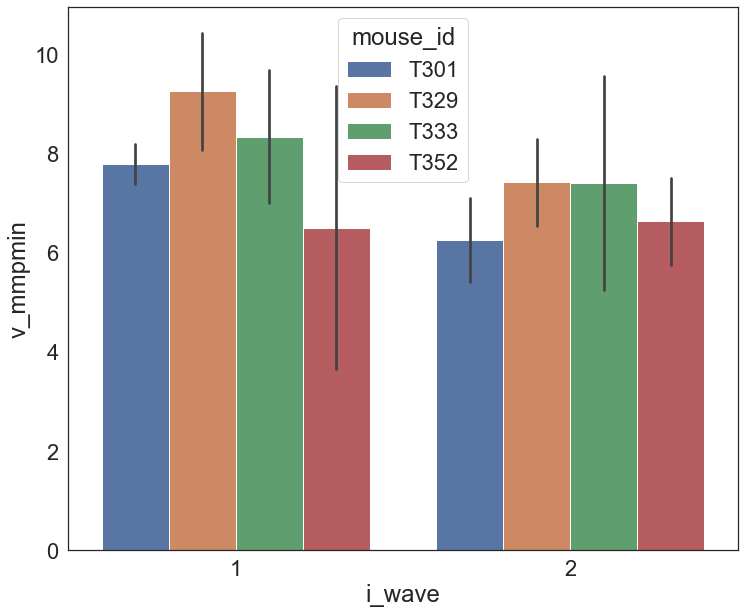

In [124]:
fig = plt.figure(figsize=(12,10))
sns.barplot(means_per_session, x="i_wave", y="v_mmpmin", hue="mouse_id", errorbar="sd")
plt.show()

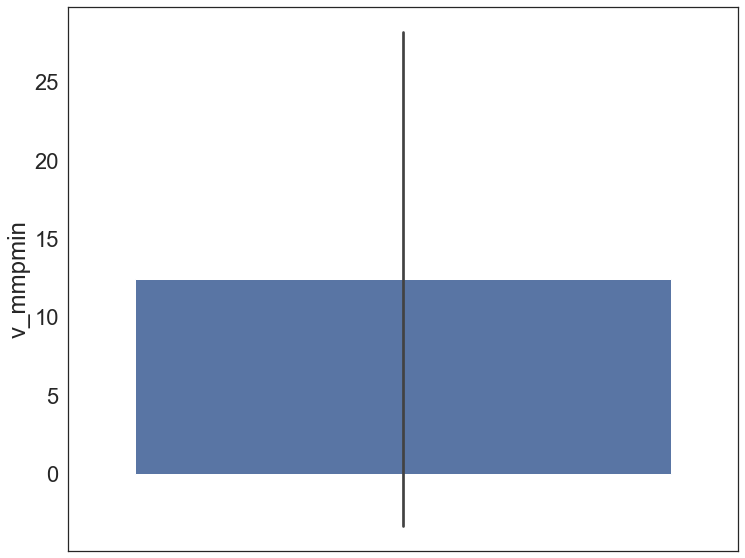

In [125]:
fig = plt.figure(figsize=(12,10))
sns.barplot(sz_means_per_session, y="v_mmpmin", hue="mouse_id", errorbar="sd")
plt.show()

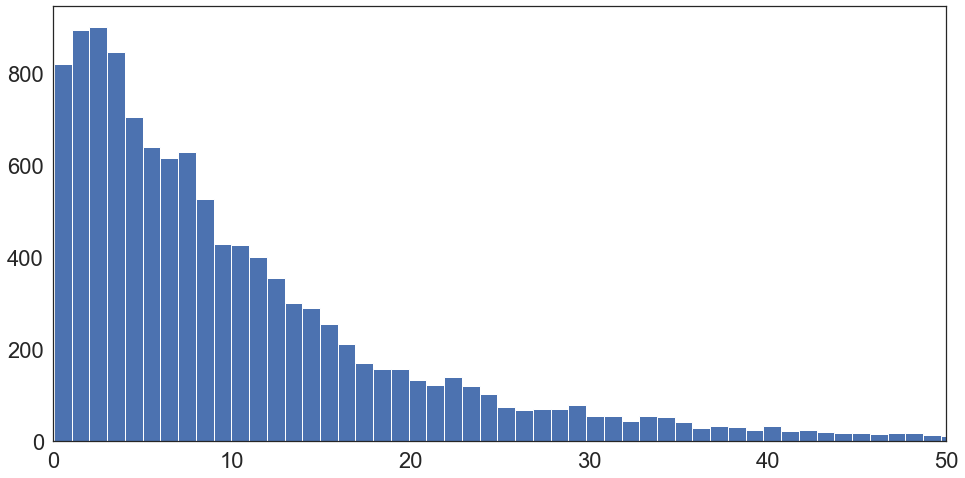

In [126]:
fig = plt.figure(figsize=(16,8))
plt.hist(vs_df[(vs_df["v_mmpmin"] < 100)]["v_mmpmin"], bins=100)
plt.xlim((0,50))
plt.show()

In [127]:
vs_df.describe()

index        v_umps        i_wave      v_mmpmin
count  11601.000000  11601.000000  11601.000000  11601.000000
mean    2938.770106    206.235838      1.459185     12.374150
std     1721.117228    365.566777      0.498353     21.934007
min        0.000000      0.473501      1.000000      0.028410
25%     1456.000000     55.518093      1.000000      3.331086
50%     2917.000000    126.088891      1.000000      7.565333
75%     4384.000000    244.849708      2.000000     14.690982
max     6318.000000  10355.652667      2.000000    621.339160

### Plot velocity distribution

In [128]:
def histVelocities(vs_df):
    f, ax = plt.subplots(figsize=(12, 10))
    sns.despine(f)
    sns.histplot(vs_df, x="v_mmpmin", hue="uuid", multiple="stack")
    ax.set_ylim((0,600))
    ax.set_xlim((0,1500))
    plt.show()

In [129]:
#histVelocities(vs_df)

In [130]:
#histVelocities(vs_grid_df)

In [131]:
def boxPlotMeanSDVelocity(vs_df_means):
    mpl.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(6,10))
    sns.barplot(
        vs_df_means, x="i_wave", y="v_mmpmin", errorbar="sd"
    )
    ax = plt.gca()
    ax.set_xlabel("# SD wave", fontsize=20)
    ax.set_ylabel("v (mm/min)", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    #plt.savefig("D:\\Downloads\\estimated_SD_velocity_barplot.jpg")
    plt.show()

In [132]:
vs_df_means[vs_df_means["i_wave"] == 2].mean()

C:\Users\Bence\AppData\Local\Temp\ipykernel_23136\3488158455.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vs_df_means[vs_df_means["i_wave"] == 2].mean()


index         5.500000
v_umps      199.682177
i_wave        2.000000
v_mmpmin     11.980931
dtype: float64

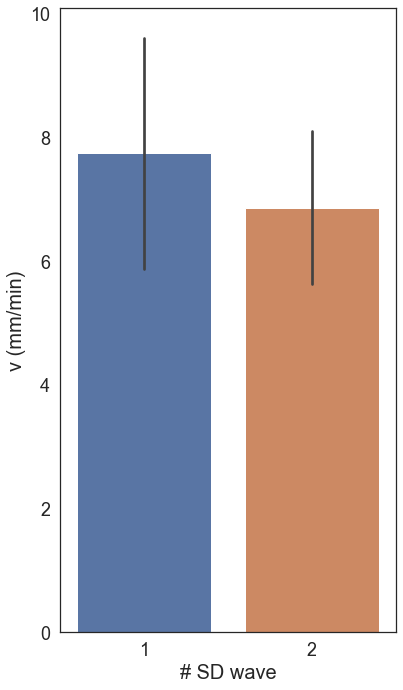

In [133]:
boxPlotMeanSDVelocity(means_per_session)

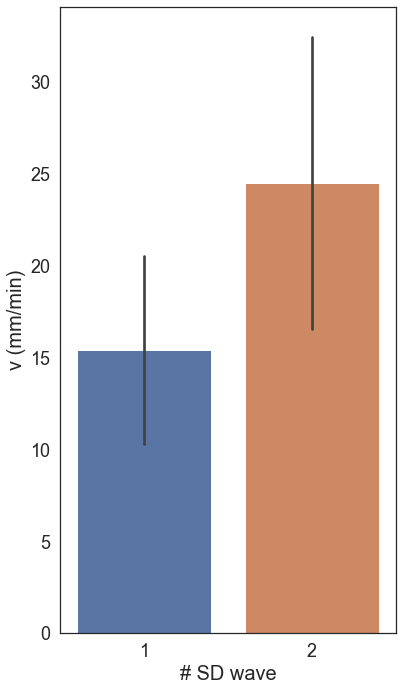

In [134]:
boxPlotMeanSDVelocity(vs_grid_df_means)

In [135]:
means_per_session_sd_and_sz = pd.concat([sz_means_per_session, means_per_session], axis=0)

In [136]:
means_per_session_sd_and_sz = means_per_session_sd_and_sz.replace({"i_wave": {0.0: "Sz", 1.0: "SD1", 2.0: "SD2"}})

In [137]:
means_per_session_sd_and_sz = means_per_session_sd_and_sz.rename(columns={"i_wave": "type"})

In [138]:
def boxPlotMeanSDSzVelocity(vs_df_means):
    fig = plt.figure(figsize=(6,10))
    sns.barplot(
        vs_df_means, x="type", y="v_mmpmin", errorbar="sd"
    )
    ax = plt.gca()
    ax.set_xlabel("Type", fontsize=20)
    ax.set_ylabel("v (mm/min)", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    if save_figs:
        plt.savefig("D:\\Downloads\\estimated_SDSz_velocity_barplot.jpg")
        print("Figure saved")
    plt.show()

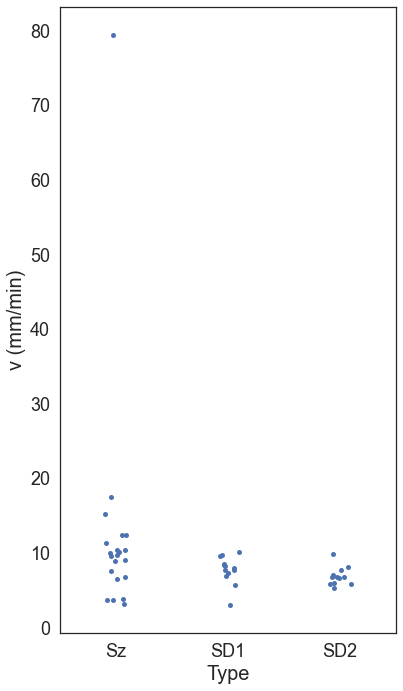

In [139]:
fig = plt.figure(figsize=(6,10))
sns.stripplot(
    means_per_session_sd_and_sz, x="type", y="v_mmpmin"
)
ax = plt.gca()
ax.set_xlabel("Type", fontsize=20)
ax.set_ylabel("v (mm/min)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

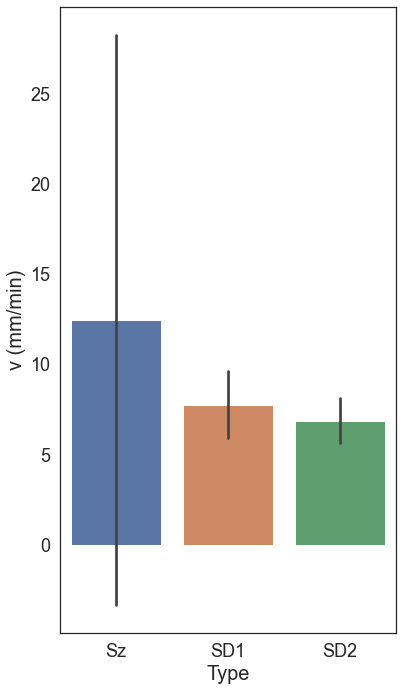

In [140]:
boxPlotMeanSDSzVelocity(means_per_session_sd_and_sz)

## Do the same for several n_neighbors settings

In [141]:
a = np.array([1, 2])
b = np.array([3,4])
np.concatenate([a,b])

array([1, 2, 3, 4])

In [142]:
n_max_neighbors = 10
neuron_means_multi_dict = {"uuid": [], "i_wave": [], "n_neighbors" : [], "v_umps":[]}

v_umps = np.array([])

for i_wave in range(2):
    for i_neighbors in range(1,n_max_neighbors+1):
        uuids, neuron_ids, vs = SDSpeedsCellAlgorithm(i_wave+1,i_neighbors)  # i_wave is 0-indexing, function takes 1-indexing
        vs_mean = np.array([np.median(element[element > 0.0]) for element in vs])
        neuron_means_multi_dict["uuid"] += uuids
        neuron_means_multi_dict[f"i_wave"] += [i_wave+1 for i in range(len(uuids))]
        neuron_means_multi_dict["n_neighbors"] += [i_neighbors for i in range(len(uuids))]
        v_umps = np.concatenate([v_umps, vs_mean])
        
neuron_means_multi_dict[f"v_umps"] = v_umps
        

132.9938427203366 µm/s = 7.979630563220196 mm/min
174.80571056787284 µm/s = 10.488342634072369 mm/min
166.86051069855827 µm/s = 10.011630641913495 mm/min
182.8877104321234 µm/s = 10.973262625927404 mm/min
179.71702675072325 µm/s = 10.783021605043395 mm/min
194.0250126626759 µm/s = 11.641500759760554 mm/min
190.88497136659635 µm/s = 11.45309828199578 mm/min
199.47739318563305 µm/s = 11.968643591137983 mm/min
199.04261656531514 µm/s = 11.942556993918908 mm/min
203.98326762620172 µm/s = 12.238996057572104 mm/min
116.91720937899234 µm/s = 7.015032562739541 mm/min
150.28258121502472 µm/s = 9.016954872901483 mm/min
139.6288551994802 µm/s = 8.377731311968812 mm/min
156.4150009921853 µm/s = 9.384900059531118 mm/min
154.30410556001644 µm/s = 9.258246333600987 mm/min
162.52863491237636 µm/s = 9.751718094742582 mm/min
162.74257045009807 µm/s = 9.764554227005885 mm/min
168.46731931832863 µm/s = 10.108039159099718 mm/min
169.19050231400215 µm/s = 10.151430138840128 mm/min
171.74226916751087 µm/s = 

### Create dataframes

In [143]:
neuron_means_multi_df = pd.DataFrame(neuron_means_multi_dict)
neuron_means_multi_df["v_mmpmin"] =  neuron_means_multi_df["v_umps"] * CONVERSION_FACTOR

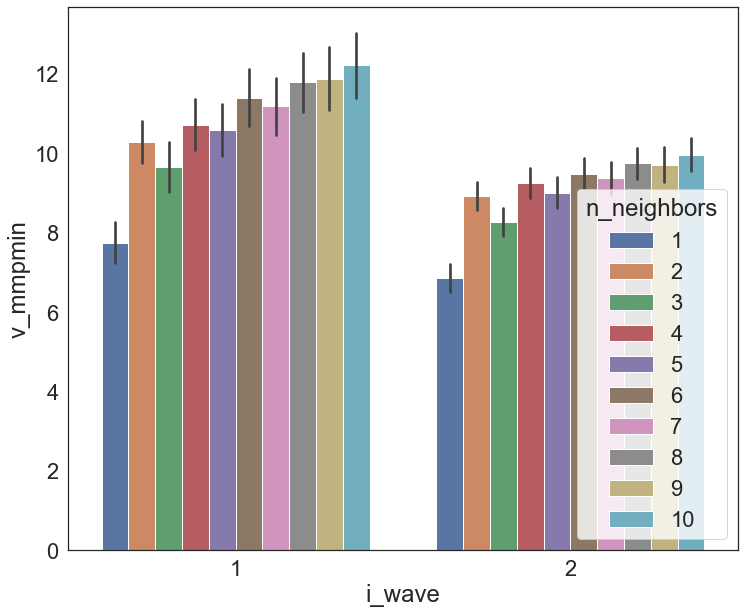

In [144]:
fig = plt.figure(figsize=(12,10))
sns.barplot(neuron_means_multi_df, x="i_wave", y="v_mmpmin", hue="n_neighbors", errorbar="se")
plt.show()

In [145]:
len(neuron_means_multi_dict["v_umps"])

250

# Check quality of estimation visually
perform the nearest later neighbor extraction with vectorize=True, plot as arrows with center of each neuron the nearest neighbors, or the velocity (multiply [dx, dy] by v/sqrt(dx^2 + dy^2)

In [146]:
def vectorizedVDF(i_wave=1, n_neighbors=1, get_sz = False):  # i_wave: 1 or 2, n_neighbors: 1, 2, ...
    # results are a list of numpy arrays, one array per recording 
    uuids_neuron1, ids_neuron1, vs_neuron1, dx_neuron1, dy_neuron1, centres_x_neuron1, centres_y_neuron1 = SDSpeedsCellAlgorithm(i_wave,n_neighbors,False,True, get_sz)

    # flatten all arrays
    vs_flat = [element for sublist in vs_neuron1 for element in sublist]
    uuids_flat = [uuids_neuron1[i] for i, neurons in enumerate(vs_neuron1) for j in range(len(neurons))]
    dx_flat = [element for sublist in dx_neuron1 for element in sublist]
    dy_flat = [element for sublist in dy_neuron1 for element in sublist]

    #ids_neuron1, centres_x_neuron1, centres_y_neuron1 are already flat
    assert len(vs_neuron1_flat) == len(uuids_neuron1_flat)
    # create mean velocity for all sessions
    vs_neuron1_mean = [np.median(element) for element in vs_neuron1]
    vector_vs_df = pd.DataFrame({"uuid": uuids_flat, "neuron_id": ids_neuron1, "v": vs_flat, "dx": dx_flat, "dy": dy_flat, "x0": centres_x_neuron1, "y0": centres_y_neuron1, "i_wave": [i_wave for i in range(len(centres_y_neuron1))]})
    return vector_vs_df

### Get vector nearest neighbor velocity data for all waves and sessions 

In [147]:
N_NEIGHBORS_VEC = 1

In [148]:
# assuming there are 2 waves at most
vector_vs_df = vectorizedVDF(1, N_NEIGHBORS_VEC)
vector_vs_df = pd.concat([vector_vs_df, vectorizedVDF(2, N_NEIGHBORS_VEC)])

132.9938427203366 µm/s = 7.979630563220196 mm/min
116.91720937899234 µm/s = 7.015032562739541 mm/min


In [149]:
vector_vs_df_sz = vectorizedVDF(1, N_NEIGHBORS_VEC, True)

133.2478238415993 µm/s = 7.994869430495958 mm/min


## Plot velocities calculated for first look of distribution

In [150]:
uuid_example = "ae564f8c867f4f35aa971b6562c33a7c" #"e40f26d410ab452e8f8d59e5394ae0fe"

In [151]:
example_df = all_onsets_df[all_onsets_df["uuid"] == uuid_example]

In [152]:
vector_vs_df_single2 = vector_vs_df[(vector_vs_df["uuid"] == uuid_example) & (vector_vs_df["i_wave"] == 2)]
vector_vs_df_single1 = vector_vs_df[(vector_vs_df["uuid"] == uuid_example) & (vector_vs_df["i_wave"] == 1)]
vector_vs_df_single_sz = vector_vs_df_sz[(vector_vs_df_sz["uuid"] == uuid_example)]

In [153]:
# throw away outliers
v_90_percent2 = vector_vs_df_single2["v"].quantile(0.9)
vector_vs_df_single2_outliers = vector_vs_df_single2[vector_vs_df_single2["v"] > v_90_percent2]
vector_vs_df_single2_rest = vector_vs_df_single2[vector_vs_df_single2["v"] <= v_90_percent2]

v_90_percent1 = vector_vs_df_single1["v"].quantile(0.9)
vector_vs_df_single1_outliers = vector_vs_df_single1[vector_vs_df_single1["v"] > v_90_percent1]
vector_vs_df_single1_rest = vector_vs_df_single1[vector_vs_df_single1["v"] <= v_90_percent1]

v_90_percent_sz = vector_vs_df_single_sz["v"].quantile(0.9)
vector_vs_df_single_sz_outliers = vector_vs_df_single_sz[vector_vs_df_single_sz["v"] > v_90_percent_sz]
vector_vs_df_single_sz_rest = vector_vs_df_single_sz[vector_vs_df_single_sz["v"] <= v_90_percent_sz]


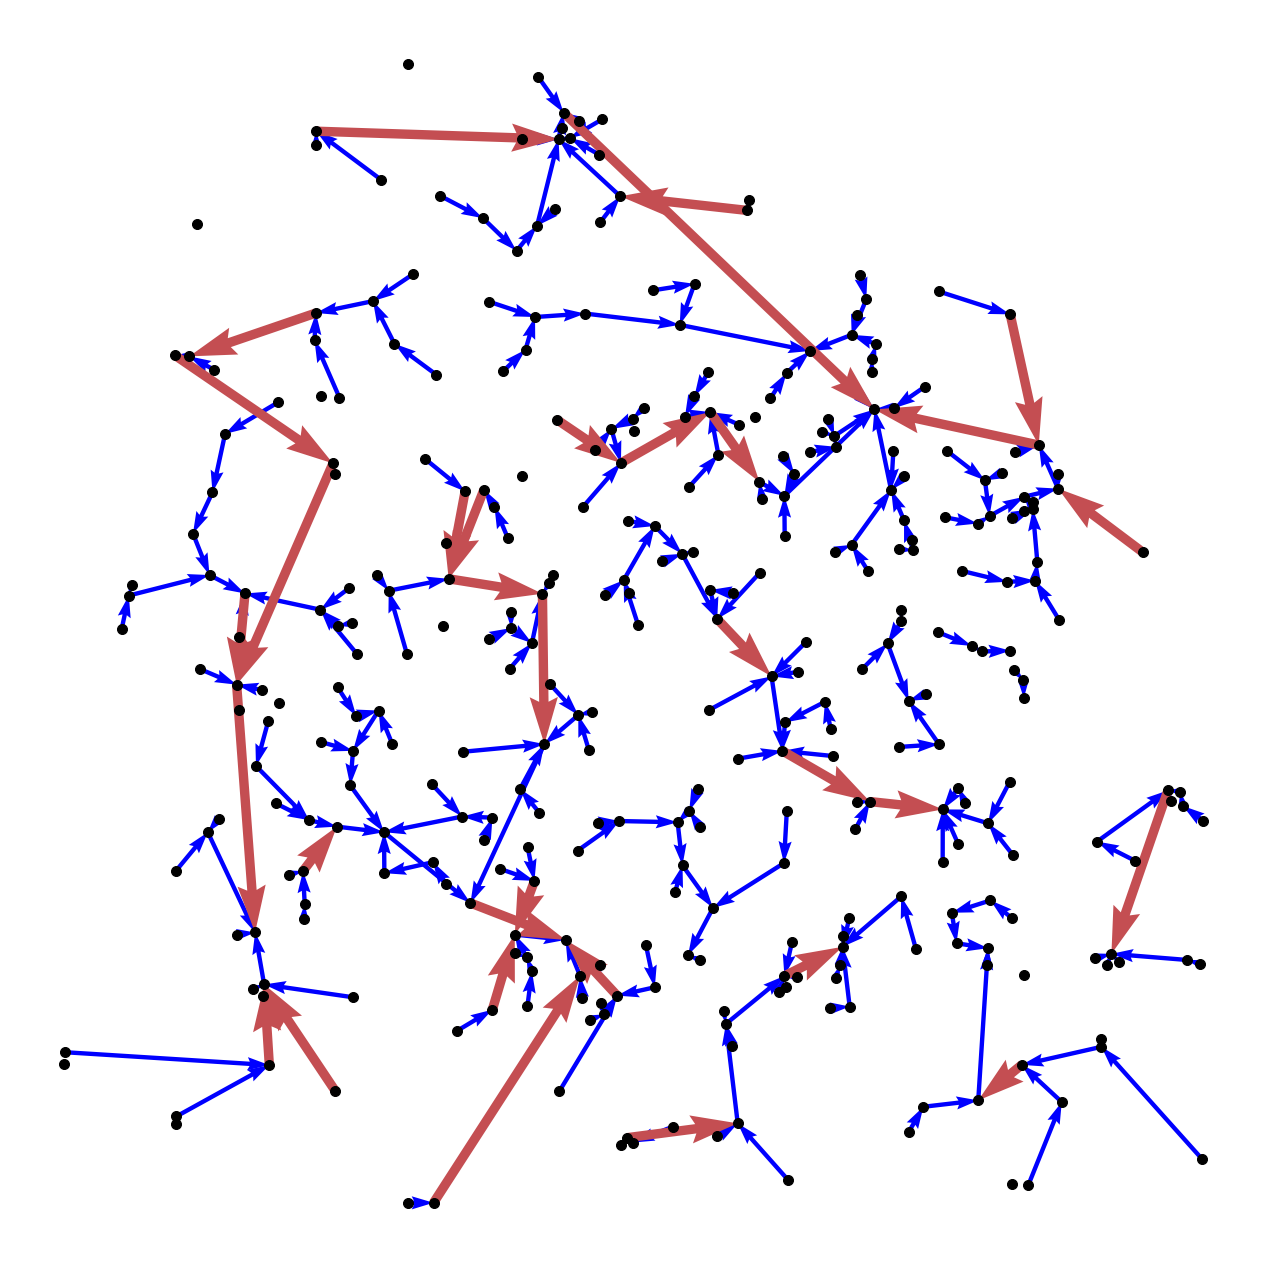

In [154]:
fig, ax = plt.subplots(figsize=(18,18))
ax.quiver(vector_vs_df_single_sz_rest['x0'], vector_vs_df_single_sz_rest['y0'], vector_vs_df_single_sz_rest['dx'], vector_vs_df_single_sz_rest['dy'], color='blue', angles='xy', scale_units='xy', scale=1)
ax.quiver(vector_vs_df_single_sz_outliers['x0'], vector_vs_df_single_sz_outliers['y0'], vector_vs_df_single_sz_outliers['dx'], vector_vs_df_single_sz_outliers['dy'], color='r', angles='xy', scale_units='xy', scale=1)
ax.scatter(example_df["x"], example_df["y"], color="black", s=100)
plt.axis("off")
ax.invert_yaxis()
plt.tight_layout()
#plt.savefig("D:\\Downloads\\example_velocity_arrows_SD1.eps")
plt.show()

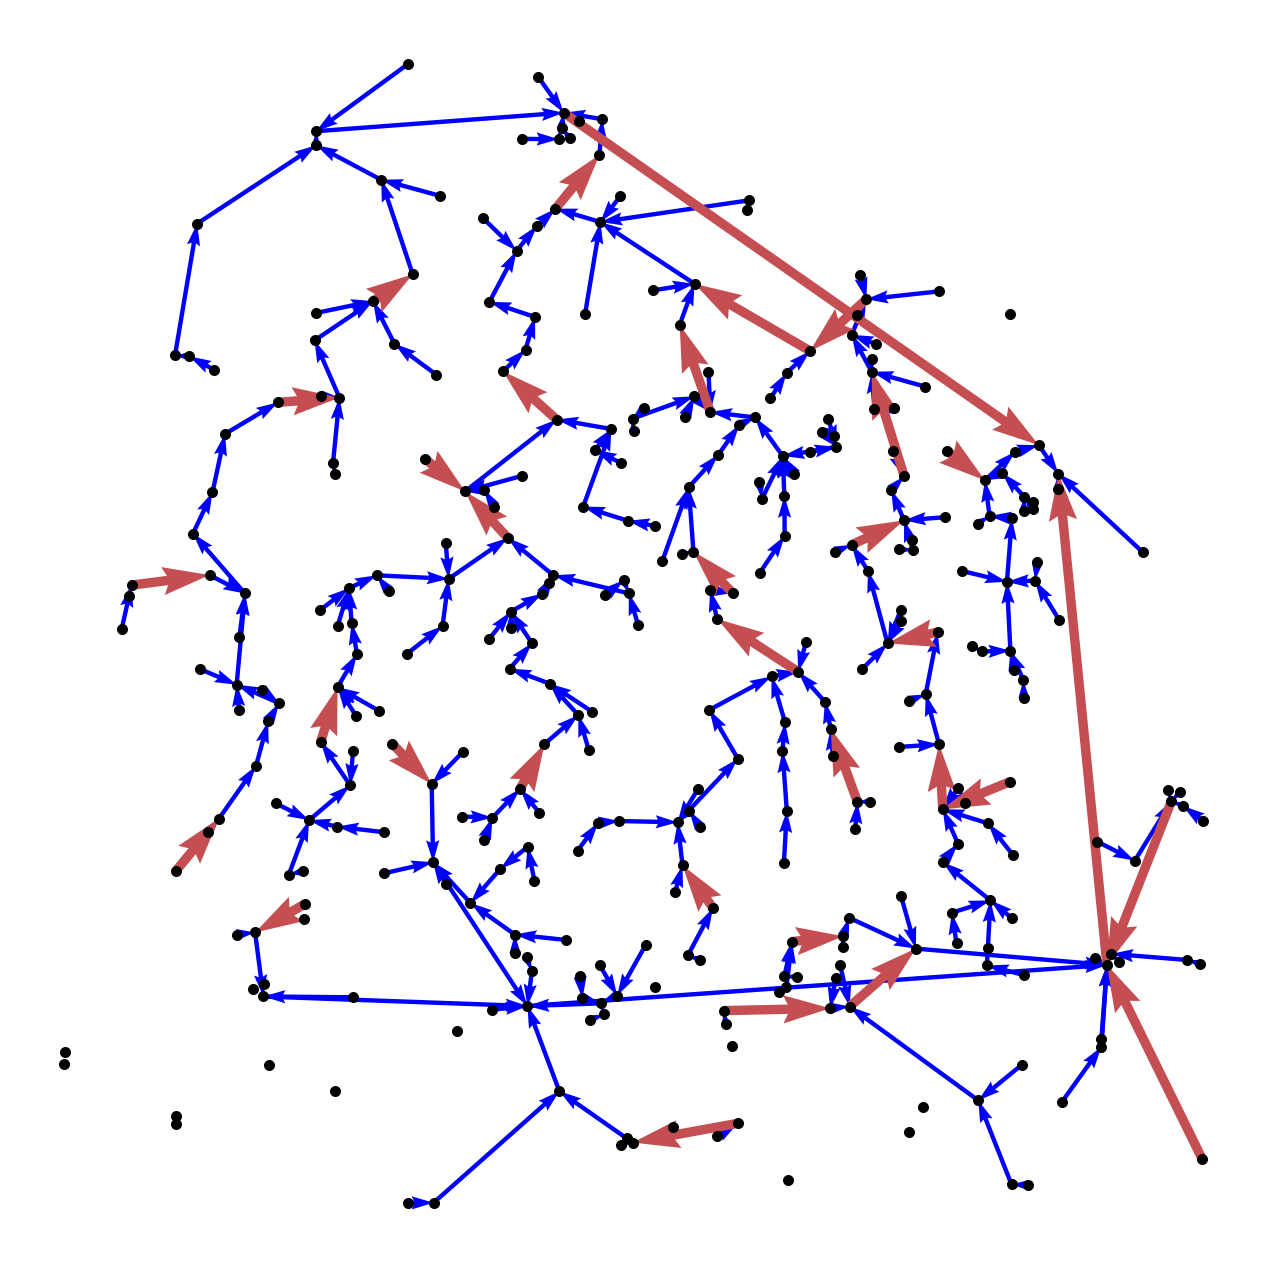

In [155]:
fig, ax = plt.subplots(figsize=(18,18))
ax.quiver(vector_vs_df_single1_rest['x0'], vector_vs_df_single1_rest['y0'], vector_vs_df_single1_rest['dx'], vector_vs_df_single1_rest['dy'], color='blue', angles='xy', scale_units='xy', scale=1)
ax.quiver(vector_vs_df_single1_outliers['x0'], vector_vs_df_single1_outliers['y0'], vector_vs_df_single1_outliers['dx'], vector_vs_df_single1_outliers['dy'], color='r', angles='xy', scale_units='xy', scale=1)
ax.scatter(example_df["x"], example_df["y"], color="black", s=100)
plt.axis("off")
ax.invert_yaxis()
plt.tight_layout()
#plt.savefig("D:\\Downloads\\example_velocity_arrows_SD1.eps")
plt.show()

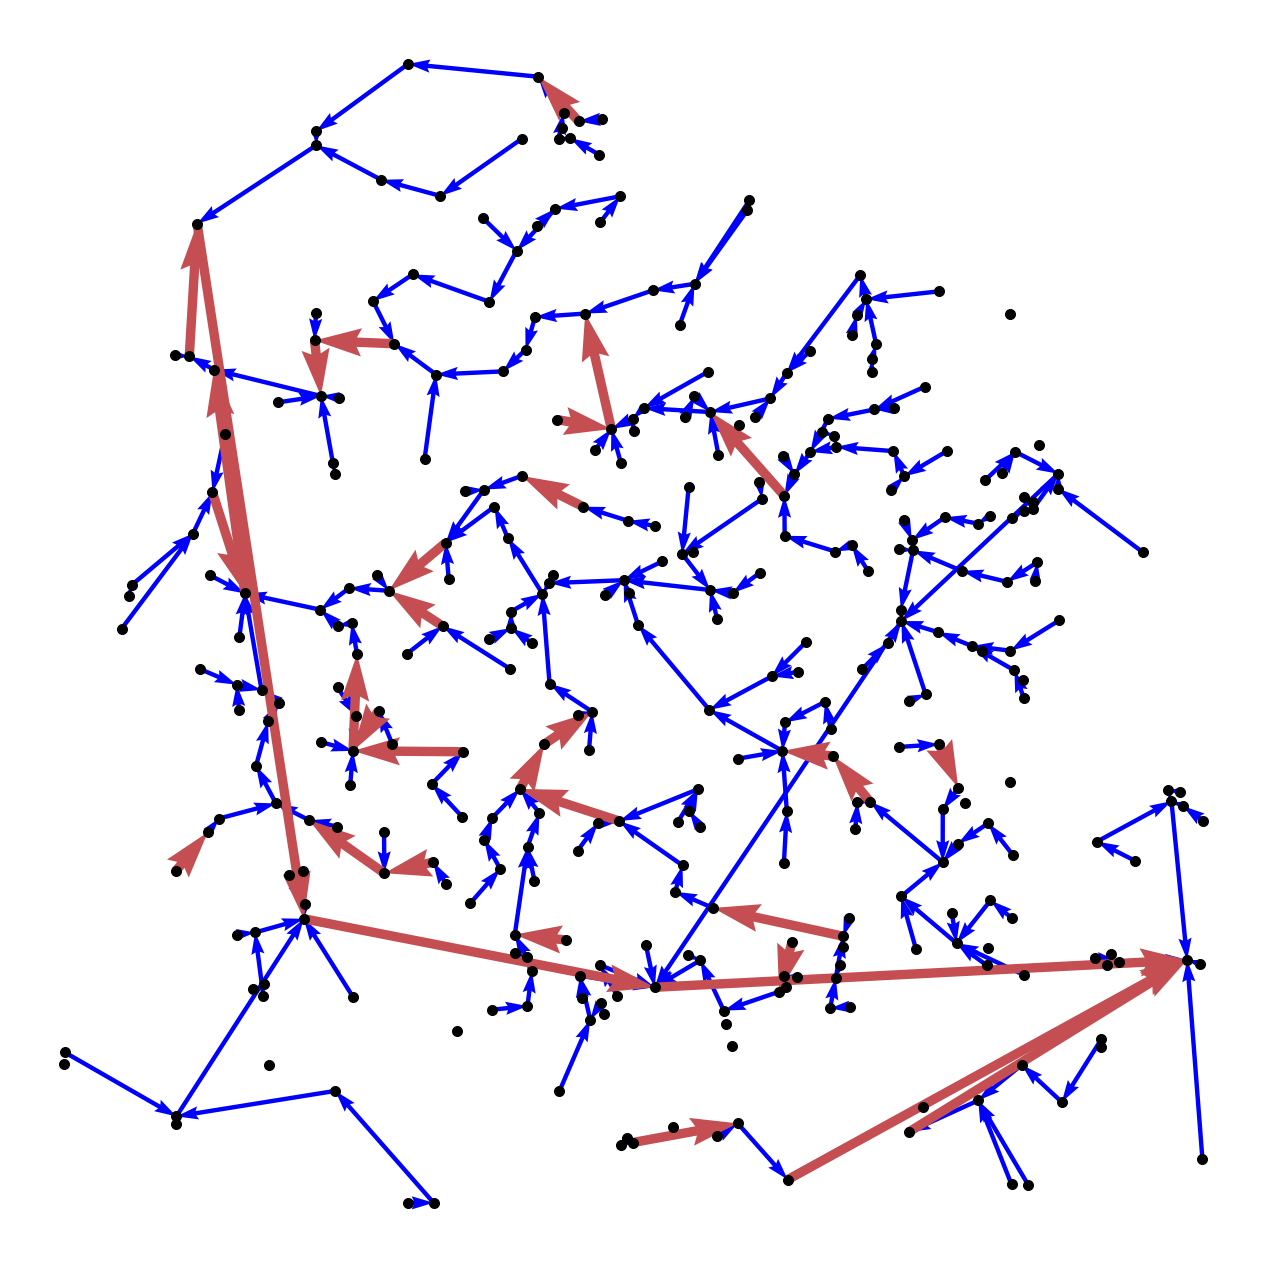

In [156]:
fig, ax = plt.subplots(figsize=(18,18))
ax.quiver(vector_vs_df_single2_rest['x0'], vector_vs_df_single2_rest['y0'], vector_vs_df_single2_rest['dx'], vector_vs_df_single2_rest['dy'], color='blue', angles='xy', scale_units='xy', scale=1)
ax.quiver(vector_vs_df_single2_outliers['x0'], vector_vs_df_single2_outliers['y0'], vector_vs_df_single2_outliers['dx'], vector_vs_df_single2_outliers['dy'], color='r', angles='xy', scale_units='xy', scale=1)
ax.scatter(example_df["x"], example_df["y"], color="black", s=100)
plt.axis("off")
ax.invert_yaxis()
plt.tight_layout()
#plt.savefig("D:\\Downloads\\example_velocity_arrows_SD2.jpg")
plt.show()

In [157]:
len(vs_df[(vs_df["v_mmpmin"] < 100) & (vs_df["uuid"] == uuid_example)])

1001

In [158]:
vs_df[(vs_df["v_mmpmin"] < 100) & (vs_df["uuid"] == uuid_example) & (vs_df["i_wave"] == 1 )]

index                              uuid      v_umps  i_wave mouse_id  \
5039   5039  ae564f8c867f4f35aa971b6562c33a7c  374.329817       1     T301   
5040   5040  ae564f8c867f4f35aa971b6562c33a7c  224.928336       1     T301   
5041   5041  ae564f8c867f4f35aa971b6562c33a7c  368.952771       1     T301   
5042   5042  ae564f8c867f4f35aa971b6562c33a7c   54.855747       1     T301   
5043   5043  ae564f8c867f4f35aa971b6562c33a7c  476.765058       1     T301   
...     ...                               ...         ...     ...      ...   
5361   5361  ae564f8c867f4f35aa971b6562c33a7c    8.892319       1     T301   
5362   5362  ae564f8c867f4f35aa971b6562c33a7c  793.643289       1     T301   
5363   5363  ae564f8c867f4f35aa971b6562c33a7c  628.897597       1     T301   
5364   5364  ae564f8c867f4f35aa971b6562c33a7c   73.509547       1     T301   
5365   5365  ae564f8c867f4f35aa971b6562c33a7c  123.094689       1     T301   

       v_mmpmin  
5039  22.459789  
5040  13.495700  
5041  22.137166  
5042   3.291345  
5043  28.605903  
...         ...  
5361   0.533539  
5362  47.618597  
5363  37.733856  
5364   4.410573  
5365   7.385681  

[326 rows x 6 columns]

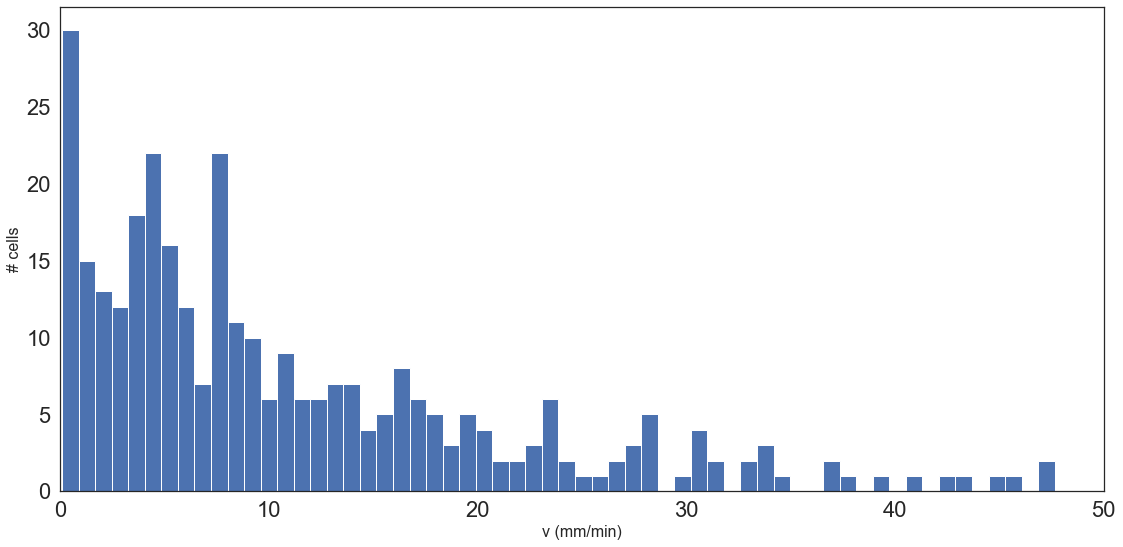

In [159]:
fig = plt.figure(figsize=(16,8))
plt.hist(vs_df[(vs_df["v_mmpmin"] < 100) & (vs_df["uuid"] == uuid_example) & (vs_df["i_wave"] == 1 )]["v_mmpmin"], bins=100)
plt.xlim((0,50))
plt.xlabel("v (mm/min)", fontsize=16)
plt.ylabel("# cells", fontsize=16)
plt.tight_layout()
#plt.savefig("D:\\Downloads\\velocity_example_hist.eps")
plt.show()

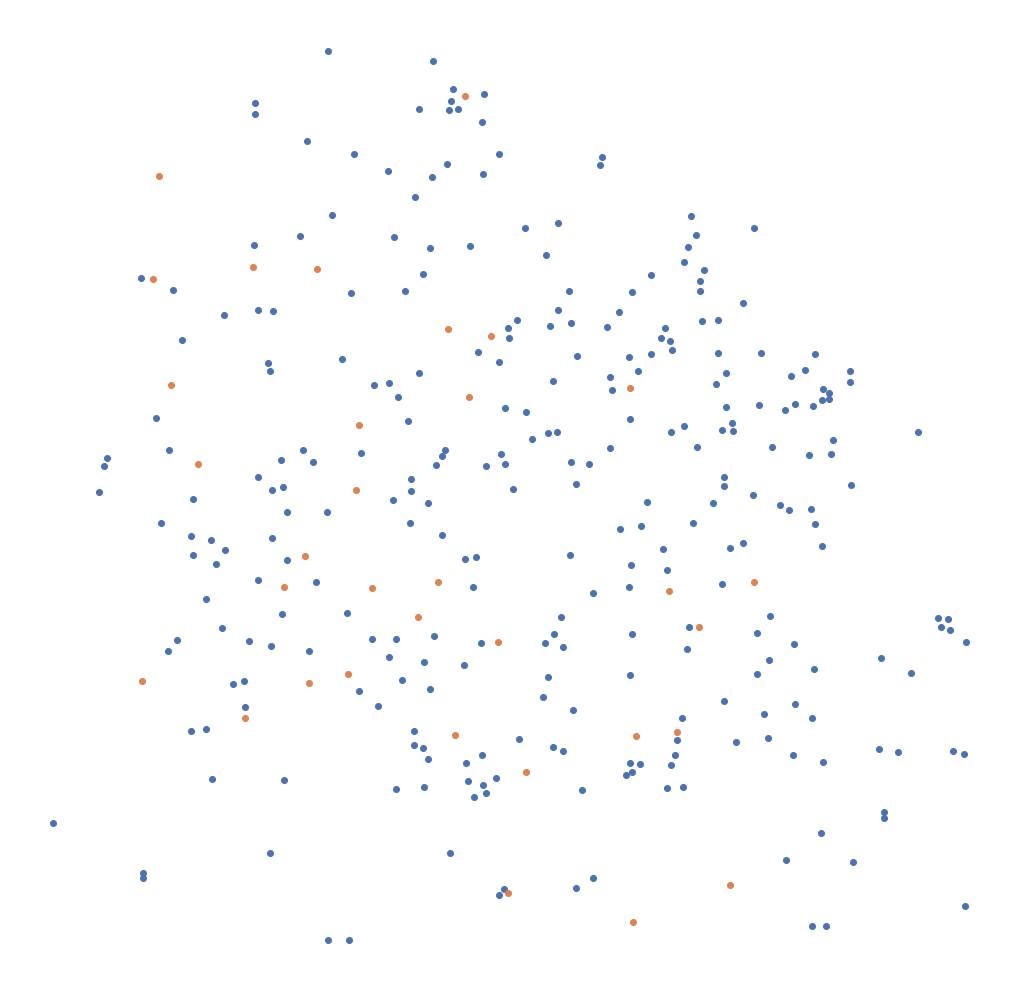

In [160]:
fig, ax = plt.subplots(figsize=(18,18))
ax.scatter(vector_vs_df_single2_rest['x0'], vector_vs_df_single2_rest['y0'])
ax.scatter(vector_vs_df_single2_outliers['x0'], vector_vs_df_single2_outliers['y0'],)
plt.axis("off")
ax.invert_yaxis()
plt.show()

## Seizure onset speed

In [161]:
all_onsets_df["onset_sz_min"] = all_onsets_df.groupby("uuid_extended")['onset_sz'].transform("min")
all_onsets_df["onset_sz_norm"] = all_onsets_df["onset_sz"] - all_onsets_df["onset_sz_min"]
all_onsets_df = all_onsets_df.drop(["onset_sz_min"], axis=1)

### Plot distribution of onset frames per seizure, setting the first onset neuron to 0

In [162]:
dict_uuid_ext_color = dict()
for uuid_extended in all_onsets_df["uuid_extended"].unique():
    mouse_id = all_onsets_df[all_onsets_df["uuid_extended"] == uuid_extended].mouse_id.unique()[0]
    dict_uuid_ext_color[uuid_extended] = df_colors[df_colors["mouse_id"] == mouse_id]["color"].unique()[0]

In [163]:
for uuid_ext, g in all_onsets_df.groupby("uuid_extended"):
    print(f"{uuid_ext}: {g['onset_sz_norm'].mean()}")

06ebcf354f5c41519669f187e16de364: 7.246341463414634
171693d0988c458a96c8198c7b8cfc28: nan
2aa75aa234a749668eb896e7e00aa87a: 7.281592039800995
30dc55d1a5dc4b0286d132e72f208ca6: nan
4fe45b25dc854453880cd868fe77e9d4_1: 6.752631578947368
4fe45b25dc854453880cd868fe77e9d4_2: 10.195876288659793
5ea6fd9c4cb542dbbc1f65305725cede: 5.174757281553398
65bff16a4cf04930a5cb14f489a8f99b: 12.558510638297872
73a27053f4bf4ae1b4ad96064b6dabc0: 6.232715008431703
79fb974821f34e3abdcf5ca650e1c0f4: 4.682926829268292
a6099849121f44ccbec237037971ab57: 18.365765765765765
ae564f8c867f4f35aa971b6562c33a7c: 21.267477203647417
d7a5ac8e2bc74382b3db503a6a5a07a5: 22.03034682080925
e40f26d410ab452e8f8d59e5394ae0fe: 22.420289855072465


In [164]:
all_onsets_df

neuron_id           x           y  row  col  tile  onset1  onset2  \
0             0  117.632308   58.134324    0    1     1  5823.0  5871.0   
0             0  146.185150   14.795159    0    2     2    68.0   107.0   
0             0   60.185628   17.456395    0    0     0  8268.0     NaN   
0             0  204.690997   21.382809    0    3     3    91.0   119.0   
0             0  144.695677   56.238728    0    2     2     NaN     NaN   
...         ...         ...         ...  ...  ...   ...     ...     ...   
1152       1152  362.243428  235.337791    3    5    29     NaN     NaN   
1153       1153  291.046319  492.051780    7    4    60     NaN     NaN   
1154       1154  485.737474  267.141092    4    7    39     NaN     NaN   
1155       1155  110.360567  458.574968    7    1    57     NaN     NaN   
1156       1156  136.716543  486.955987    7    2    58     NaN     NaN   

      quantile1  quantile2                              uuid mouse_id  \
0           2.0        3.0  06ebcf354f5c41519669f187e16de364     T333   
0           3.0        2.0  171693d0988c458a96c8198c7b8cfc28     T301   
0           2.0        NaN  2aa75aa234a749668eb896e7e00aa87a     T352   
0           3.0        0.0  30dc55d1a5dc4b0286d132e72f208ca6     T329   
0           3.0        3.0  4fe45b25dc854453880cd868fe77e9d4     T352   
...         ...        ...                               ...      ...   
1152        NaN        NaN  65bff16a4cf04930a5cb14f489a8f99b     T329   
1153        NaN        NaN  65bff16a4cf04930a5cb14f489a8f99b     T329   
1154        NaN        NaN  65bff16a4cf04930a5cb14f489a8f99b     T329   
1155        NaN        NaN  65bff16a4cf04930a5cb14f489a8f99b     T329   
1156        NaN        NaN  65bff16a4cf04930a5cb14f489a8f99b     T329   

     exp_type  onset_sz  quantile_sz  i_sz  \
0        tmev       NaN          3.0   NaN   
0        tmev       NaN          NaN   NaN   
0        tmev    7901.0          2.0   NaN   
0        tmev       NaN          NaN   NaN   
0        tmev     312.0          3.0   0.0   
...       ...       ...          ...   ...   
1152     tmev   17750.0          3.0   NaN   
1153     tmev   17728.0          0.0   NaN   
1154     tmev   17741.0          2.0   NaN   
1155     tmev   17738.0          1.0   NaN   
1156     tmev   17738.0          1.0   NaN   

                           uuid_extended  onset_sz_norm  
0       06ebcf354f5c41519669f187e16de364            NaN  
0       171693d0988c458a96c8198c7b8cfc28            NaN  
0       2aa75aa234a749668eb896e7e00aa87a           10.0  
0       30dc55d1a5dc4b0286d132e72f208ca6            NaN  
0     4fe45b25dc854453880cd868fe77e9d4_1           20.0  
...                                  ...            ...  
1152    65bff16a4cf04930a5cb14f489a8f99b           22.0  
1153    65bff16a4cf04930a5cb14f489a8f99b            0.0  
1154    65bff16a4cf04930a5cb14f489a8f99b           13.0  
1155    65bff16a4cf04930a5cb14f489a8f99b           10.0  
1156    65bff16a4cf04930a5cb14f489a8f99b           10.0  

[7790 rows x 18 columns]

In [165]:
#fig = plt.figure(figsize=(18,12))
#sns.boxplot(data=all_onsets_df, x="uuid_extended", y="onset_sz_norm", palette=dict_uuid_ext_color)
#plt.savefig("D:\\Downloads\\sz_speeds.jpg")
#plt.show()

In [166]:
df_sz_quantiles = all_onsets_df.groupby('uuid_extended')['onset_sz_norm'].quantile([0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]).unstack()

# Reset index to bring 'id' from index to a column
df_sz_quantiles.reset_index(inplace=True)

# Rename columns for clarity
df_sz_quantiles.columns = ['uuid_extended', 'min', 'q10', 'q25', 'q50', 'q75', 'q90', 'max']

In [167]:
df_sz_quantiles["mouse_id"] = df_sz_quantiles.apply(lambda row: all_onsets_df[all_onsets_df["uuid_extended"] == row["uuid_extended"]].mouse_id.unique()[0], axis=1)
df_sz_quantiles["window_type"] = df_sz_quantiles.apply(lambda row: ddoc.getMouseWinInjInfo("T301").window_type.iloc[0], axis=1)

In [168]:
df_sz_quantiles["dt_q10-q90"] = df_sz_quantiles["q90"] - df_sz_quantiles["q10"]
df_sz_quantiles["dt_q10-q90_s"] = df_sz_quantiles["dt_q10-q90"]/15.  # assume 15 Hz imaging frequency

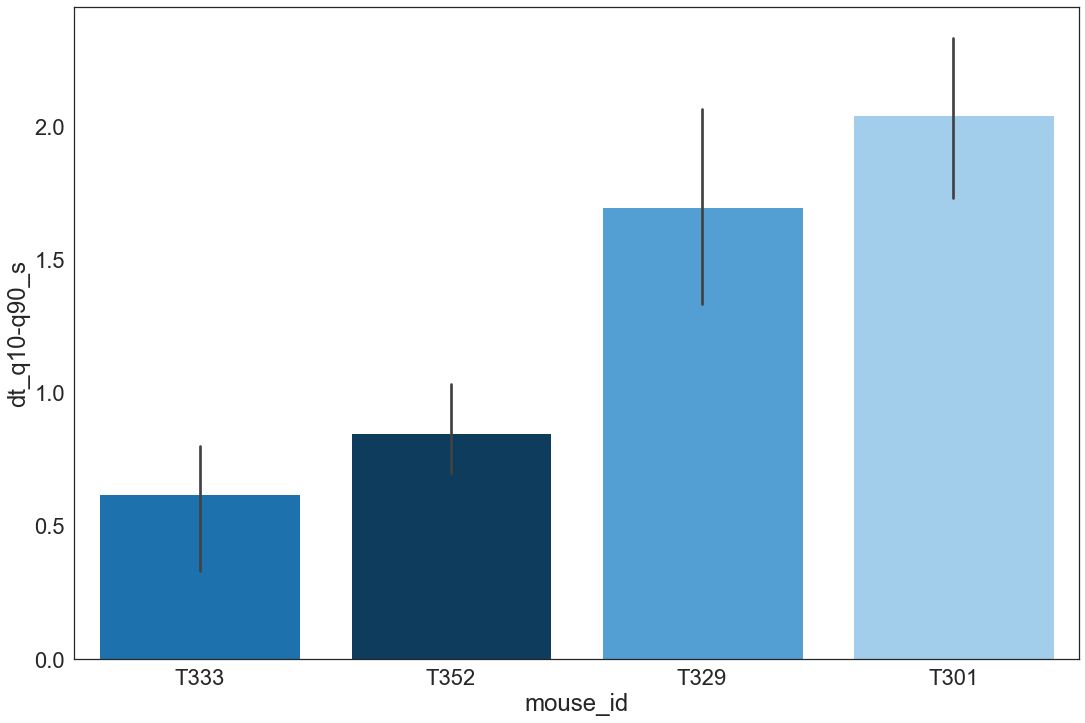

In [169]:
fig = plt.figure(figsize=(18,12))
sns.barplot(data=df_sz_quantiles.dropna(), x="mouse_id", y="dt_q10-q90_s", palette=dict_mouse_id_color)
#plt.savefig("D:\\Downloads\\sz_speeds.jpg")
plt.show()

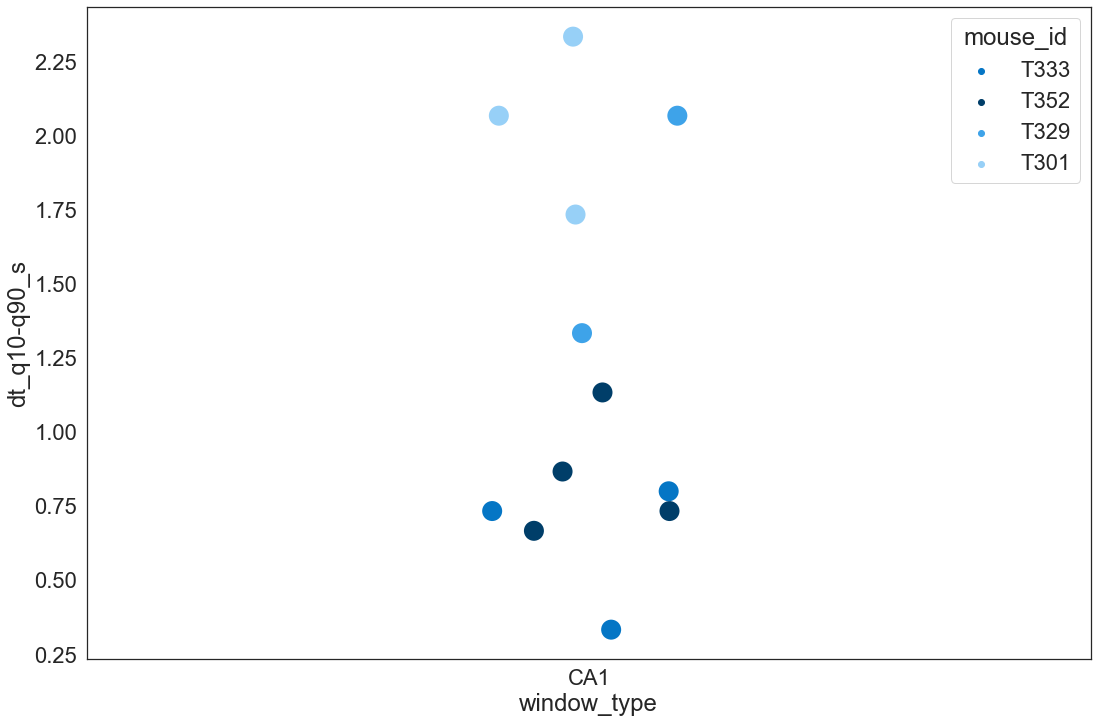

In [170]:
fig = plt.figure(figsize=(18,12))
sns.stripplot(data=df_sz_quantiles.dropna(), x="window_type", y="dt_q10-q90_s", hue="mouse_id", s=20, palette=dict_mouse_id_color)
#plt.savefig("D:\\Downloads\\sz_speeds.jpg")
plt.show()

# Compare within-mouse directions

Two dfs that can be used: `df_angles_per_event`, defined below, contains all events (sz, sd1, sd2) with their angles aligned in a top injection frame. `df_angles_v2` contains for each seizure event (sz, sd1, sd2) the pairwise angles.

In [171]:
#df_angles_v2
df_angles_per_event = qdf.drop(columns=["row", "col", "neuron_id", "onset1", "onset2", "onset_sz", "quantile1", "quantile2", "quantile_sz", "i_sz", "costheta_inj_top", "sintheta_inj_top", "costheta", "sintheta", "y_mirrored", "dx", "dy", "tile", "uuid_extended"])

## Calculate standard deviation of same-event directions
i.e. sz-sdx, sd1-sd2 angles are variables

In [172]:
std_sz_sd1 = df_angles_v2[df_angles_v2["angle_type"] == "sz-sd1"].angle_deg.std()
std_sz_sd1 = df_angles_v2[df_angles_v2["angle_type"] == "sz-sd1"].angle_deg.std()

In [173]:
df_angles_per_event[df_angles_per_event["uuid_matched"] == "2aa75aa234a749668eb896e7e00aa87a"]

mouse_id quantile_type           r     theta  theta_inj_top  \
5 36     T352           sd1  344.902408 -0.888319       0.888319   
6 32     T352            sz  238.713975  0.904889      -0.904889   

                          uuid_matched  theta_deg  mouse_index  
5 36  2aa75aa234a749668eb896e7e00aa87a -50.896911            3  
6 32  2aa75aa234a749668eb896e7e00aa87a  51.846330            3

In [174]:
# get ratio of recordings with 1 sd only
p_two_sd_waves = df_angles_v2[df_angles_v2["angle_type"] == "sz-sd2"].angle.notna().sum() / len(df_angles_v2[df_angles_v2["angle_type"] == "sz-sd2"].angle)

In [175]:
def partial_std(x):
    # circstd  # two alternatives: np.std, circstd
    return np.std(x, ddof=1)
    # return circstd(x)
std_func = partial_std

In [176]:
df_angles_std_per_mouse = df_angles_v2.dropna().groupby(["mouse_id", "angle_type"])["angle"].apply(lambda x: std_func(x)) # df_angles_v2.groupby(["mouse_id", "angle_type"]).std().angle_deg
df_angles_v2["dummy"] = 1  # for summing entries
df_n_exps_per_mouse = df_angles_v2[df_angles_v2["angle_type"] == "sz-sd1"].groupby("mouse_id").sum().dummy
df_angles_v2 = df_angles_v2.drop(columns="dummy")

## Create surrogate sampling
Use circular statistics (mean direction, circular standard deviation):
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.circmean.html#scipy.stats.circmean
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.circstd.html
Fisher - Statistical Analysis of Circular Data (48/293, p. 32). Log = ln (log_e)

In [177]:
#rng = random.SystemRandom() 
rng = np.random.default_rng(2023)

In [178]:
def randomDirectionsAngle(rng, n_angles: int = 2, as_deg = False):
    if as_deg:
        max_angle = 360.0
    else:
        max_angle = 2*pi
    thetas = [max_angle*rng.random() for i_angle in range(n_angles)]
    dthetas = [min(abs(thetas[i]-thetas[0]), max_angle - abs(thetas[i]-thetas[0])) for i in range(1, n_angles)]  # one less angles than in thetas_deg
    return (thetas, dthetas)

In [179]:
def surrogateSample(p_two_sd_waves, rng, n_simulated_mice: int = 1000):
    """
    p_two_sd_waves: observed probability (0-1) of having two SD waves.
    n_simulated_mice: the number of times the experiment should be simulated
    """
    all_angles = []
    all_diff_angles = []
    stds_measured = {"sz-sd1": [], "sz-sd2": [], "sd1-sd2" : []}  # sz-sd1 and sz-sd2 angles
    for i_mouse in range(n_simulated_mice):
        angles_measured = {"sz-sd1": [], "sz-sd2": [], "sd1-sd2" : []}
        # decide number of experiments to run with simulated mouse
        n_experiments = df_n_exps_per_mouse.iloc[rng.randint(0, len(df_n_exps_per_mouse) - 1)]  # randint(a, b) for [a, b]
        for i_experiment in range(n_experiments):
            # decide on number of waves
            if rng.random() > p_two_sd_waves:
                n_angles = 2  # only sz and sd1
            else:
                n_angles = 3
                
            raw_angles, angles_for_exp = randomDirectionsAngle(rng, n_angles)
            
            
            
            # Add all generated angles to appropriate lists
            # to check uniform distribution of generated angles and angles between these simulated vectors
            #  FIXME: these two assignments slow down the algorithm by a lot
            all_angles = all_angles + raw_angles  
            all_diff_angles = all_diff_angles + angles_for_exp
            
            # record angles measured
            angles_measured["sz-sd1"].append(angles_for_exp[0])
            if len(angles_for_exp) > 1:
                angles_measured["sz-sd2"].append(angles_for_exp[1])
            if n_angles == 3:  # also record sd1-sd2 angle if applicable
                angle_sd1sd2 = min(abs(raw_angles[2] - raw_angles[1]), 2*pi - abs(raw_angles[2]-raw_angles[1]))
                angles_measured["sd1-sd2"].append(angle_sd1sd2)
        # calculate std for mouse
        stds_measured["sz-sd1"].append(std_func(angles_measured["sz-sd1"]))  # note: angles are in rad, 0 to pi... maybe need to adjust high and low!
        if len(angles_measured["sz-sd2"]) > 1:
            stds_measured["sz-sd2"].append(std_func(angles_measured["sz-sd2"]))
            stds_measured["sd1-sd2"].append(std_func(angles_measured["sd1-sd2"]))
    return stds_measured, all_angles, all_diff_angles
# old method
# surrogate_stds, surrogate_all_angles, surrogate_all_diff_angles = surrogateSample(p_two_sd_waves, rng, 1000)

In [180]:
# for each mouse, go through each angle type. Get the number of angles of that type for the mouse, simulate 1000 times.
def simulateMouseAngles(rng, n_experiments = 3, n_simulations = 1000):
    std_vals = np.zeros(n_simulations)
    for i_simrun in range(n_simulations):
        angles = np.zeros(n_experiments)
        for i_experiment in range(n_experiments):  # same number of recordings as the mouse had
            raw_angles, generated_angle = randomDirectionsAngle(rng, n_angles=2, as_deg=True) 
            angles[i_experiment] = generated_angle[0] # randomDirectionsAngle returns list
        std_vals[i_simrun] = np.std(angles)
    return std_vals

In [181]:
# For each mouse, each angle type, I need the number of data points available, so I can simulate it. 
# I should also take the std of these
rng = np.random.default_rng(2023)
# {mouse_id1: {angle_type1 :  (n_measurements_per_std1, measured_std, np.array([simulated_std1, ...]) ), angle_type2 : (...), ...}, mouse_id2: [...], ...} 
surrogates_res_dict = {mouse_id: dict() for mouse_id in df_angles_v2.mouse_id.unique()}

for (mouse_id, angle_type), grp in df_angles_v2.drop(columns=["uuid_matched", "angle", "cos_angle"]).dropna().groupby(["mouse_id", "angle_type"]):
    std_deg = np.std(grp.angle_deg)
    n_experiments = len(grp.angle_deg)
    print(f"{mouse_id} {angle_type}: {std_deg}, {n_experiments} values per std")
    simulated_stds_deg = simulateMouseAngles(rng, n_experiments=n_experiments, n_simulations=10000)
    surrogates_res_dict[mouse_id][angle_type] = (n_experiments, std_deg, simulated_stds_deg)

T301 sd1-sd2: 15.23009226535424, 4 values per std
T301 sz-sd1: 17.05059459339019, 3 values per std
T301 sz-sd2: 6.347287079911004, 3 values per std
T329 sd1-sd2: 47.96817991610752, 2 values per std
T329 sz-sd1: 47.36942036232473, 2 values per std
T329 sz-sd2: 4.175315637911808, 2 values per std
T333 sd1-sd2: 21.0085208853244, 3 values per std
T333 sz-sd1: 57.11320010251301, 3 values per std
T333 sz-sd2: 45.454835174532576, 3 values per std
T352 sd1-sd2: 12.178974808835951, 3 values per std
T352 sz-sd1: 26.49217095244236, 4 values per std
T352 sz-sd2: 14.70445314750153, 3 values per std


In [182]:
def plotSTDs(mouse_id, angle_type):
    sim_data = np.sort(surrogates_res_dict[mouse_id][angle_type][2])  # need sorting later for threshold anyway
    measured_std = surrogates_res_dict[mouse_id][angle_type][1]
    n_measurements_per_std = surrogates_res_dict[mouse_id][angle_type][0]
    fig, ax = plt.subplots(figsize=(14,10))
    ax.set_title(f"{mouse_id} {angle_type} ({n_measurements_per_std} values per std)")
    ax.hist(sim_data, bins=30)
    ax.vlines(x=measured_std, ymin=0, ymax=100, color=mouse_colors[mouse_id], linewidth=2)
    #plot 95% threshold
    i_thr = ceil(0.05*len(sim_data))
    x_thr = sim_data[i_thr]  # sim_data is sorted
    ax.vlines(x=x_thr, ymin=0, ymax=120, color="black", linewidth=2)
    plt.show()

In [183]:
n_angle_types = len(df_angles_v2.angle_type.unique())
mouse_ids = df_angles_v2.mouse_id.unique()
angle_types = df_angles_v2.angle_type.unique()

### Plot sample std distributions for n=2, 3, ... measurements forming one std value

In [184]:
from scipy.stats import chi2

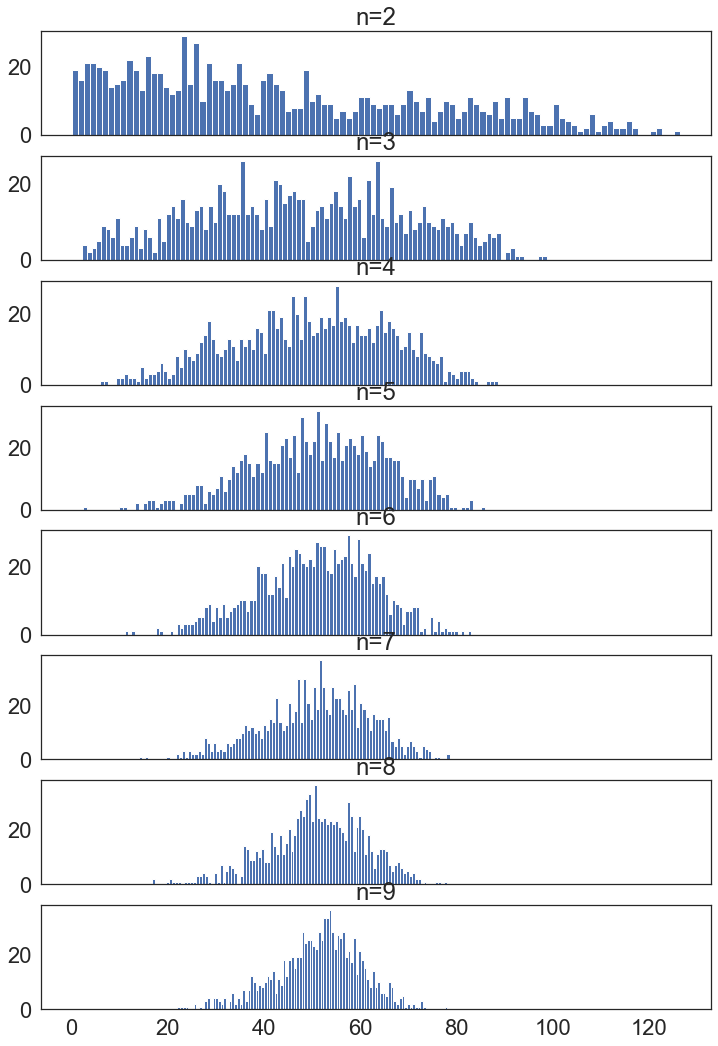

In [185]:
n_simulations = 1000
n_plots = 8
fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(12,18), sharex=True)
#xs = np.arange(0,120,0.1)
for i_row in range(n_plots):
    n_samples = i_row+2
    axs[i_row].set_title(f"n={n_samples}")
    sim_data = np.zeros(n_simulations)
    for i in range(n_simulations):
        samples = []
        for i_sim in range(n_samples):
            angle1 = 360.*rng.random()
            angle2 = 360.*rng.random()
            d_angle = min(abs(angle1-angle2), 360.0 - abs(angle1-angle2))
            samples.append(d_angle)
        sim_data[i] = std_func(samples)
    axs[i_row].hist(sim_data, bins=100)
    #axs[i_row].plot(xs, 20*chi2.pdf(xs, df=i_row+2))
plt.show()

### Plot surrogate results

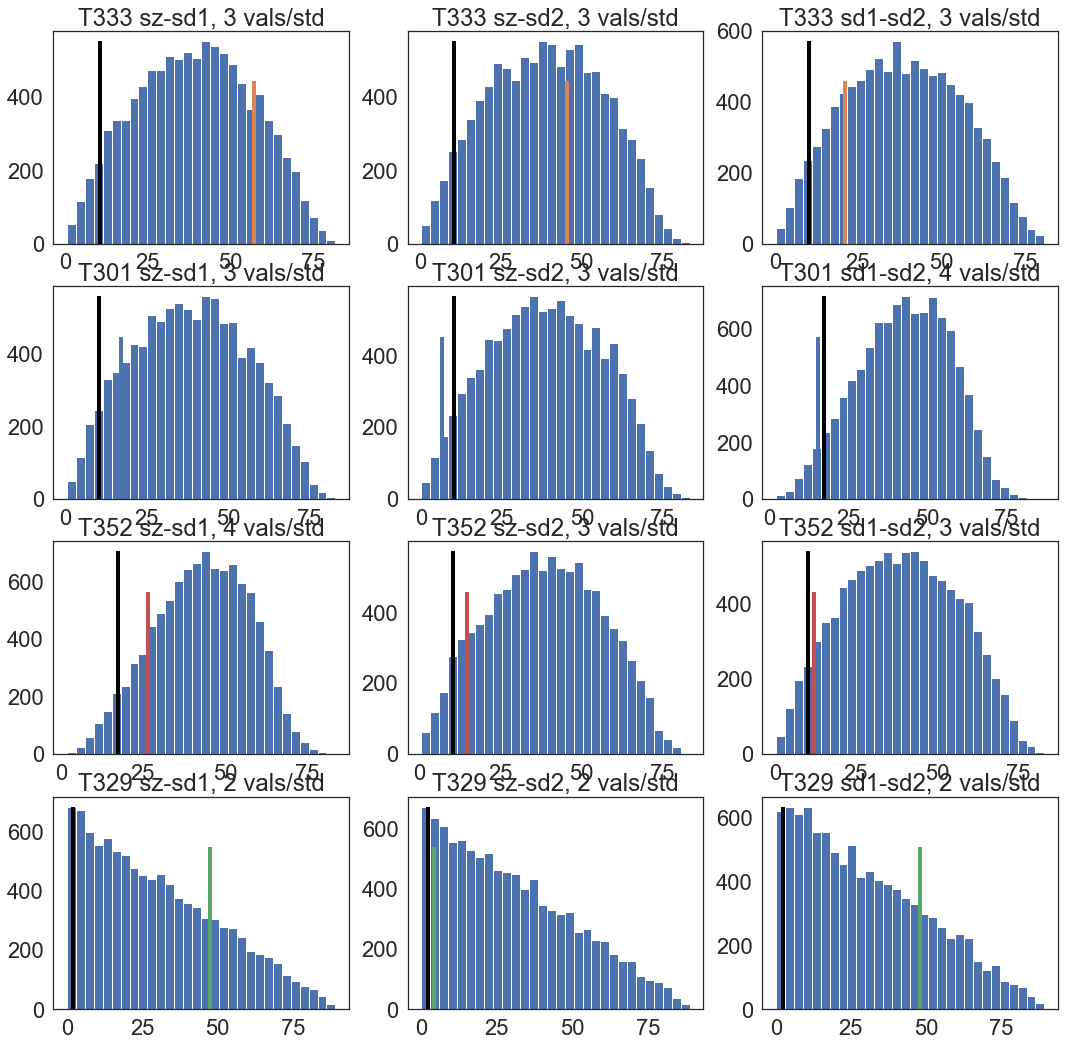

In [186]:
fig, axs = plt.subplots(nrows=n_mice, ncols=n_angle_types, figsize=(18,18))
for i_mouse in range(n_mice):
    for i_angle_type in range(n_angle_types):
        mouse_id = mouse_ids[i_mouse]
        angle_type = angle_types[i_angle_type]
        sim_data = np.sort(surrogates_res_dict[mouse_id][angle_type][2])  # need sorting later for threshold anyway
        measured_std = surrogates_res_dict[mouse_id][angle_type][1]
        n_measurements_per_std = surrogates_res_dict[mouse_id][angle_type][0]
        axs[i_mouse][i_angle_type].set_title(f"{mouse_id} {angle_type}, {n_measurements_per_std} vals/std")
        h = axs[i_mouse][i_angle_type].hist(sim_data, bins=30)
        ymax = max(h[0])  # hist returns n, bins, patches. n is the list of histogram values, take max of it for vline
        axs[i_mouse][i_angle_type].vlines(x=measured_std, ymin=0, ymax=0.8*ymax, color=mouse_colors[mouse_id], linewidth=4)
        #plot 95% threshold
        i_thr = ceil(0.05*len(sim_data))
        x_thr = sim_data[i_thr]  # sim_data is sorted
        axs[i_mouse][i_angle_type].vlines(x=x_thr, ymin=0, ymax=ymax, color="black", linewidth=4)
plt.show()

## Plot histogram of simulated SDs

In [187]:
# TODO: make sure there are no periodicity-related artifacts in sd-s! Need to change random angles generator, for example: 0+360...
# Use again unity vectors addition method. Also check for df_angles_v2

In [188]:
def stdOfUniformAngles(rng, n_angles=3, deg=False):
    if deg:
        full_angle=360.
    else:
        full_angle=2*pi
    angles = np.zeros(n_angles)
    for i_angle in range(n_angles):
        angles[i_angle] = rng.random()*full_angle
    return np.std(angles)

In [189]:
df_direction_cstds = df_angles_per_event[["mouse_id", "quantile_type", "theta"]].groupby(["mouse_id", "quantile_type"]).apply(lambda col: circstd(col["theta"])).reset_index(name="circstd")


# add n_events per mouse, event type (sz, sd1, sd2)
df_angles_per_event["n_events"] = 1
df_direction_cstds["n_events"] = df_angles_per_event[["mouse_id", "quantile_type", "n_events"]].groupby(["mouse_id", "quantile_type"], as_index=False).sum().n_events
df_angles_per_event = df_angles_per_event.drop(columns=["n_events"])

## StD of SD1, SD2, Sz angles compared to StD of same number of random angles (radians) 

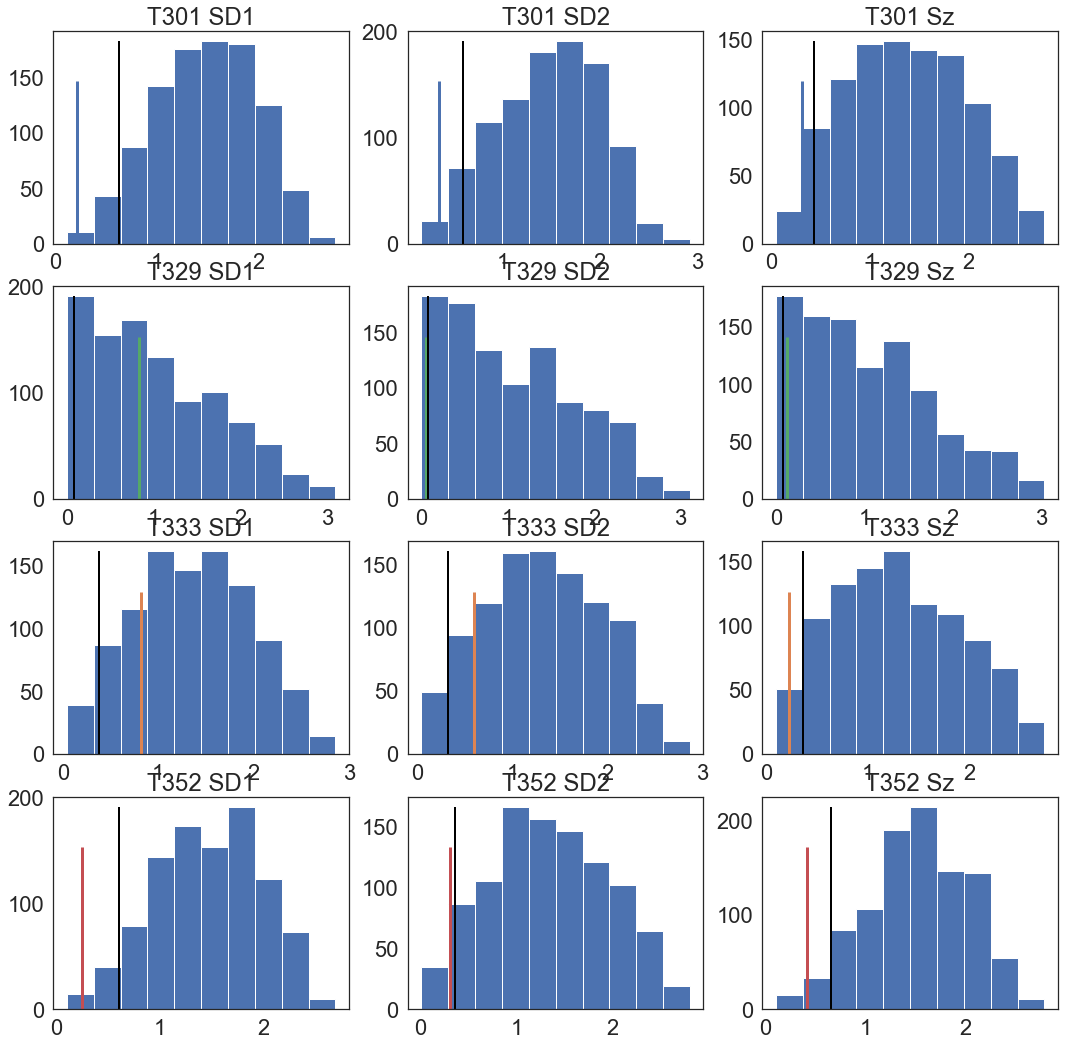

In [190]:
segment_types_dict = {"sd1": "SD1", "sd2": "SD2", "sz": "Sz"}

rows_map = {df_direction_cstds.mouse_id.unique()[i] : i for i in range(len(df_direction_cstds.mouse_id.unique()))}
cols_map = {df_direction_cstds.quantile_type.unique()[i] : i for i in range(len(df_direction_cstds.quantile_type.unique()))}
rng = np.random.default_rng(2023)

fig, axs = plt.subplots(nrows=len(df_direction_cstds.mouse_id.unique()), ncols=len(df_direction_cstds.quantile_type.unique()), figsize=(18,18))
for i_row, row in df_direction_cstds.iterrows():
    axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].set_title(f'{row["mouse_id"]} {segment_types_dict[row["quantile_type"]]}')
    sample = sorted([stdOfUniformAngles(rng, row["n_events"]) for i in range(1000)])
    h = axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].hist(sample)
    ymax = max(h[0])
    axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].vlines(x=row["circstd"], ymin=0, ymax=0.8*ymax, color=mouse_colors[row["mouse_id"]], linewidth=3)
    axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].vlines(x=sample[floor(0.05*len(sample))], ymin=0, ymax = ymax, color="black", linewidth=2)
plt.show()

## Same with degrees

In [191]:
df_angles_per_event_deg = df_angles_per_event.copy()
df_direction_cstds_deg = df_angles_per_event_deg[["mouse_id", "quantile_type", "theta_deg"]].groupby(["mouse_id", "quantile_type"]).apply(lambda col: std_func(col["theta_deg"])).reset_index(name="std")
# add n_events per mouse, event type (sz, sd1, sd2)
df_angles_per_event_deg["n_events"] = 1
df_direction_cstds_deg["n_events"] = df_angles_per_event_deg[["mouse_id", "quantile_type", "n_events"]].groupby(["mouse_id", "quantile_type"], as_index=False).sum().n_events
df_angles_per_event_deg = df_angles_per_event_deg.drop(columns=["n_events"])

In [192]:
df_direction_cstds_deg

mouse_id quantile_type        std  n_events
0      T301           sd1  14.419881         4
1      T301           sd2  22.412156         4
2      T301            sz  21.601742         3
3      T329           sd1  63.694857         2
4      T329           sd2   4.142394         2
5      T329            sz  10.047182         2
6      T333           sd1  55.174162         3
7      T333           sd2  40.711529         3
8      T333            sz  15.191958         3
9      T352           sd1  16.285584         4
10     T352           sd2  21.586370         3
11     T352            sz  26.983098         4

In [193]:
mouse_ids_lis = []
angle_types_lis = []
samples_lis = []

T301 sd1:	measured: 14.419881219464715,	simulated: 35.975200900774794,	p=0.002
T301 sd2:	measured: 22.4121564997226,	simulated: 34.10826336580372,	p=0.017
T301 sz:	measured: 21.601742485729464,	simulated: 24.70399481749668,	p=0.035
T329 sd1:	measured: 63.69485670274894,	simulated: 4.656523132302013,	p=0.598
T329 sd2:	measured: 4.142393896962983,	simulated: 4.660959632482701,	p=0.046
T329 sz:	measured: 10.047181899286615,	simulated: 4.774203283052827,	p=0.102
T333 sd1:	measured: 55.17416177155082,	simulated: 21.517514118621595,	p=0.297
T333 sd2:	measured: 40.71152858930717,	simulated: 18.49206226003813,	p=0.186
T333 sz:	measured: 15.191958443214117,	simulated: 20.30578794690038,	p=0.024
T352 sd1:	measured: 16.28558421780977,	simulated: 34.594134940130836,	p=0.005
T352 sd2:	measured: 21.586370250090486,	simulated: 20.804978192288782,	p=0.053
T352 sz:	measured: 26.983097946779406,	simulated: 37.322218655548006,	p=0.026


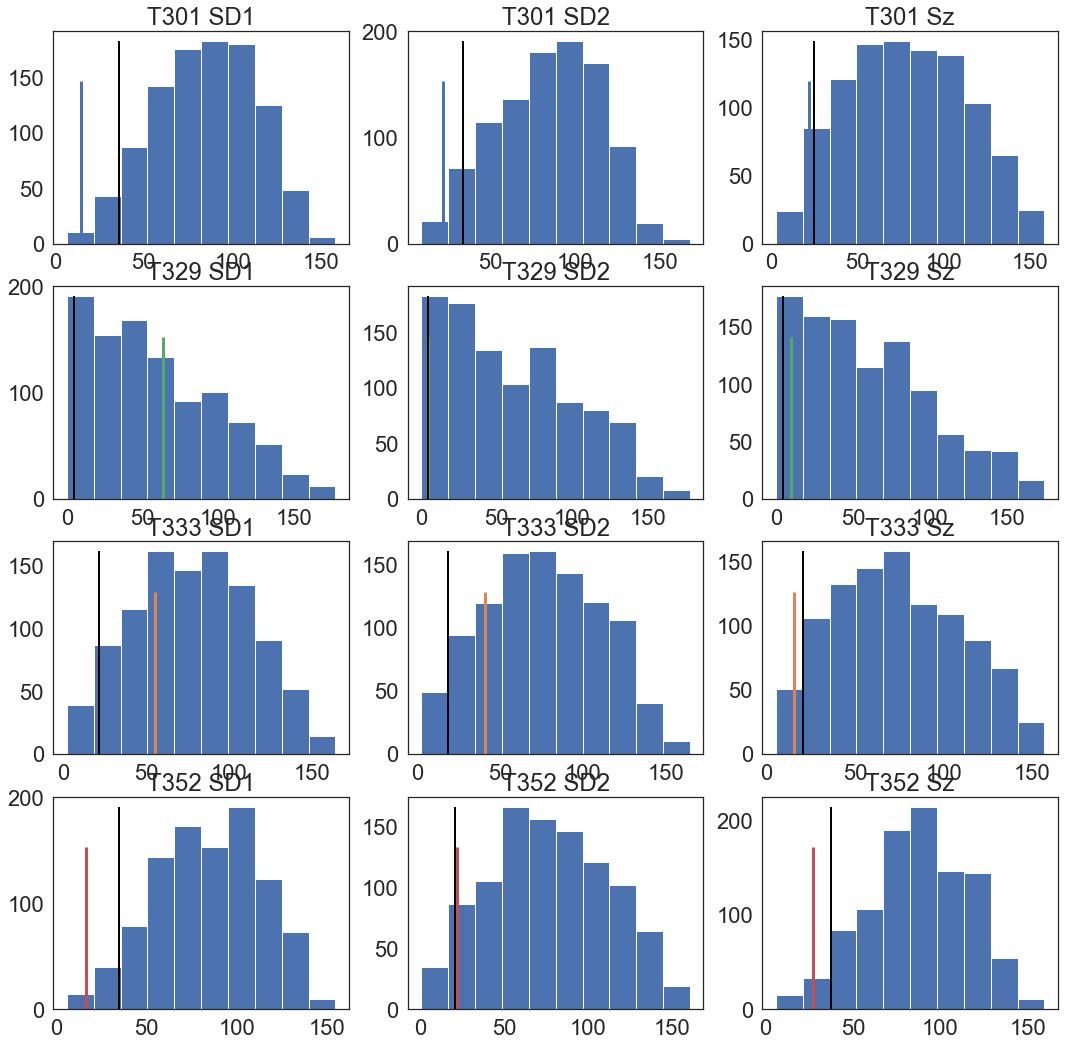

In [194]:
dict_surrogates = {mouse_id: {} for mouse_id in df_direction_cstds_deg.mouse_id.unique()}
stds_dict_flat = {"mouse_id": [], "angle_type": [], "measured_std": [], "n_measurements": [], "simulated_std_threshold_onetailed": [], "p": [], "alpha": [], "n_simulations": []}
segment_types_dict = {"sd1": "SD1", "sd2": "SD2", "sz": "Sz"}
rows_map = {df_direction_cstds_deg.mouse_id.unique()[i] : i for i in range(len(df_direction_cstds_deg.mouse_id.unique()))}
cols_map = {df_direction_cstds_deg.quantile_type.unique()[i] : i for i in range(len(df_direction_cstds_deg.quantile_type.unique()))}
alpha = 0.05
n_simulations = 1000
rng = np.random.default_rng(2023)
fig, axs = plt.subplots(nrows=len(df_direction_cstds_deg.mouse_id.unique()), ncols=len(df_direction_cstds_deg.quantile_type.unique()), figsize=(18,18))
for i_row, row in df_direction_cstds_deg.iterrows():
    axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].set_title(f'{row["mouse_id"]} {segment_types_dict[row["quantile_type"]]}')
    sample = sorted([stdOfUniformAngles(rng, row["n_events"], deg=True) for i in range(n_simulations)])  # len(sample) = n_simulations
    h = axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].hist(sample)
    ymax = max(h[0])
    # add measured std value
    axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].vlines(x=row["std"], ymin=0, ymax=0.8*ymax, color=mouse_colors[row["mouse_id"]], linewidth=3)
    # add simulated (surrogate) std value
    axs[rows_map[row["mouse_id"]]][cols_map[row["quantile_type"]]].vlines(x=sample[floor(alpha*len(sample))], ymin=0, ymax = ymax, color="black", linewidth=2)
    print(f'{row["mouse_id"]} {row["quantile_type"]}:\tmeasured: {row["std"]},\tsimulated: {sample[floor(alpha*len(sample))]},\tp={np.searchsorted( sample, row["std"])/len(sample)}')
    
    stds_dict_flat["mouse_id"].append(row["mouse_id"])
    stds_dict_flat["angle_type"].append(segment_types_dict[row["quantile_type"]])
    stds_dict_flat["measured_std"].append(row["std"])
    stds_dict_flat["n_measurements"].append(row["n_events"])
    stds_dict_flat["simulated_std_threshold_onetailed"].append(sample[floor(alpha*len(sample))])
    stds_dict_flat["p"].append(np.searchsorted( sample, row["std"])/len(sample))
    stds_dict_flat["alpha"].append(alpha)
    stds_dict_flat["n_simulations"].append(n_simulations)
    
    mouse_ids_lis += [row["mouse_id"] for i in range(len(sample))]
    angle_types_lis += [row["quantile_type"] for i in range(len(sample))]
    samples_lis += sample
    dict_surrogates[row["mouse_id"]][segment_types_dict[row["quantile_type"]]] = sample
    
    
plt.show()

## Plot surrogates over another

In [195]:
df_measurements = pd.DataFrame(data=stds_dict_flat, columns=["mouse_id","angle_type", "measured_std", "simulated_std_threshold_onetailed"])

In [196]:
samples_data = {"mouse_id": mouse_ids_lis, "angle_type": angle_types_lis, "sample": samples_lis}
df_samples = pd.DataFrame(data=samples_data)

### remove mouse with only 2 seizures

In [197]:
df_samples = df_samples[df_samples["mouse_id"] != "T329"]
df_measurements = df_measurements[df_measurements["mouse_id"] != "T329"]

In [198]:
pal = sns.color_palette() # sns.color_palette("ch:s=.25,rot=-.25", as_cmap=False)  # 
pal_light = sns.color_palette("pastel")
pal_dict = dict()
pal_light_dict = dict()
for i, mouse_id in enumerate(df_measurements.mouse_id.unique()):
    pal_dict[mouse_id] = pal[i]
    pal_light_dict[mouse_id] = pal_light[i]    

### Seizure

In [199]:
df_samples_sz = df_samples[df_samples["angle_type"] == "sz"]
df_measurements_sz = df_measurements[df_measurements["angle_type"] == "Sz"]

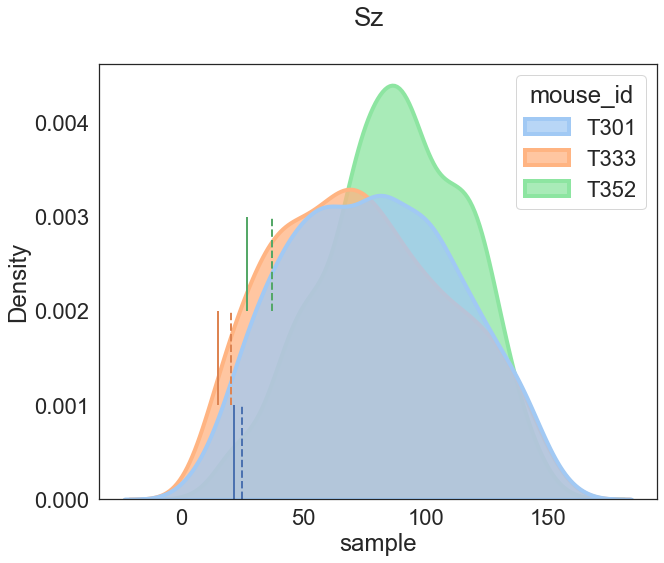

In [200]:
ymax = 0.0030
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle("Sz", fontsize=26)
sns.kdeplot(
    df_samples_sz,
    x="sample", hue="mouse_id",
    log_scale=False,
    palette=pal_light_dict,
    fill=True,
    alpha=0.75,
    linewidth=4,
    ax=ax
)
ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sz)
for i_meas, measurement in df_measurements_sz.iterrows():
    ax.vlines(x=measurement.simulated_std_threshold_onetailed, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linestyles="dashed", linewidth=2)
    ax.vlines(x=measurement.measured_std, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linewidth=2)
    ymin += y_step
    
if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_sz_kde_{get_datetime_for_fname()}.pdf')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

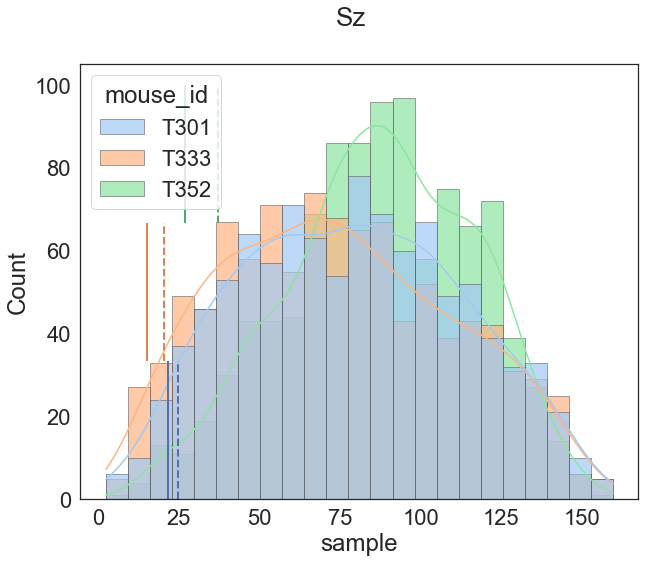

In [201]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle("Sz", fontsize=26)
ymax = 100
sns.histplot(
    df_samples_sz,
    x="sample", hue="mouse_id",
    multiple="layer",
    palette=pal_light_dict,
    edgecolor=".3",
    linewidth=.5,
    kde=True,
    log_scale=False,
    alpha=0.7,
    ax=ax
)

ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sz)
for i_meas, measurement in df_measurements_sz.iterrows():
    ax.vlines(x=measurement.simulated_std_threshold_onetailed, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linestyles="dashed", linewidth=2)
    ax.vlines(x=measurement.measured_std, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linewidth=2)
    ymin += y_step

if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_sz_hist_{get_datetime_for_fname()}.pdf')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

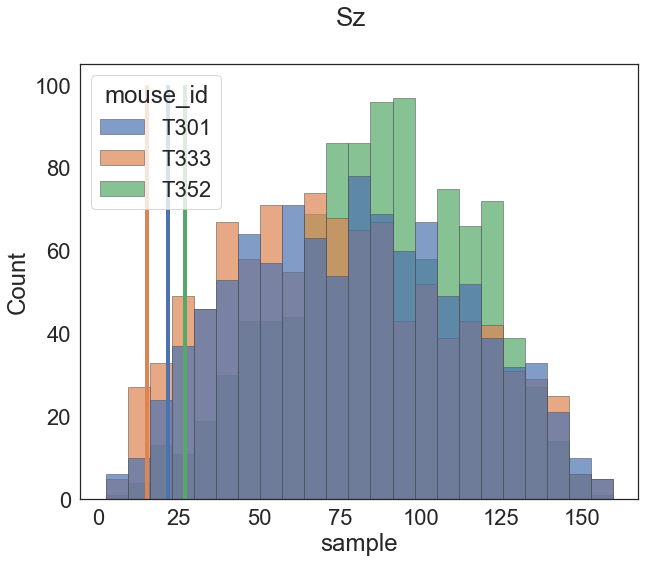

In [202]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle("Sz", fontsize=26)
ymax = 100
sns.histplot(
    df_samples_sz,
    x="sample", hue="mouse_id",
    multiple="layer",
    palette=pal_dict,
    edgecolor=".3",
    linewidth=.5,
    kde=False,
    log_scale=False,
    alpha=0.7,
    ax=ax
)

ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sz)
for i_meas, measurement in df_measurements_sz.iterrows():
    ax.vlines(x=measurement.measured_std, ymin=0,ymax=ymax, colors=pal_dict[measurement.mouse_id], linewidth=4)
plt.show()

### SD1

In [203]:
df_samples_sd1 = df_samples[df_samples["angle_type"] == "sd1"]
df_measurements_sd1 = df_measurements[df_measurements["angle_type"] == "SD1"]

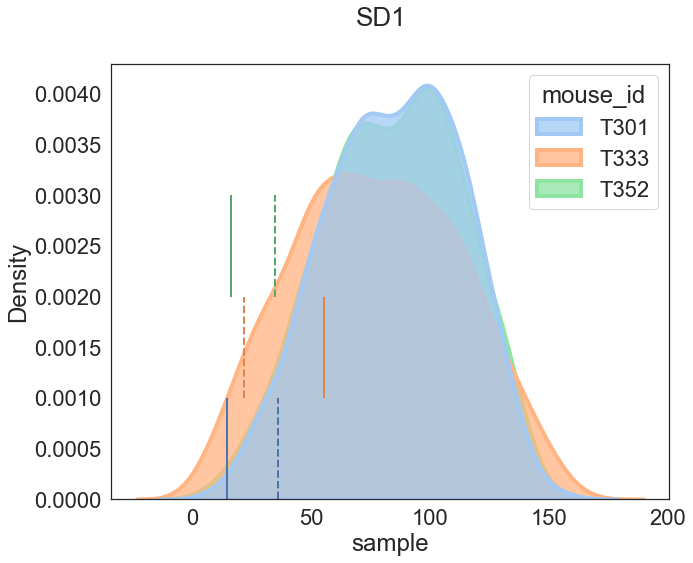

In [204]:
ymax = 0.0030
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle("SD1", fontsize=26)
sns.kdeplot(
    df_samples_sd1,
    x="sample", hue="mouse_id",
    log_scale=False,
    palette=pal_light_dict,
    fill=True,
    alpha=0.75,
    linewidth=4,
    ax=ax
)
ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sd1)
for i_meas, measurement in df_measurements_sd1.iterrows():
    ax.vlines(x=measurement.simulated_std_threshold_onetailed, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linestyles="dashed", linewidth=2)
    ax.vlines(x=measurement.measured_std, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linewidth=2)
    ymin += y_step
    
if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_sd1_kde_{get_datetime_for_fname()}.pdf')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

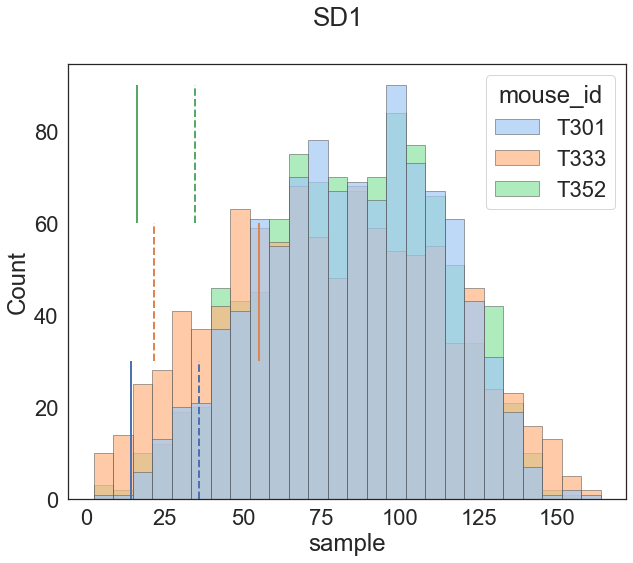

In [205]:
fig, ax = plt.subplots(figsize=(10,8))
ymax = 90
plt.suptitle("SD1", fontsize=26)
sns.histplot(
    df_samples_sd1,
    x="sample", hue="mouse_id",
    multiple="layer",
    palette=pal_light_dict,
    edgecolor=".3",
    linewidth=.5,
    kde=False,
    log_scale=False,
    alpha=0.7,
    ax=ax
)

ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sd1)
for i_meas, measurement in df_measurements_sd1.iterrows():
    ax.vlines(x=measurement.simulated_std_threshold_onetailed, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linestyles="dashed", linewidth=2)
    ax.vlines(x=measurement.measured_std, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linewidth=2)
    ymin += y_step
if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_sd1_hist_{get_datetime_for_fname()}.pdf')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

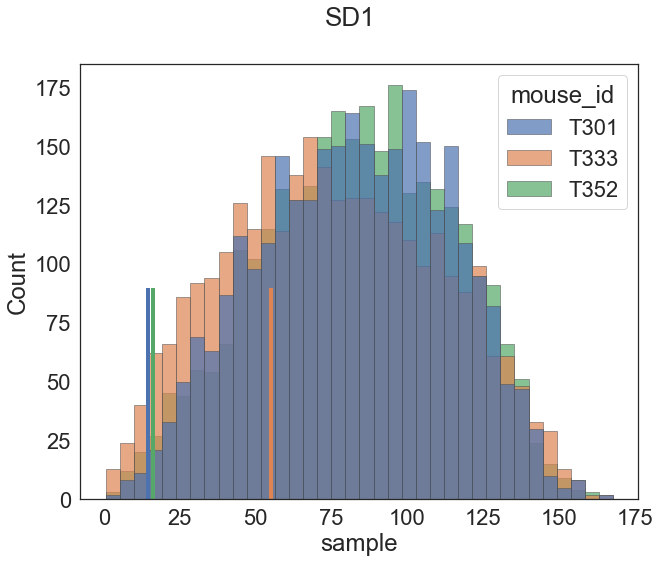

In [206]:
fig, ax = plt.subplots(figsize=(10,8))
ymax = 90
plt.suptitle("SD1", fontsize=26)
sns.histplot(
    df_samples,
    x="sample", hue="mouse_id",
    multiple="layer",
    palette=pal_dict,
    edgecolor=".3",
    linewidth=.5,
    kde=False,
    log_scale=False,
    alpha=0.7,
    ax=ax
)

ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sd1)
for i_meas, measurement in df_measurements_sd1.iterrows():
    ax.vlines(x=measurement.measured_std, ymin=0,ymax=ymax, colors=pal_dict[measurement.mouse_id], linewidth=4)
plt.show()

### SD2

In [207]:
df_samples_sd2 = df_samples[df_samples["angle_type"] == "sd2"]
df_measurements_sd2 = df_measurements[df_measurements["angle_type"] == "SD2"]

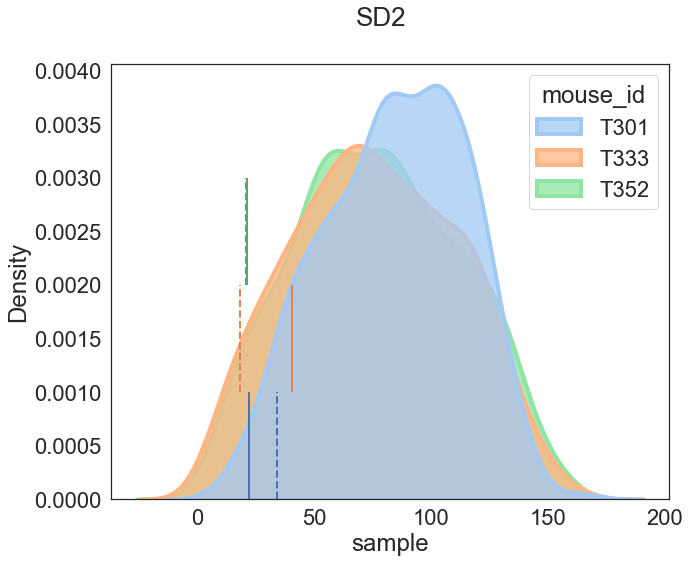

In [208]:
ymax = 0.0030
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle("SD2", fontsize=26)
sns.kdeplot(
    df_samples_sd2,
    x="sample", hue="mouse_id",
    log_scale=False,
    palette=pal_light_dict,
    fill=True,
    alpha=0.75,
    linewidth=4,
    ax=ax
)
ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sd2)
for i_meas, measurement in df_measurements_sd2.iterrows():
    ax.vlines(x=measurement.simulated_std_threshold_onetailed, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linestyles="dashed", linewidth=2)
    ax.vlines(x=measurement.measured_std, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linewidth=2)
    ymin += y_step
    
if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_sd2_kde_{get_datetime_for_fname()}.pdf')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

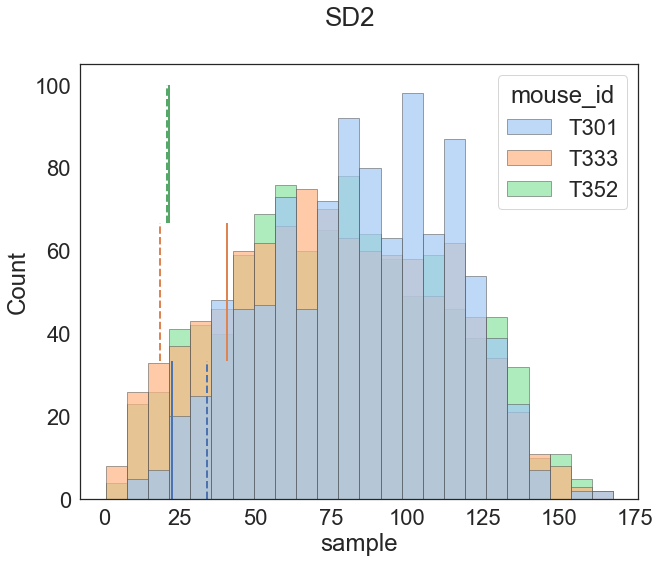

In [209]:
fig, ax = plt.subplots(figsize=(10,8))
ymax = 100
plt.suptitle("SD2", fontsize=26)
sns.histplot(
    df_samples_sd2,
    x="sample", hue="mouse_id",
    multiple="layer",
    palette=pal_light_dict,
    edgecolor=".3",
    linewidth=.5,
    kde=False,
    log_scale=False,
    alpha=0.7,
    ax=ax
)

ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sd2)
for i_meas, measurement in df_measurements_sd2.iterrows():
    ax.vlines(x=measurement.simulated_std_threshold_onetailed, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linestyles="dashed", linewidth=2)
    ax.vlines(x=measurement.measured_std, ymin=ymin,ymax=ymin+y_step, colors=pal_dict[measurement.mouse_id], linewidth=2)
    ymin += y_step

if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_sd2_hist_{get_datetime_for_fname()}.pdf')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")
plt.show()

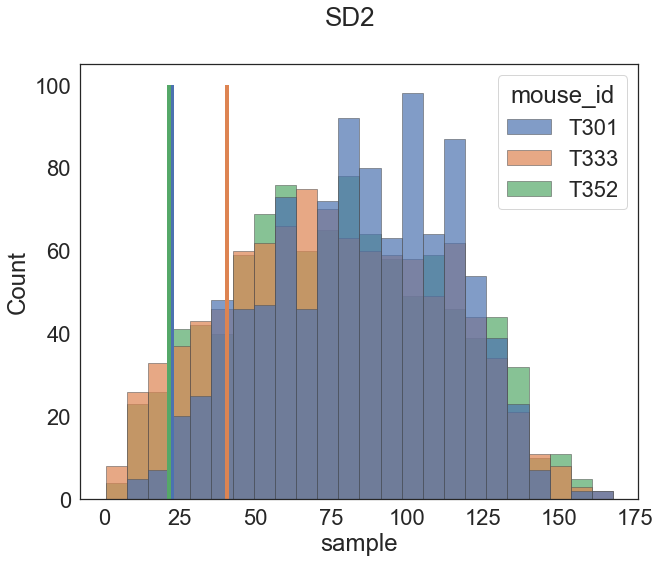

In [210]:
fig, ax = plt.subplots(figsize=(10,8))
ymax = 100
plt.suptitle("SD2", fontsize=26)
sns.histplot(
    df_samples_sd2,
    x="sample", hue="mouse_id",
    multiple="layer",
    palette=pal_dict,
    edgecolor=".3",
    linewidth=.5,
    kde=False,
    log_scale=False,
    alpha=0.7,
    ax=ax
)

ymin = 0
y_step = (ymax-ymin)/len(df_measurements_sd2)
for i_meas, measurement in df_measurements_sd2.iterrows():
    ax.vlines(x=measurement.measured_std, ymin=0,ymax=ymax, colors=pal_dict[measurement.mouse_id], linewidth=4)
plt.show()

## Create illustratory plot for one mouse

In [211]:
df_samples

mouse_id angle_type      sample
0         T301        sd1    6.633038
1         T301        sd1    8.949342
2         T301        sd1   15.300964
3         T301        sd1   15.363197
4         T301        sd1   16.262126
...        ...        ...         ...
11995     T352         sz  147.283081
11996     T352         sz  148.968096
11997     T352         sz  150.584166
11998     T352         sz  151.547889
11999     T352         sz  159.606956

[9000 rows x 3 columns]

In [212]:
segment_types_dict

{'sd1': 'SD1', 'sd2': 'SD2', 'sz': 'Sz'}

sd1
T301 sd1:	measured: 14.419881219464715,	simulated: 35.975200900774794,	p=0.002
sd2
T301 sd2:	measured: 22.4121564997226,	simulated: 34.10826336580372,	p=0.017
sz
T301 sz:	measured: 21.601742485729464,	simulated: 24.70399481749668,	p=0.035


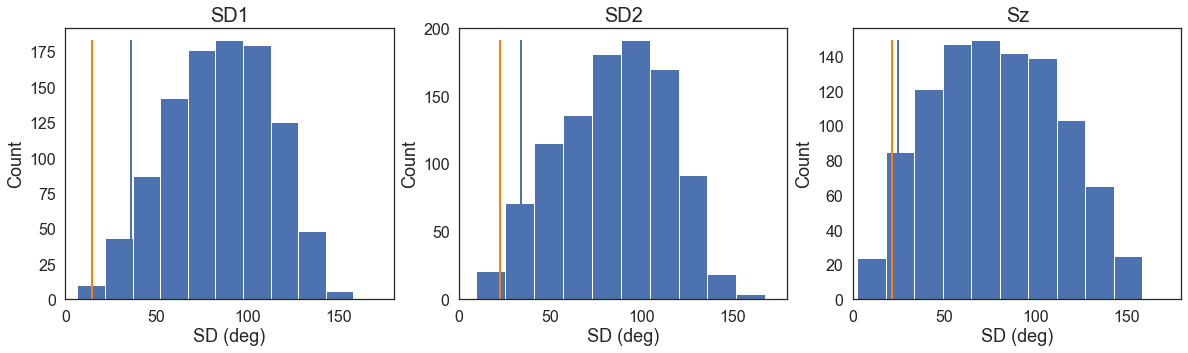

In [213]:
example_id = "T301"
df_direction_stds_deg_single = df_direction_cstds_deg[df_direction_cstds_deg["mouse_id"] == example_id]
rows_map = {df_direction_stds_deg_single.mouse_id.unique()[i] : i for i in range(len(df_direction_stds_deg_single.mouse_id.unique()))}
cols_map = {df_direction_stds_deg_single.quantile_type.unique()[i] : i for i in range(len(df_direction_stds_deg_single.quantile_type.unique()))}
rng = np.random.default_rng(2023)

fig, axs = plt.subplots(nrows=len(df_direction_stds_deg_single.mouse_id.unique()), ncols=len(df_direction_stds_deg_single.quantile_type.unique()), figsize=(20,5))
segment_types_dict = {"sd1": "SD1", "sd2": "SD2", "sz": "Sz"}
for i_row, row in df_direction_stds_deg_single.iterrows():
    # only 1 mouse, so axs is 1D
    
    axs[cols_map[row["quantile_type"]]].set_title(f'{segment_types_dict[row["quantile_type"]]}', fontsize=20)
    print(row["quantile_type"])
    sample = df_samples[(df_samples["mouse_id"] == row["mouse_id"]) & (df_samples["angle_type"] == row["quantile_type"])]["sample"].to_numpy() #sorted([stdOfUniformAngles(rng, row["n_events"], deg=True) for i in range(1000)])
    h = axs[cols_map[row["quantile_type"]]].hist(sample)
    ymax = max(h[0])
    # add measured std value
    axs[cols_map[row["quantile_type"]]].vlines(x=row["std"], ymin=0, ymax=ymax, color=mpl.colormaps["tab10"](1), linewidth=2)
    # add simulated (surrogate) std value
    axs[cols_map[row["quantile_type"]]].vlines(x=sample[floor(0.05*len(sample))], ymin=0, ymax = ymax, cmap=mpl.colormaps["tab10"], linewidth=2)
    print(f'{row["mouse_id"]} {row["quantile_type"]}:\tmeasured: {row["std"]},\tsimulated: {sample[floor(0.05*len(sample))]},\tp={np.searchsorted( sample, row["std"])/len(sample)}')

for ax in axs:
    ax.set_xlim((0, 180))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("SD (deg)", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    
if save_figs:
    fig_fpath = os.path.join(output_folder, f'angles_std_illustrative_surrogate_{get_datetime_for_fname()}{file_format}')
    plt.savefig(fig_fpath)
    print(f"Saved to {fig_fpath}")    
plt.show()

In [214]:
# TODO: check again why different 3b sz grid is to 3a 

In [215]:
df_angles_per_event["theta_deg_inj_top"] = df_angles_per_event["theta_inj_top"]*180./pi

In [216]:
#df_angles_per_event.to_excel("D:\\Downloads\\angles_per_event.xlsx")

# Export datasets

In [217]:
save_dataset = True
if save_dataset:
    export_dir = fh.open_dir("Choose export folder!")

### Export StD surrogate statistical results

In [218]:
if save_dataset:
    export_fname = f"angles_std_and_surrogate_{get_datetime_for_fname()}.json"
    export_fpath = os.path.join(export_dir, export_fname)
    print(f"Saving SD1, 2, Sz angle StD vs surrogates data to {export_fpath}")
    with open(export_fpath, 'w') as json_file:
        json.dump(stds_dict_flat, json_file)

Saving SD1, 2, Sz angle StD vs surrogates data to D:\Output\angles_std_and_surrogate_20250429-114522.json


In [219]:
if save_dataset:
    df_angles_v2_export = df_angles_v2.sort_values(by=["mouse_id", "uuid_matched"]).dropna()

In [230]:
if save_dataset:
    samples_fpath = os.path.join(export_dir, "surrogates.xlsx")
    df_samples.to_excel(samples_fpath, index=False)

### Convert uuid to integer event index for export

In [220]:
if save_dataset:
    df_angles_v2_export["event_index"] = df_angles_v2_export.groupby('uuid_matched', sort=False).ngroup() + 1  # convert to 1-indexing

In [221]:
if save_dataset:
    export_dict = dict()
    export_dict["mouse_id"] = df_angles_v2_export.mouse_id
    export_dict["angle_type"] = df_angles_v2_export.angle_type
    export_dict["angle_deg"] = df_angles_v2_export.angle_deg
    export_dict["angle_rad"] = df_angles_v2_export.angle
    export_dict["event_index"] = df_angles_v2_export.event_index

In [222]:
if save_dataset:
    export_fname = f"angles_per_event_dataset_{get_datetime_for_fname()}.h5"
    export_fpath = os.path.join(export_dir, export_fname)
    with h5py.File(export_fpath, "w") as hf:
        for key in export_dict.keys():
            if type(export_dict[key][0]) == str:
                print(f"{key} converted to dtype=\'S\'")
                hf.create_dataset(key, data=np.array(export_dict[key], dtype='S'))
            else:
                hf.create_dataset(key, data=export_dict[key])
    print(f"Saved dataset to {export_fpath}")

mouse_id converted to dtype='S'
angle_type converted to dtype='S'
Saved dataset to D:\Output\angles_per_event_dataset_20250429-114522.h5


# Statistical test of mean relative angles per mouse
repeated measures (paired measurements) 

In [223]:
# TODO: proper saving and naming...

In [224]:
df_angles_mean_per_mouse.to_excel(os.path.join(export_dir, "angles_mean_per_mouse.xlsx"), index=False)

In [225]:
df_angles_v2_export.to_excel(os.path.join(export_dir, "angles.xlsx"), index=False)